In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau, linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score,explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

import xgboost as xgb

import datarobot as dr

import json

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Helper Functions

In [2]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [3]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [4]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [5]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'fre' in features_to_use:
        fre = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_fre/', is_weighted)
        print('fre', len(fre))
        features = add_to_features(features, fre).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hwp/', is_weighted)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()
    
    if 'hrrr_moisture' in features_to_use:
        hrrr_moisture = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hrrr_moisture/', is_weighted)
        print('hrrr_moisture', len(hrrr_moisture))
        features = add_to_features(features, hrrr_moisture).drop_duplicates()
        
    if 'hdw500' in features_to_use:
        hdw500 = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hdw500/', is_weighted)
        print('hdw500', len(hdw500))
        features = add_to_features(features, hdw500).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        """resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')"""
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources_split/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()
        

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()
        
    if 'pop' in features_to_use:
        pop = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pop/', is_weighted)
        print('pop', len(pop))
        features = add_to_features(features, pop).drop_duplicates()
        
    if 'structures' in features_to_use:
        structures = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_structures/', '')
        print('structures', len(structures))
        features = add_to_features(features, structures).drop_duplicates()
        
    if 'gridmet' in features_to_use:
        gridmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_gridmet/',is_weighted)
        gridmet= gridmet.rename({'wind_speed': 'wind_speed_gridmet','mean_vapor_pressure_deficit':'vpd_gridmet'}, axis='columns')
        print('gridmet', len(gridmet))
        features = add_to_features(features, gridmet).drop_duplicates()
        
    if 'slope' in features_to_use:
        slope = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_slope/',is_weighted)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()
        
    if 'elevation' in features_to_use:
        elevation = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_elevation/',is_weighted)
        print('elevation', len(elevation))
        features = add_to_features(features, elevation).drop_duplicates()
        
    if 'heatwave' in features_to_use:
        heatwave = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_heatwave/','')
        print('heatwave', len(heatwave))
        features = add_to_features(features, heatwave).drop_duplicates()
        
    if 'hrrrmet' in features_to_use:
        hrrrmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_hrrrmet/',is_weighted)
        hrrrmet= hrrrmet.rename({'wind_speed': 'wind_speed_hrrrmet','vpd_2m':'vpd_hrrrmet'}, axis='columns')
        print('hrrrmet', len(hrrrmet))
        features = add_to_features(features, hrrrmet).drop_duplicates()
        
    return features


In [6]:
def find_outliers(df, col_name):
    quantiles = df[col_name].quantile(q=[.25, .5, .75])
    print(quantiles)
    iqr = quantiles[0.75]-quantiles[0.25]
    lower_fence = quantiles[0.50]-(1.5*iqr)
    upper_fence = quantiles[0.50]+(1.5*iqr)
    print('lower and upper fences are: '+ str(lower_fence) + ', '+ str(upper_fence))
    df[col_name+'_is_outlier'] = np.where((df[col_name]<=lower_fence)| (df[col_name]>=upper_fence), True,False)
    return df

In [7]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [8]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [9]:
def get_dfeatures(df, names, suf_now, suf_back): #to today/yesterday, flip it later
    for name in names:
        df['d'+name+suf_now] = df[name+suf_now]/df[name+suf_back]
    return df

In [10]:
def plot_category_heatmap(data_plot, obs_label, mod_label, model_axis_label):
    conf_mat = confusion_matrix(data_plot[obs_label], data_plot[mod_label], labels=['decrease', 'no_change', 'increase'])
    columns = ['decrease', 'slight \n change', 'increase'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    #swap order of rows and cols
    df_cm_reverse = df_cm.iloc[::-1]

    # Visualize it as a heatmap
    sns.heatmap(df_cm_reverse, annot=True,cmap='rocket_r', fmt='g' ) #fmt g keeps things out of scientific notation
    plt.xlabel(model_axis_label)
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_plot[obs_label], data_plot[mod_label]))
    
    
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,7), np.arange(-1,7), 'k-')
    axn.plot(np.arange(-1,7), np.arange(-1,7)*lr.slope+lr.intercept, 'r-')
    axn.text(0.2,3.8,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRP R2='+str(round(errors[0],3))
             +'\n FRP R2='+str(round(errors[1],3))
             +'\n FRP RMSE='+str(round(errors[2],3))
             +'\n FRP MAD='+str(round(errors[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.ylabel('Observed Log(FRP)')
    plt.xlabel(x_axis_label)
    plt.show()


def plot_2dhist_withfit(df_plot, x_data, y_data, log_x_data,log_y_data, inc_cutoff, dec_cutoff, title):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)

    fig, axn = plt.subplots()#figsize=(6,6))
    

    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    sns.histplot(data=df_plot, x=log_x_data, y=log_y_data, bins=20,cbar=True, ax=axn) 
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'b-')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    
    
    #plt.text(-1.6,0.8,log_y_data+'=\n'+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2)), fontsize=12)
    plt.text(-1.4, 0.3,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors[0],3))
             +'\n SF R2='+str(round(errors[1],3))
             +'\n SF RMSE='+str(round(errors[2],3))
             +'\n SF MAD='+str(round(errors[3],3)), fontsize=10)
    plt.title(title)
    plt.show()
    


In [11]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*0.1)) #left hand approximation, assuming bins are 5 wide

# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.nanmean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def MeAD(y_pred,y_test): #aka median error
    return np.nanmedian(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def median_percent_error(y_pred,y_test):
    return(np.nanmedian(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.nanmedian(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [12]:
#IN forest: a trained random forest
#IN varnames: names of the training variables, list of strings
#IN plot_title: title of the resulting plot 
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_ #importances for all trees, so if you have 100 trees and 5 features this is a 100x5 (or 5x100) matrix
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    df_plot = pd.DataFrame({'tree_indices': tree_indices, 'importances': importances, 'std':std, 'varnames':varnames})
    df_plot = df_plot.sort_values(by='importances').reset_index(drop=True) #sorts from high to low importance

    #make the figure 
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 20))
    ax1.barh(df_plot.index, df_plot['importances'], height=0.7,xerr = std) #horizontal bar plot
    ax1.set_yticks(df_plot.index) #set the ticks
    ax1.set_yticklabels(df_plot['varnames']) #set the names of the ticks
    ax1.set_ylim((-0.5, len(df_plot['importances']))) #the height of the figure depends on the # of variables plotted
    fig.tight_layout()
    plt.title(plot_title) #title!
    plt.show()

In [13]:
#this function can pick out categories and add in additional variables (1-2 variables recommended for sanity)

def generate_sensitivity_list(feat_dict, category_selected_list, additional_to_append):
    sub = []
    for item in category_selected_list: #add the categories
        sub = sub+feat_dict[item]

    for item2 in additional_to_append: #add the other variables, for instance if we want all categories and then HWP
        sub = sub+[item2]
    
    return sub

In [14]:
def summarize_error(df, truth_name, method_name, train_vars):
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    n = len(df[truth_name].values)
    k = len(train_vars)
    
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-k-1))
    
    return(r2,adjusted_r2, rmse, mad)
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(df_plot,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(df_plot, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')

    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,11), np.arange(-1,11), 'k-')
    axn.plot(np.arange(-1,11), np.arange(-1,11)*lr.slope+lr.intercept, 'r-')
    axn.text(4.2,7.7,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRE R2='+str(round(errors_logfre[0],3))
             +'\n FRE R2='+str(round(errors_fre[0],3))
             +'\n FRE Adj. R2='+str(round(errors_fre[1],3))
             +'\n FRE RMSE='+str(round(errors_fre[2],3))
             +'\n FRE MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(4,10)
    plt.ylim(4,10)
    plt.ylabel('Observed Log(FRE)')
    plt.xlabel(x_axis_label)
    plt.show()
    
def sf_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, inc_cutoff, dec_cutoff, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(data_test_2020,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(data_test_2020, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=np.arange(-1.5,1.5,.2), norm=norm, cmap=cmap)
    
    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    axn.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    axn.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'r-')
    axn.text(-1.5,0.4,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors_logfre[0],3))
             +'\n SF R2='+str(round(errors_fre[0],3))
             +'\n SF Adj. R2='+str(round(errors_fre[1],3))
             +'\n SF RMSE='+str(round(errors_fre[2],3))
             +'\n SF MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.ylabel('Observed Log(SF)')
    plt.xlabel(x_axis_label)
    plt.show()

In [15]:
def plot_correlations(df_all, fig_title,correlation_type, font_size, figsize_tuple):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=figsize_tuple)
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':font_size})
    plt.title(fig_title, fontsize=30)
    plt.show()

# Prepare the features for ML

the generate_feature_vector code generates duplicate rows that must be dropped

In [17]:
#with Surface def of HDW
features = generate_feature_vector([2019,2020,2021], 'Weighted', ['rave', 'fre','hwp', 'hdw', 'imerg', 'gridmet','hrrrmet',
                                                                  'heatwave',''
                                                                  'pft', 'chi',
                                                                  'smops','ncar',
                                                                  'pws','esi',
                                                                  'loading',
                                                                  'slope','elevation',
                                                                  'resources','pop','structures'])
print('With one day fires: ', len(np.unique(features['irwinID'])), len(features))

rave 5432
fre 5432


KeyboardInterrupt: 

In [17]:
#WITH 500M DEFINITION OF HDW and hrrr forecasted moiosture
features = generate_feature_vector([2019,2020,2021], 'Weighted', ['rave', 'fre','hwp', 'hdw500', 'imerg', 'gridmet','hrrrmet',
                                                                  'heatwave',''
                                                                  'pft', 'chi',
                                                                  'smops','ncar','hrrr_moisture',
                                                                  'pws','esi',
                                                                  'loading',
                                                                  'slope','elevation',
                                                                  'resources','pop','structures'])
print('With one day fires: ', len(np.unique(features['irwinID'])), len(features))

rave 5432
fre 5432
hwp 5432
hrrr_moisture 5353
hdw500 5432
resources 11146
pft 5432
smops 5432
imerg 5339
pws 5432
loading 5432
ncar 5199
esi 5444
chi 6437
pop 5432
structures 12296
gridmet 5353
slope 5432
elevation 5432
heatwave 5353
hrrrmet 5353
With one day fires:  386 4795


In [1]:
# drop fires that last one day
features_ge_2 = features[features.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print('Dropping one day fires: ', len(np.unique(features_ge_2['irwinID'])), len(features_ge_2))

features_ge_3 = features[features.groupby('irwinID')['day'].transform('size').ge(3)].reset_index(drop=True)
print('Dropping one and two day fires: ', len(np.unique(features_ge_3['irwinID'])), len(features_ge_3))

features_ge = features_ge_2.drop(columns=['hwp_1'])#.rename(columns={'hwp_1':'hwp_1_poly'}) #get rid of the new HWP_1 (same poly, prev day)

NameError: name 'features' is not defined

In [ ]:
print(features_ge.columns.values)

### One Day of Shifting

In [19]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

features_to_shift = ['FRP_MEAN','FRE',
                     'vpd_gridmet', 'wind_speed_gridmet',#raw weather
                     'vpd_hrrrmet', 'wind_speed_hrrrmet',#raw weather
                     'max_air_temperature', #raw weather
                     'hwp', 
                     'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #derived weather
                     'IMERG.FINAL.v6_FWI','IMERG.FINAL.v6_BUI', 'burning_index_g','energy_release_component-g',
                     'PFT', 'chi', 
                     'percent_contained',
                     'personnel', 'crew_quantity', 'crew_personnel','engine_quantity', 'engine_personnel', 'air_quantity', 
                    'air_personnel','construction_quantity', 'construction_personnel','overhead_personnel',
                    'structures_destroyed', 'structures_damaged', 'structures_threatened_72']#features_ge.columns.values[2:]
features_shifted_1 = [] #one day shifts

print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted_1.append(features_to_shift[ii]+'_1')


features_with_shifts_weighted = pd.DataFrame()

for jj in range(len(events)):
    df_fire = features_ge[features_ge['irwinID']==events[jj]].drop_duplicates(subset='day') #removes duplicate rows
    df_fire_shifted_1 = shift_ndays(df_fire, 1, features_to_shift, features_shifted_1, 'day')

    
    
    df_fire_concat = pd.concat([df_fire_shifted_1, 
                                df_fire_shifted_2[features_shifted_2]], axis=1)    
    
    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, 
                                               df_fire_concat], axis=0).reset_index(drop=True)
    

#get the scaling factor, USING FRE
features_with_shifts_weighted['Scaling_Factor'] = features_with_shifts_weighted['FRE']/features_with_shifts_weighted['FRE_1']

#get the log of the scaling factor
features_with_shifts_weighted['Log_Scaling_Factor']= np.log10(features_with_shifts_weighted['Scaling_Factor'])

#replace infs with nans, dropping days that were added for the shift as well as days where the scaling factor may have gone to inf
features_with_shifts_weighted.replace([np.inf, -np.inf], np.nan, inplace=True)
#drop nans (get rid of this for testing the 19/20 WF/DIXIE case)
features_with_shifts_weighted.dropna(axis=0,how='any').reset_index(drop=True)
print(len(features_with_shifts_weighted))

#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled

['FRP_MEAN', 'FRE', 'vpd_gridmet', 'wind_speed_gridmet', 'vpd_hrrrmet', 'wind_speed_hrrrmet', 'max_air_temperature', 'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_BUI', 'burning_index_g', 'energy_release_component-g', 'PFT', 'chi', 'percent_contained', 'personnel', 'crew_quantity', 'crew_personnel', 'engine_quantity', 'engine_personnel', 'air_quantity', 'air_personnel', 'construction_quantity', 'construction_personnel', 'overhead_personnel', 'structures_destroyed', 'structures_damaged', 'structures_threatened_72']
6110
0.25   -0.480233
0.50   -0.021434
0.75    0.419918
Name: Log_Scaling_Factor, dtype: float64
lower and upper fences are: -1.3716597670327255, 1.328792706888366
5750
    datetime                               irwinID         day       FRP_MEAN  \
0 2020-09-08  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-08  102303.436315   
1 2020-09-09  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-09   18779.802910   
2 2020-09-10  00B3EDB2-87A4-4D0A-

In [20]:
features_relative = get_dfeatures(features_with_shifts_weighted,
                                  [
                     'vpd_gridmet', 'wind_speed_gridmet',
                     'vpd_hrrrmet', 'wind_speed_hrrrmet',
                     'max_air_temperature',
                     'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 
                     'IMERG.FINAL.v6_FWI','IMERG.FINAL.v6_BUI', 'burning_index_g','energy_release_component-g',
                     'PFT', 'chi', ], 
                                '', '_1') #to today/yesterday, flip it later
features_relative

datetime                               irwinID         day  \
0    2020-09-08  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-08   
1    2020-09-09  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-09   
2    2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-10   
3    2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-11   
4    2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-12   
...         ...                                   ...         ...   
6105 2019-08-05  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA  2019-08-05   
6106 2019-08-06  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA  2019-08-06   
6107 2019-08-07  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA  2019-08-07   
6108 2020-09-17  FFCB89F5-98FB-4C3A-9554-3D1554181A63  2020-09-17   
6109 2020-09-18  FFCB89F5-98FB-4C3A-9554-3D1554181A63  2020-09-18   

           FRP_MEAN           FRE        hwp  soilm_sfc  soilm_1cm  soilm_4cm  \
0     102303.436315  3.682923e+08  38.738924  14.319774   0.155105   0.159016   
1      18779.802910  6.760729e+07  34.751228  10.969652   0.155798   0.159142   
2      14731.512078  5.303344e+07  20.266123  11.257049   0.152651   0.154164   
3       2706.065915  9.741837e+06   4.070484  19.006294   0.151177   0.157460   
4       1349.205056  4.857138e+06   5.601118  12.335567   0.153391   0.161484   
...             ...           ...        ...        ...        ...        ...   
6105   35859.885506  1.290956e+08  26.468965   2.961352   0.164577   0.165835   
6106    7581.656204  2.729396e+07  30.501696   5.877340   0.165521   0.167418   
6107     493.522446  1.776681e+06  15.781312  10.132459   0.170797   0.171001   
6108    5779.058105  2.080461e+07  48.524485   0.560344   0.102336   0.101694   
6109    8980.300549  3.232908e+07  45.646802   1.200418   0.092286   0.091487   

      soilm_10cm  ...    dhd0w0    dhd1w0    dhd2w0    dhd3w0  \
0       0.160132  ...       NaN       NaN       NaN       NaN   
1       0.159288  ...  1.030145  0.700125  0.719870  1.247604   
2       0.153280  ...  0.419973  0.491096  0.336165  0.378451   
3       0.158068  ...  0.589589  1.005524  1.213602  0.782725   
4       0.165786  ...  0.792804  0.505565  0.817649  0.966411   
...          ...  ...       ...       ...       ...       ...   
6105    0.163224  ...  0.576427  0.609001  0.615444  0.665761   
6106    0.165394  ...  1.332145  1.309938  1.376830  1.399881   
6107    0.167389  ...  0.753764  0.915563  0.901129  0.951798   
6108    0.098411  ...       NaN       NaN       NaN       NaN   
6109    0.088317  ...  1.125999  1.250271  1.229696  1.248059   

      dIMERG.FINAL.v6_FWI  dIMERG.FINAL.v6_BUI  dburning_index_g  \
0                     NaN                  NaN               NaN   
1                0.957184             1.041920          0.844628   
2                0.880133             1.021306          0.644607   
3                0.850910             1.002732          0.314633   
4                0.908600             1.004065          2.803561   
...                   ...                  ...               ...   
6105             0.987846             1.014045          0.793412   
6106             0.859460             1.027729          1.101700   
6107             0.786791             0.997046          0.815622   
6108                  NaN                  NaN               NaN   
6109             0.970335             1.035550          0.993712   

      denergy_release_component-g      dPFT      dchi  
0                             NaN       NaN       NaN  
1                        1.018636  0.495403  1.490791  
2                        1.029211  0.574754  1.110429  
3                        0.763529  1.794887  0.805037  
4                        1.225054  2.048905  1.041910  
...                           ...       ...       ...  
6105                     0.984690  1.235748  0.989617  
6106                     1.022178  0.892821  1.000944  
6107                     0.951985  0.426011  0.907609  
6108                          NaN       NaN    

In [21]:
#get mu and sigma from the distribution with the outliers
mu = np.mean(features_relative['Log_Scaling_Factor']) #none of these are nans!
sigma = np.std(features_relative['Log_Scaling_Factor'])
print('Mean and STDEV for the blue curve is')
print('mu = '+ str(mu))
print('sigma = '+ str(sigma))

Mean and STDEV for the blue curve is
mu = -0.042940957572703435
sigma = 0.8234956667964649


In [22]:
#drop outliers and nans
features_no_outliers_weighted = features_relative[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]
features_no_outliers_weighted = features_no_outliers_weighted.replace([np.inf, -np.inf], np.nan) #if scaling factor is infinity, GET RID
features_no_outliers_weighted= features_no_outliers_weighted.dropna(axis=0,how='any').reset_index(drop=True) #drop any because persistence will always be 0


#persistence in SF space
features_no_outliers_weighted['persistence'] = np.ones(len(features_no_outliers_weighted))
features_no_outliers_weighted['log_persistence'] = np.zeros(len(features_no_outliers_weighted))




features_no_outliers_weighted['log_FRE'] = np.log10(features_no_outliers_weighted['FRE'])

#add some features
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
features_no_outliers_weighted['month'] = features_no_outliers_weighted['datetime'].dt.strftime('%m').astype(int)
features_no_outliers_weighted['day'] = features_no_outliers_weighted['datetime'].dt.strftime('%d').astype(int)

#Tmax-Tmin
features_no_outliers_weighted['temp_range'] = features_no_outliers_weighted['max_air_temperature']-\
                                              features_no_outliers_weighted['min_air_temperature']

features_no_outliers_weighted['log_FRE_1'] = np.log10(features_no_outliers_weighted['FRE_1'])
features_no_outliers_weighted['Log_Scaling_Factor_Persistence'] = 0
features_no_outliers_weighted['Scaling_Factor_Persistence'] = 1
print(len(features_no_outliers_weighted))

#DROP THE WEIRD HWP FOR NOW, UNTIL REPROCESSED
"""features_no_outliers_weighted = features_no_outliers_weighted.iloc[np.where((features_no_outliers_weighted['dhwp']>0.1)&
                                                                           (features_no_outliers_weighted['dhwp']<10))]
print(len(features_no_outliers_weighted))"""


#features_no_outliers_weighted.to_csv('features_no_outliers_weighted.csv')
features_no_outliers_weighted.to_csv('features_no_outliers_weightedHDW500.csv')

print(features_no_outliers_weighted)

2823
       datetime                               irwinID  day      FRP_MEAN  \
0    2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   10  14731.512078   
1    2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   11   2706.065915   
2    2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   12   1349.205056   
3    2020-09-13  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   13    144.146576   
4    2020-09-15  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   15    515.995140   
...         ...                                   ...  ...           ...   
2818 2020-11-06  FF65A04D-419D-4791-BAA4-FBBAB29AA03F    6    744.962650   
2819 2019-08-05  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA    5  35859.885506   
2820 2019-08-06  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA    6   7581.656204   
2821 2019-08-07  FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA    7    493.522446   
2822 2020-09-18  FFCB89F5-98FB-4C3A-9554-3D1554181A63   18   8980.300549   

               FRE        hwp  soilm_sfc  soilm_1cm  soilm_4cm  soilm_10cm  \
0   

# Train-test split

In [ ]:
#LOAD IN THE FEATURE CSV
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weighted.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)


In [16]:
#LOAD IN THE FEATURE CSV WITH HDW500 (which now also has HRRR moisture added in)
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [17]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5', 'E9DB628D-DFB7-4C85-BCD6-1254574D946B']
133 [2019 2020 2021]
1527 [2020]
1296 [2019 2021]
1296 [2019 2021]


In [56]:
#Filter to September
print(len(data_test_2020))
data_test_2020 = data_test_2020.iloc[np.where((data_test_2020['datetime']>=np.datetime64('2020-09-01'))&
                                              (data_test_2020['datetime']<=np.datetime64('2020-09-30')))[0]]
print(len(data_test_2020))
#data_test_2020.iloc[0:25]


1527
665


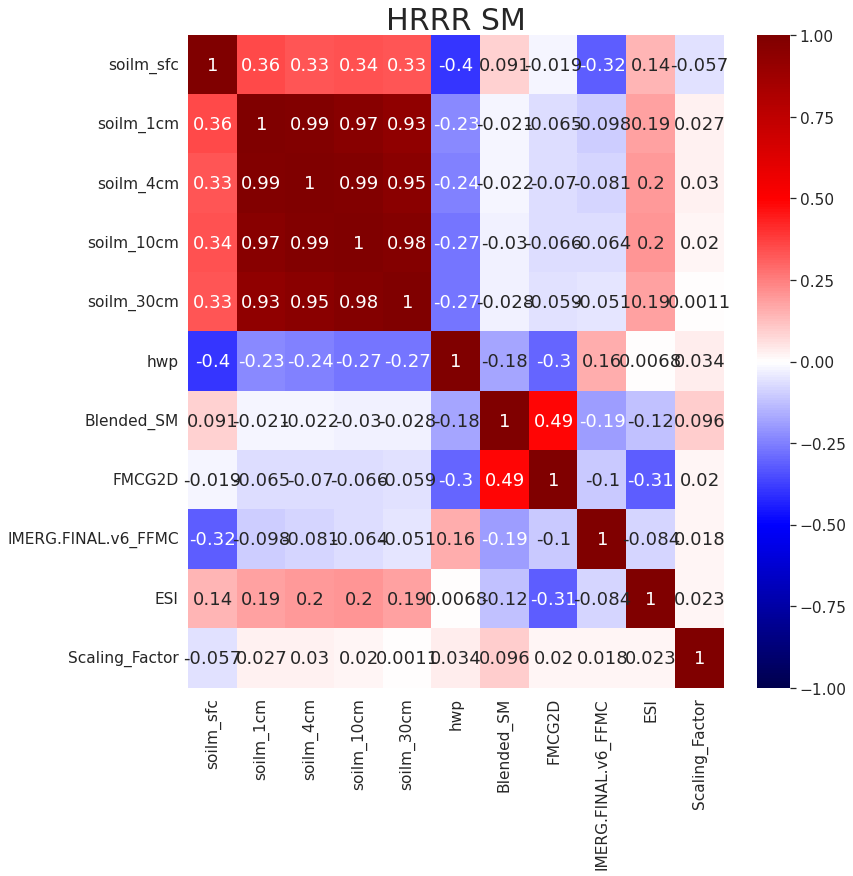

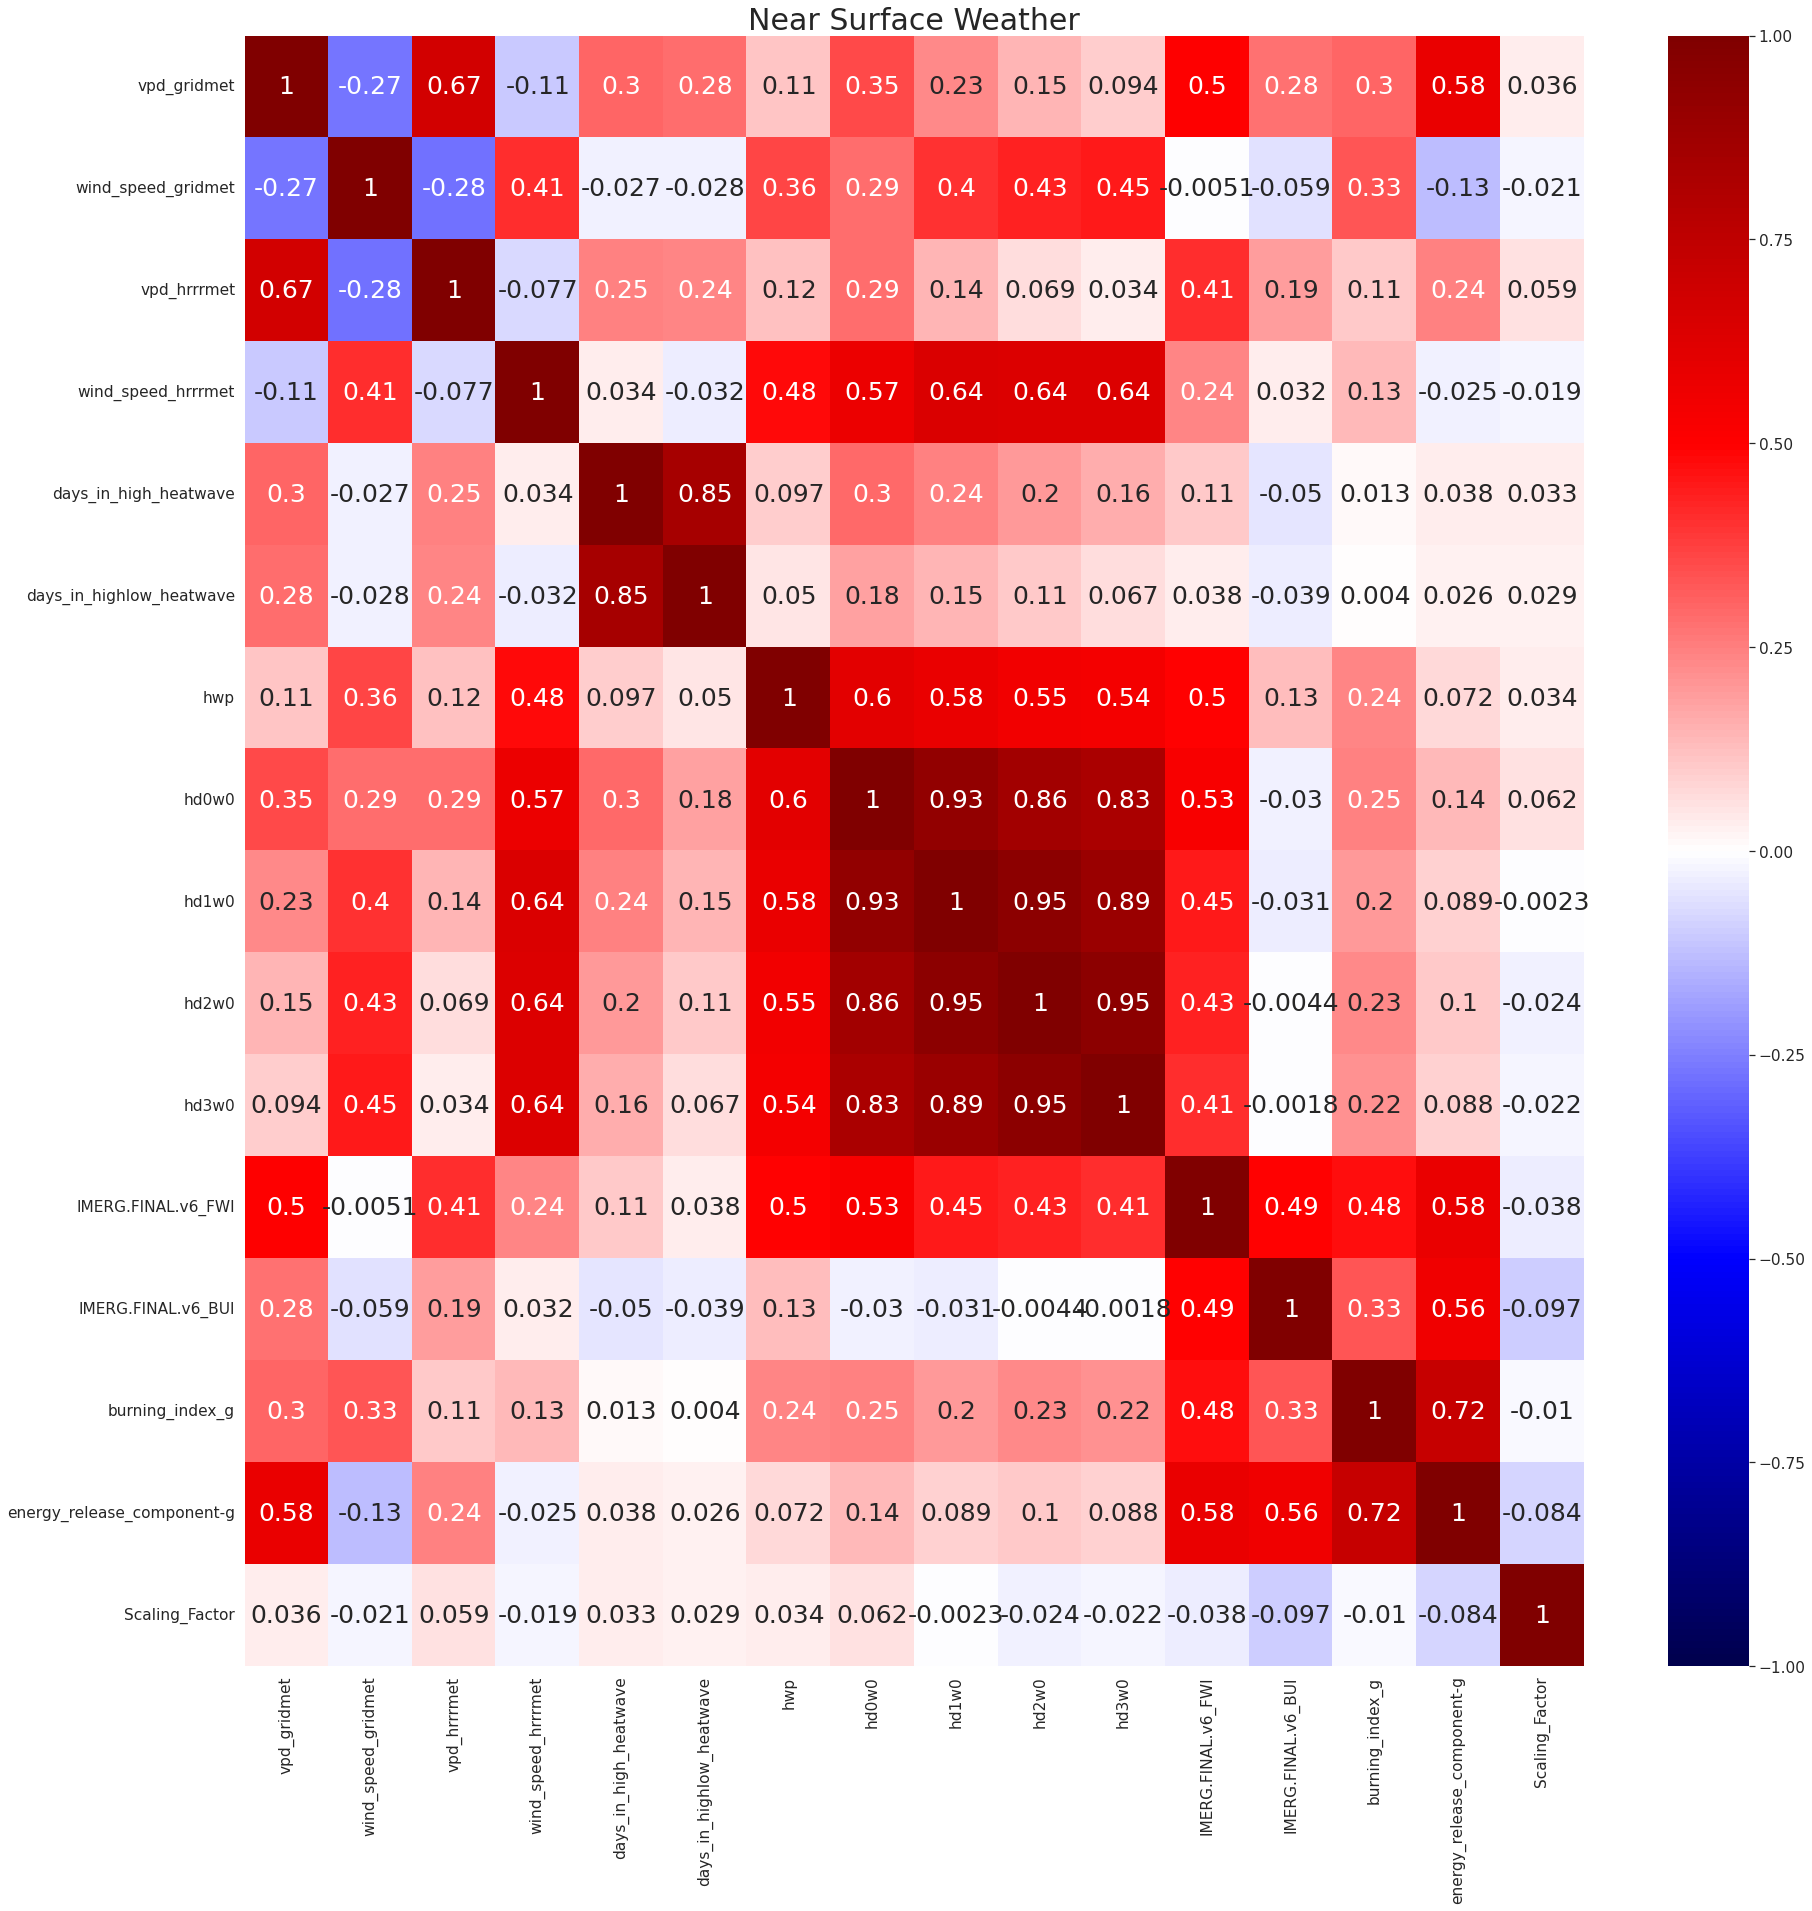

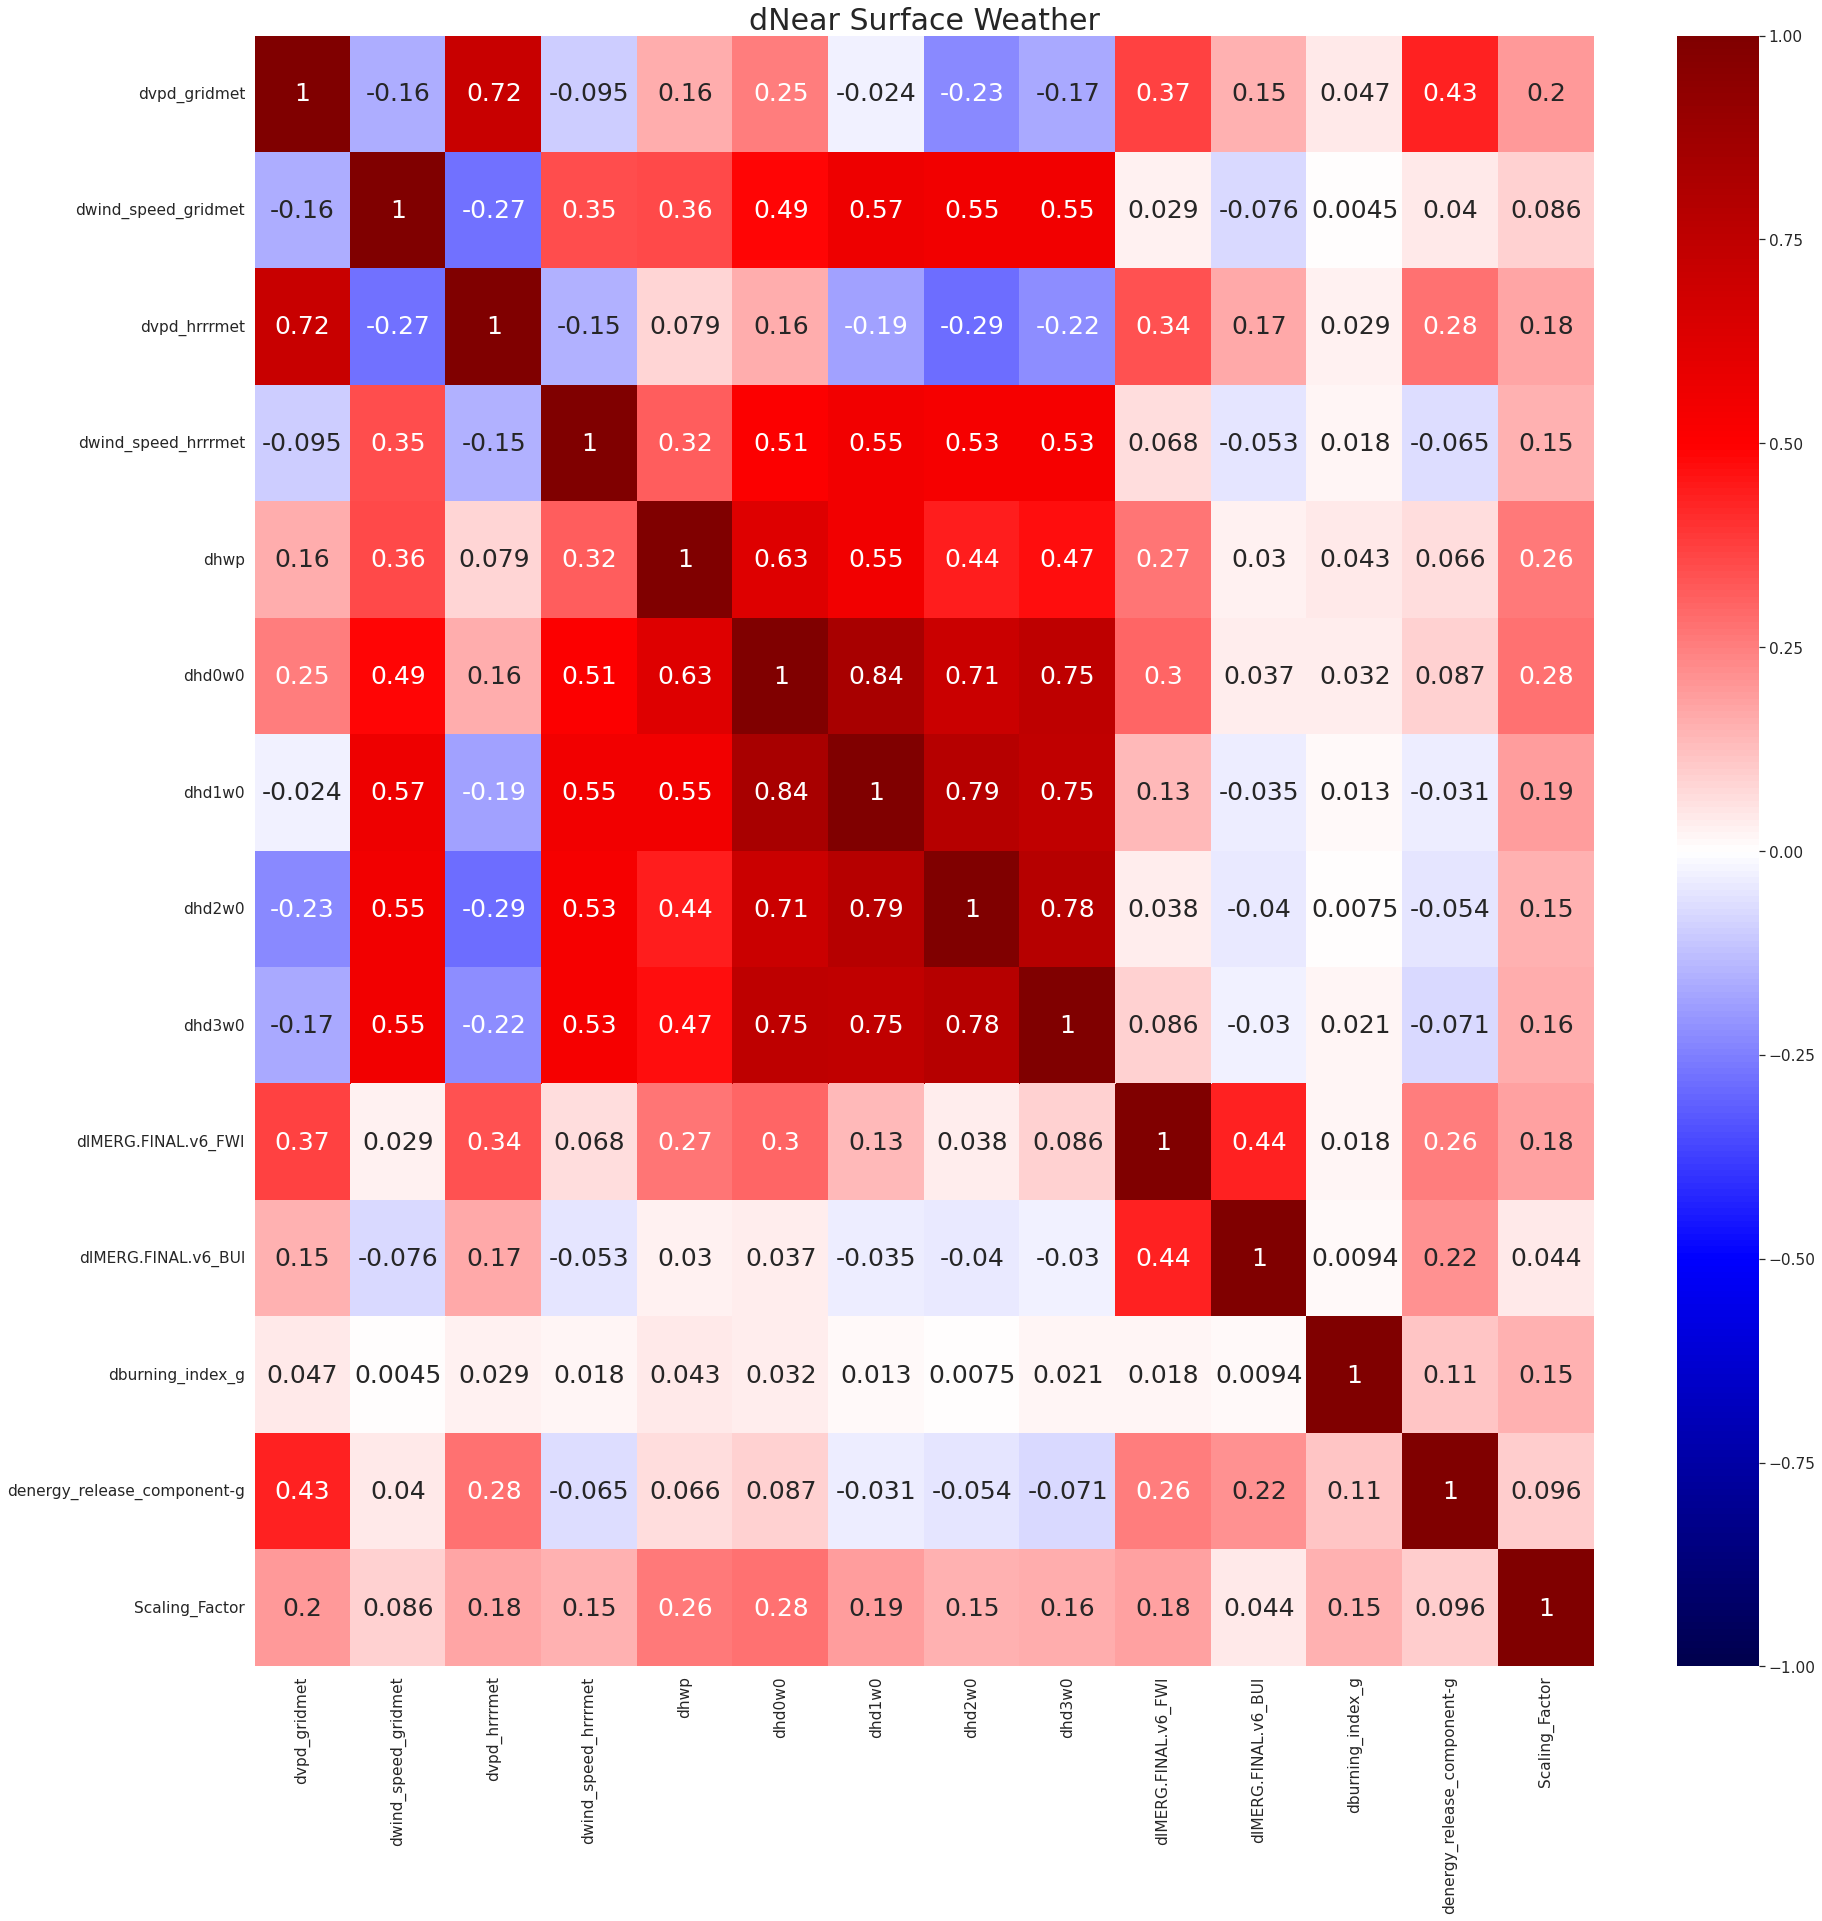

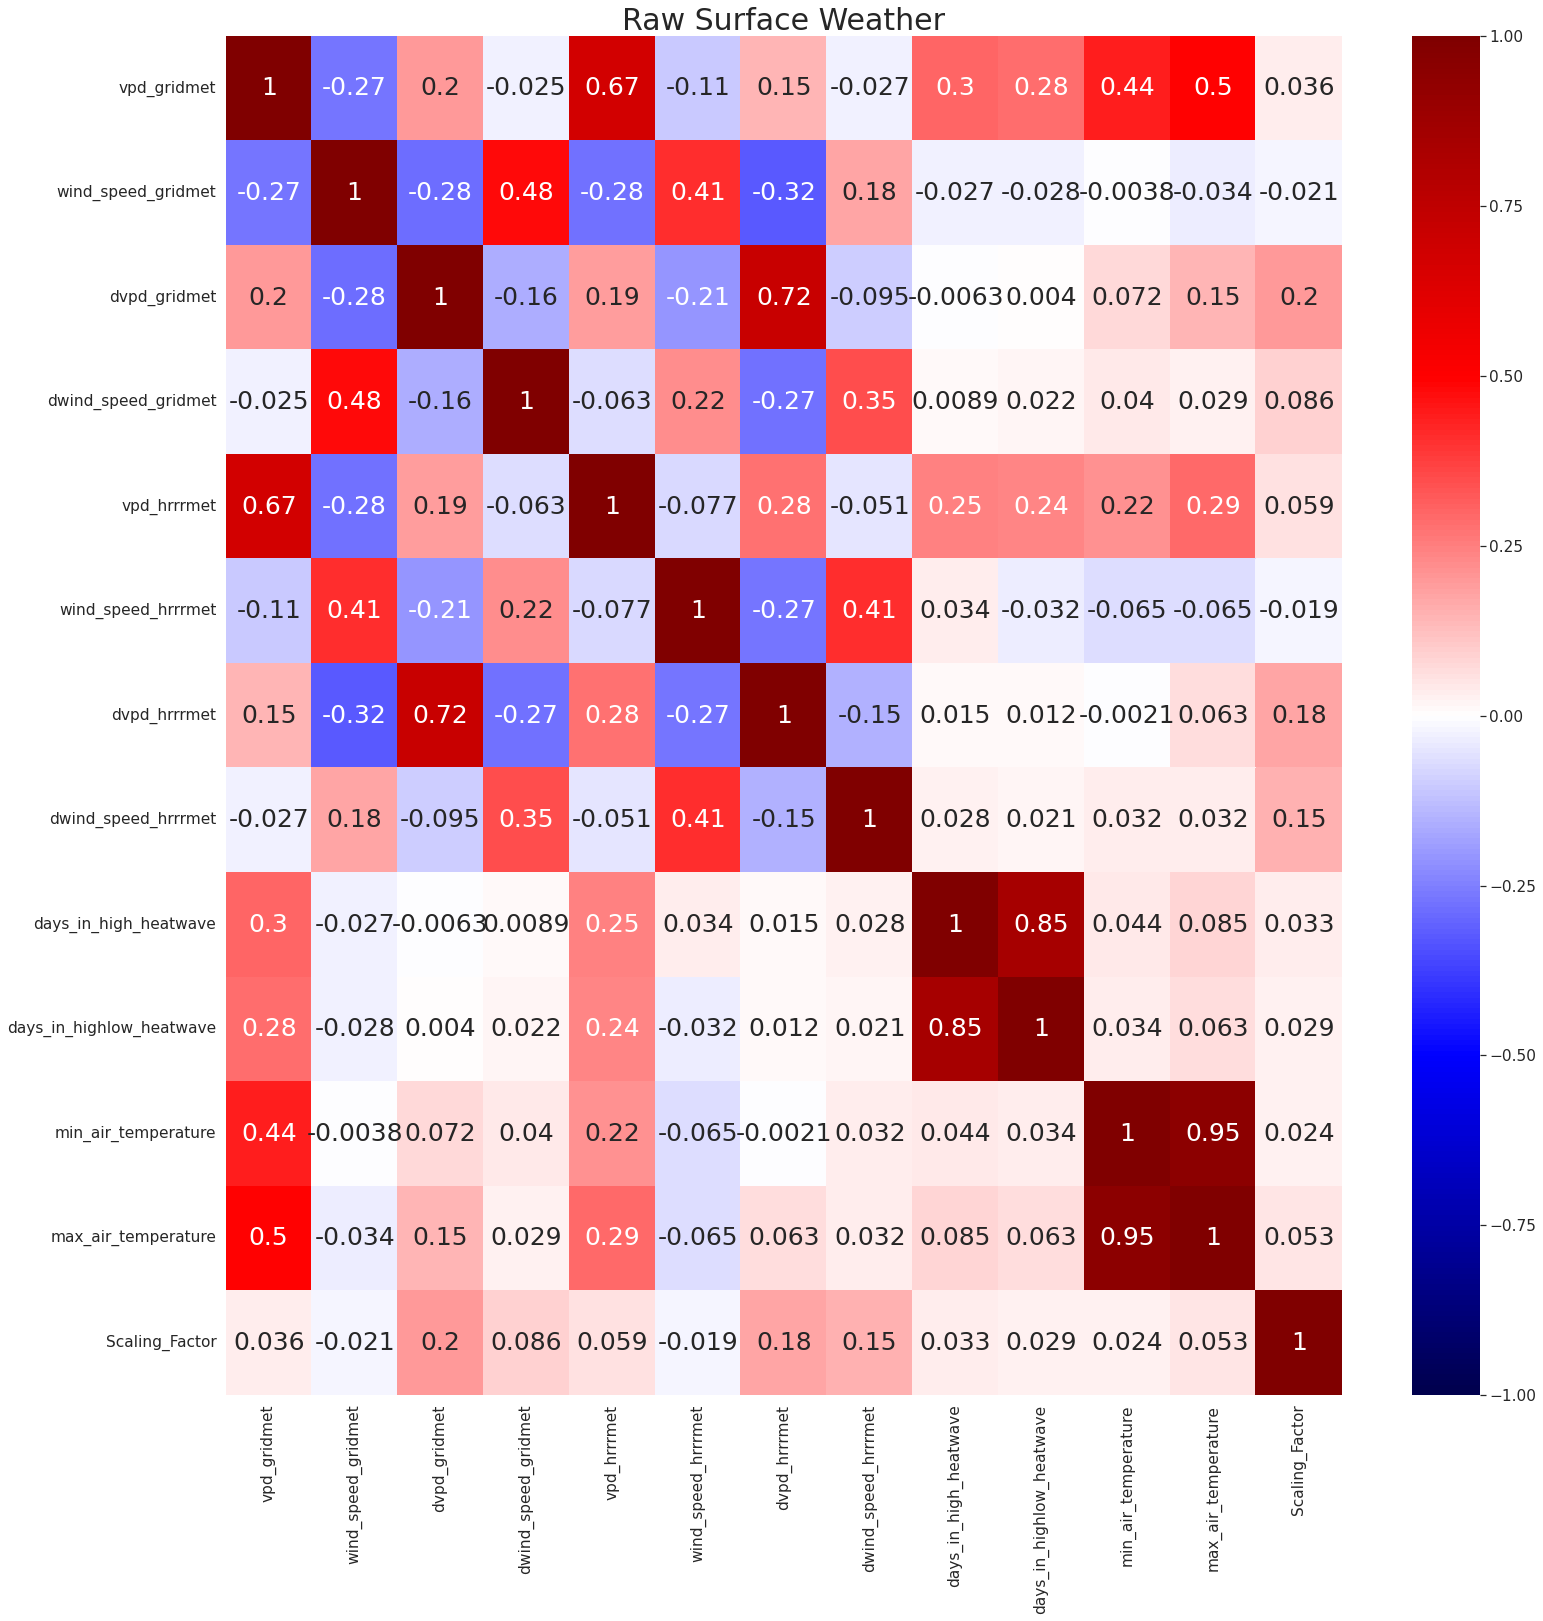

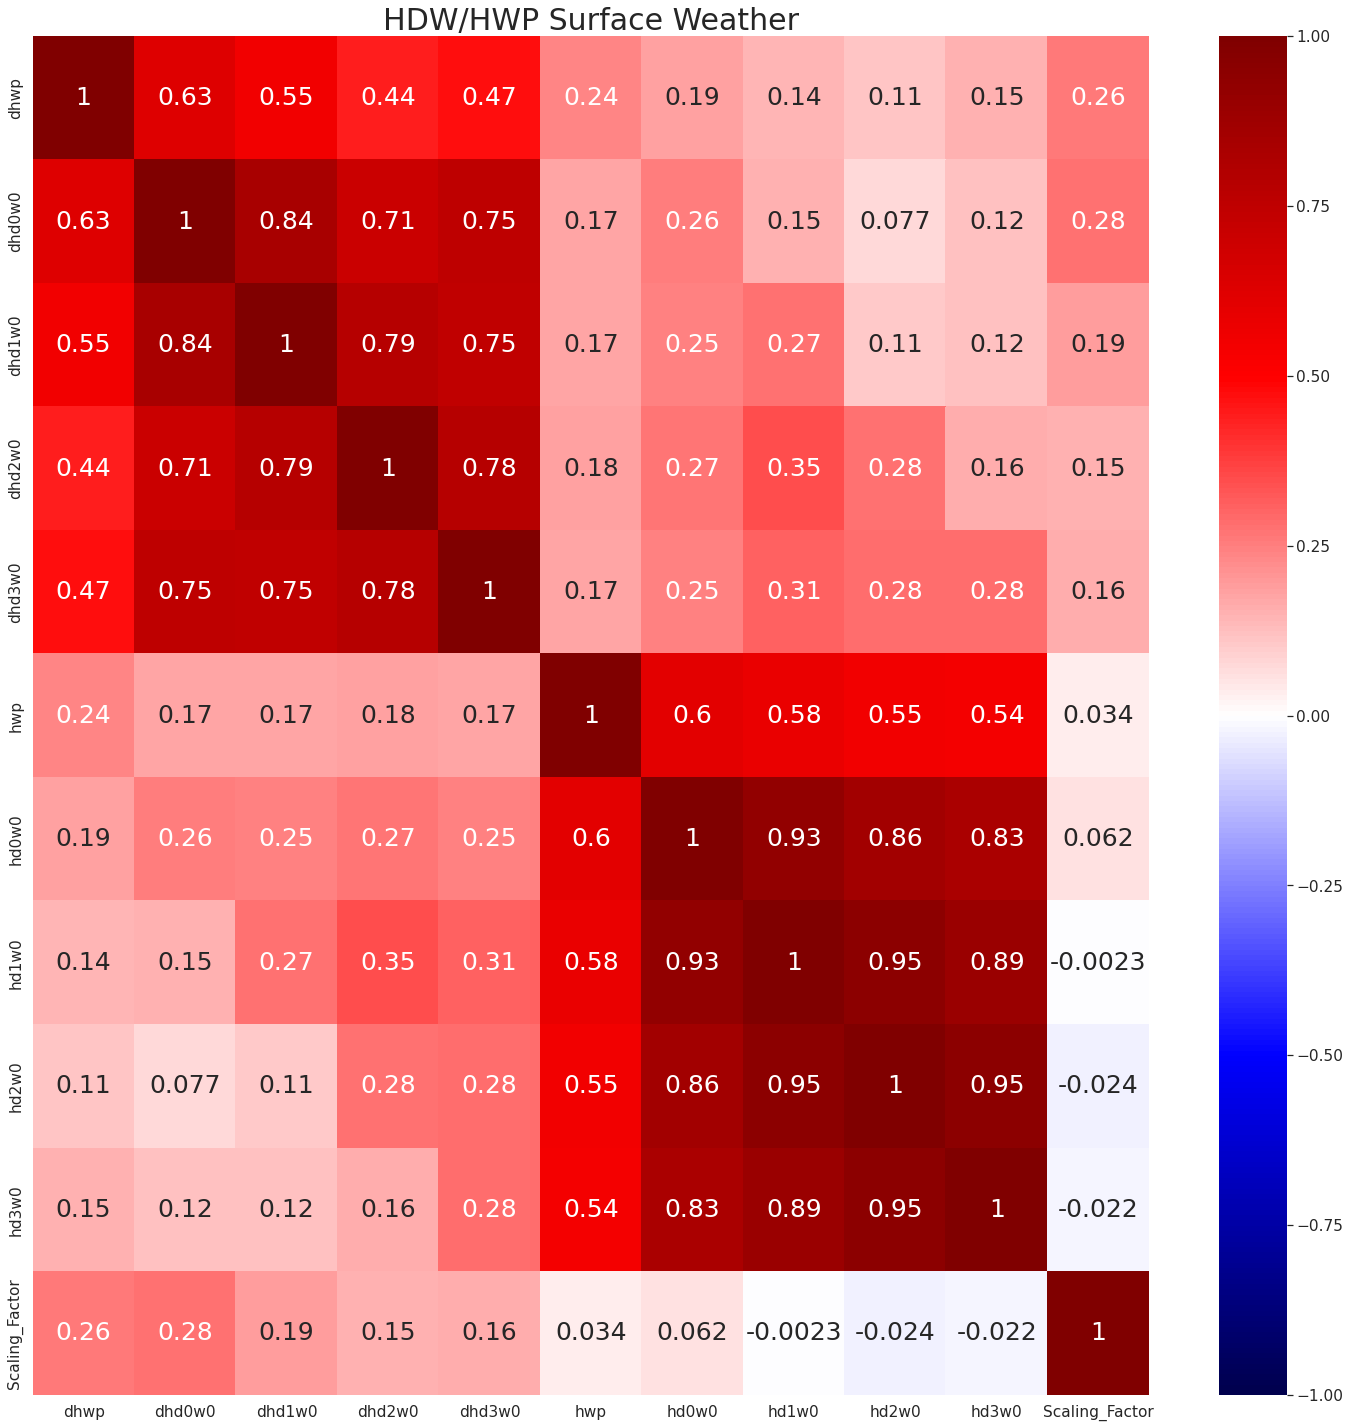

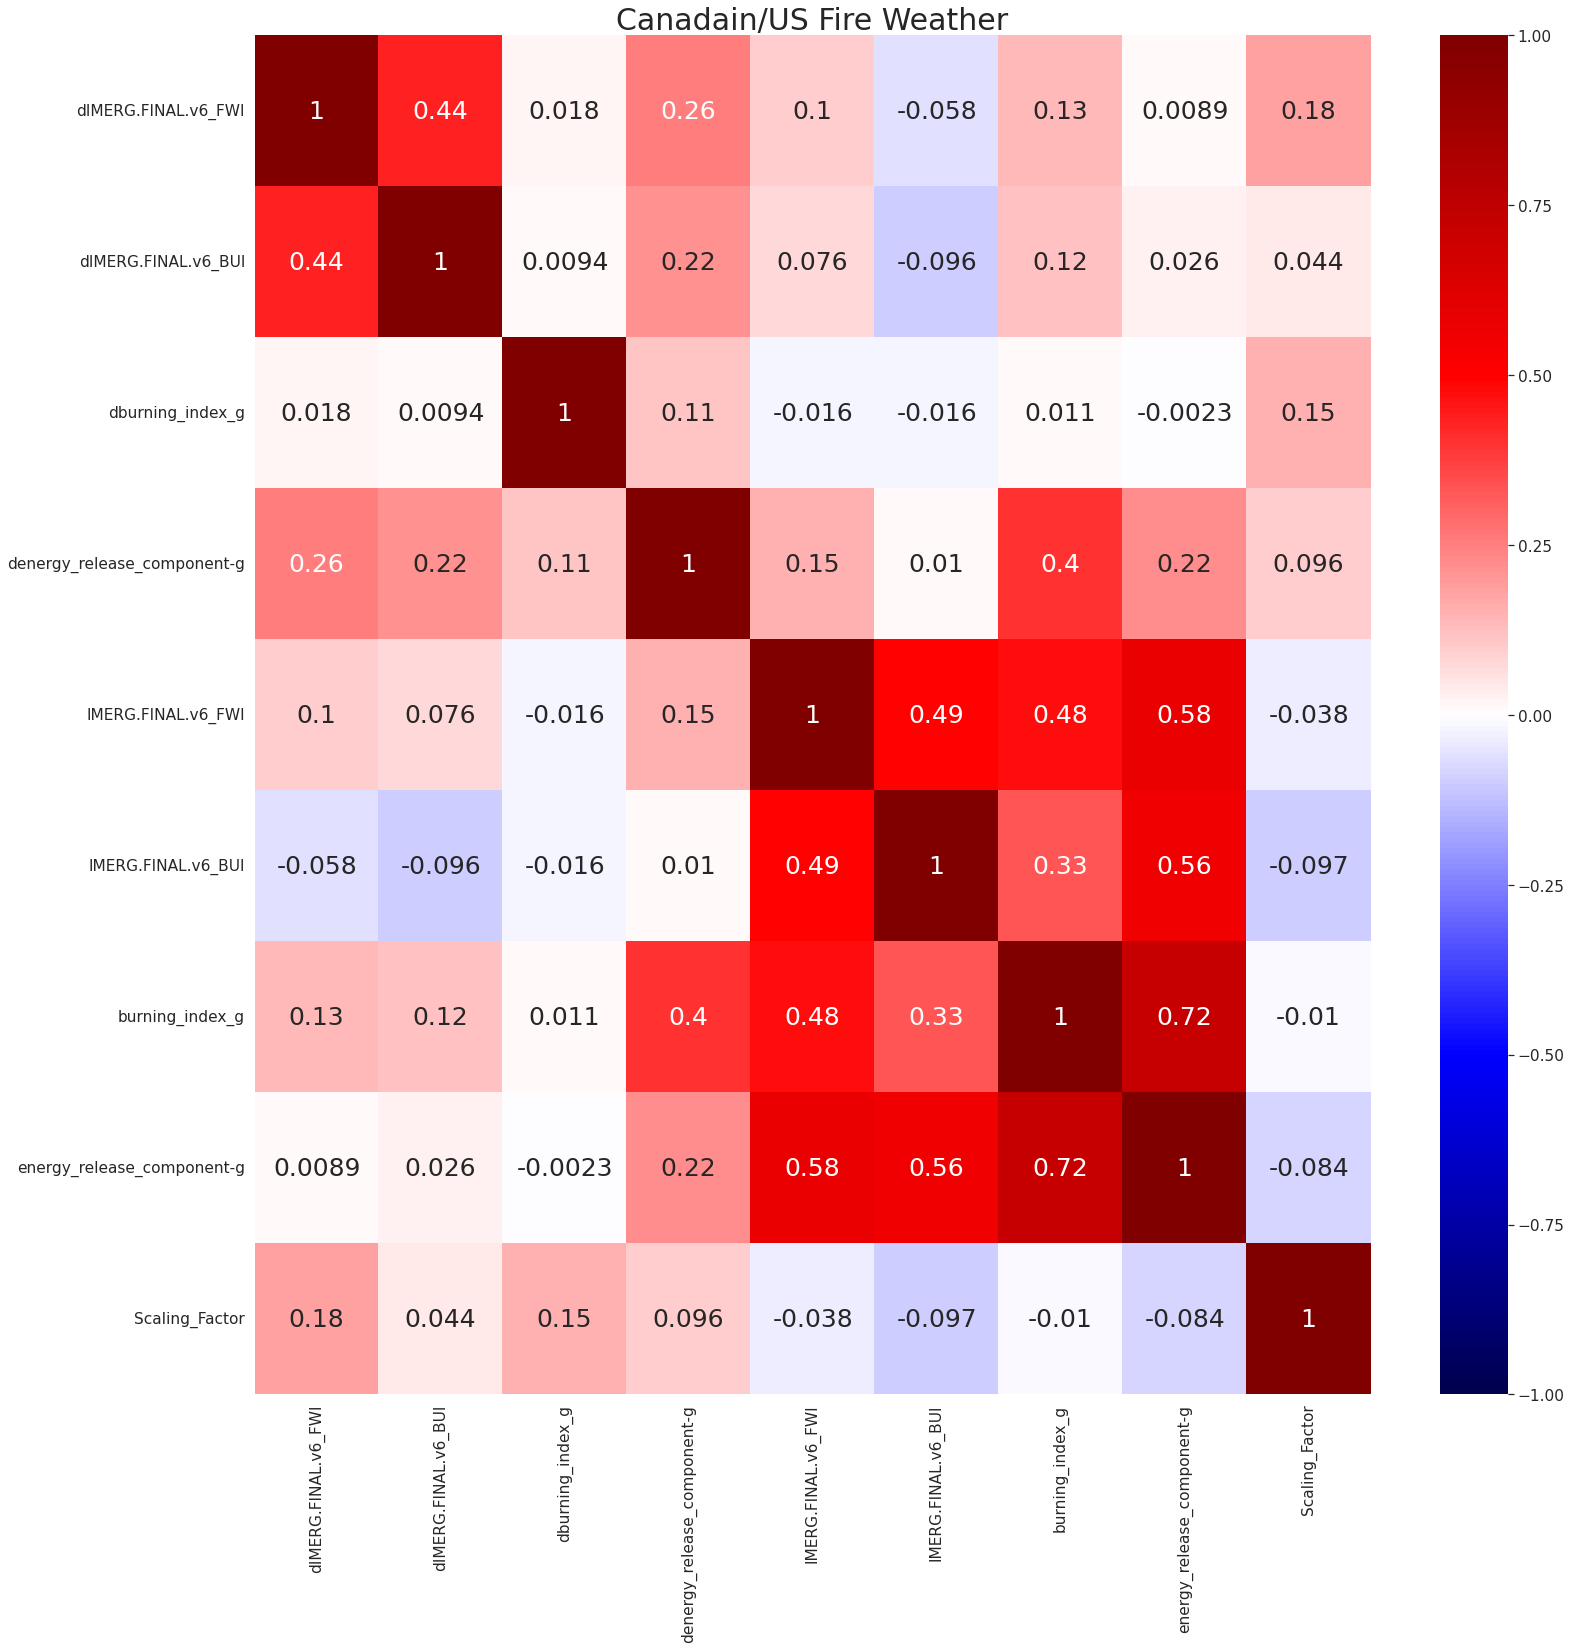

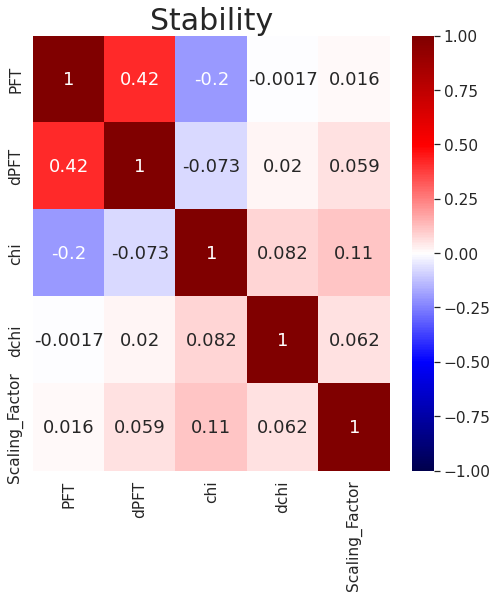

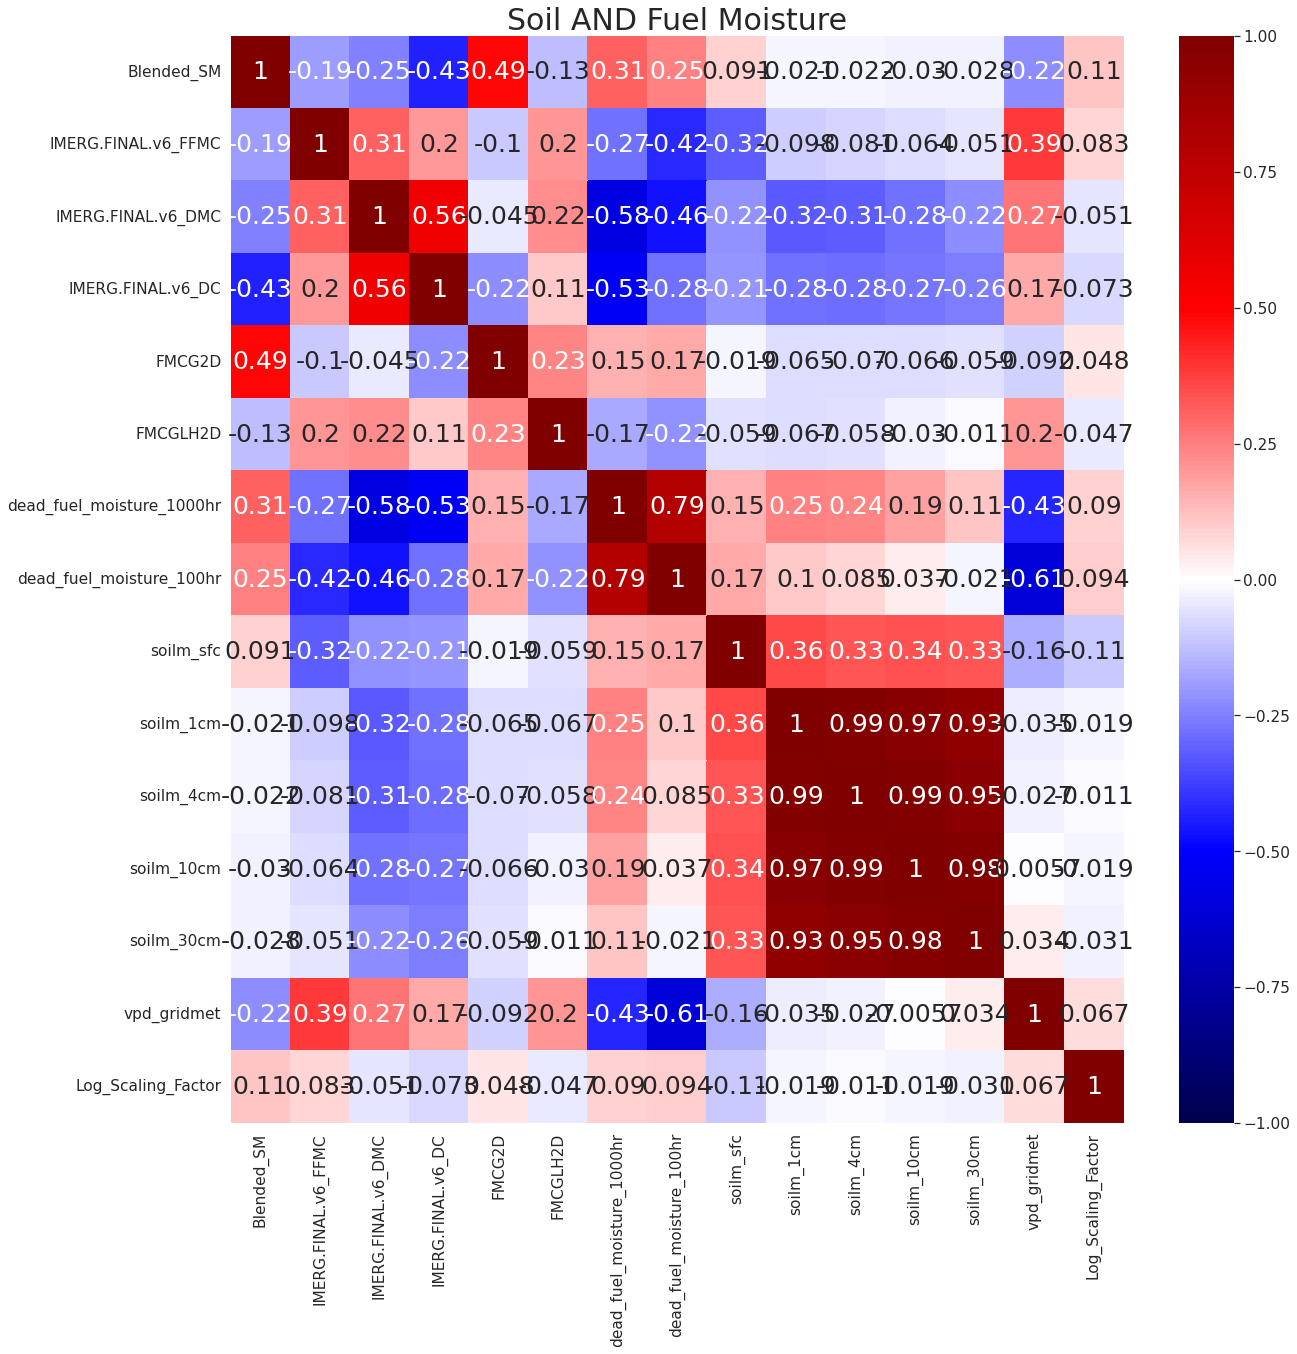

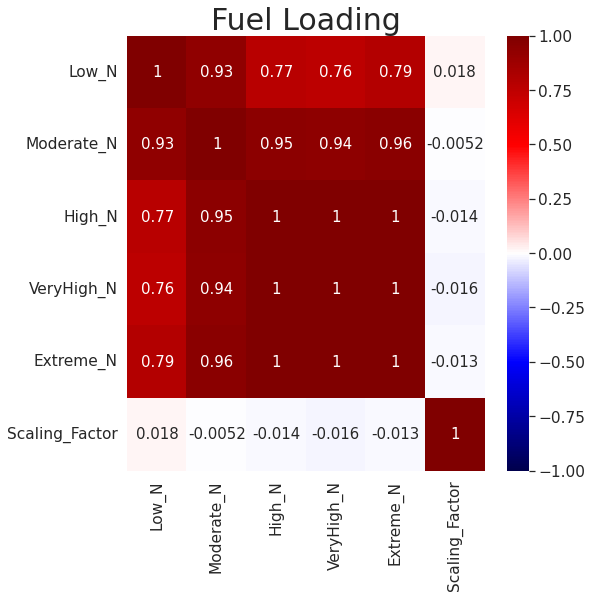

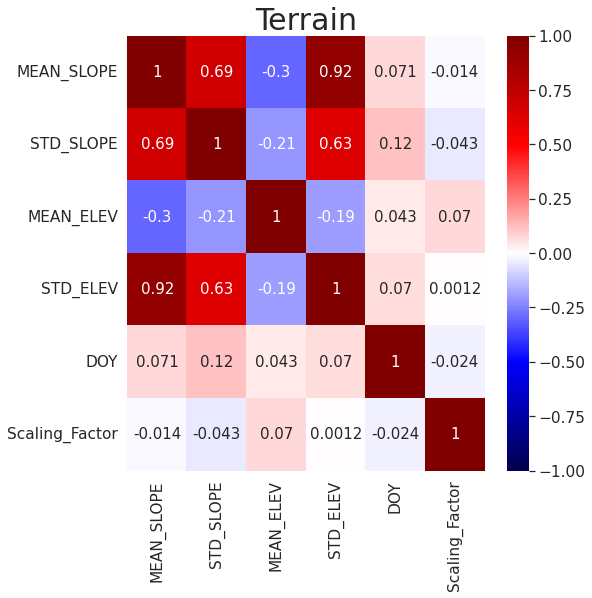

KeyError: 'total_personnel'

In [29]:
plot_correlations(data_train_1921[['soilm_sfc', 'soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm','hwp',
                                   'Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC','ESI',
                                   'Scaling_Factor']],
                  'HRRR SM','pearson', 18, (12,12))

plot_correlations(data_train_1921[["vpd_gridmet","wind_speed_gridmet","vpd_hrrrmet","wind_speed_hrrrmet",
                                   "days_in_high_heatwave","days_in_highlow_heatwave",
                                   "hwp","hd0w0", "hd1w0", "hd2w0", "hd3w0",
    "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI","burning_index_g","energy_release_component-g",
                                   'Scaling_Factor']],'Near Surface Weather','pearson', 25, (30,30))
plot_correlations(data_train_1921[["dvpd_gridmet","dwind_speed_gridmet","dvpd_hrrrmet","dwind_speed_hrrrmet",
                                   "dhwp","dhd0w0", "dhd1w0", "dhd2w0", "dhd3w0",
    "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI","dburning_index_g","denergy_release_component-g",
                                   'Scaling_Factor']],'dNear Surface Weather','pearson', 25, (30,30))


plot_correlations(data_train_1921[["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet",
 "vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet",
 "days_in_high_heatwave","days_in_highlow_heatwave", "min_air_temperature", "max_air_temperature", 
                                   'Scaling_Factor']],'Raw Surface Weather','pearson', 25, (25,25))

plot_correlations(data_train_1921[["dhwp",
 "dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hwp","hd0w0", "hd1w0", "hd2w0", "hd3w0",
                    'Scaling_Factor']],
                  'HDW/HWP Surface Weather','pearson', 25, (25,25))

plot_correlations(data_train_1921[[
"dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "dburning_index_g","denergy_release_component-g",
    "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI","burning_index_g","energy_release_component-g",
    'Scaling_Factor']],
                  'Canadain/US Fire Weather','pearson', 25, (25,25))

plot_correlations(data_train_1921[["PFT", "dPFT", 'chi', 'dchi','Scaling_Factor']],
                  'Stability','pearson', 18, (8,8))

plot_correlations(data_train_1921[["Blended_SM", "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   "FMCG2D", "FMCGLH2D", "dead_fuel_moisture_1000hr","dead_fuel_moisture_100hr",
                                   'soilm_sfc', 'soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm',
                                  'vpd_gridmet',"Log_Scaling_Factor"]],
                  'Soil AND Fuel Moisture','pearson', 25, (20,20))

plot_correlations(data_train_1921[features_by_category['loading'] +['Scaling_Factor']],
                  'Fuel Loading','pearson', 15,(8,8))

plot_correlations(data_train_1921[features_by_category['terrain_slope']+\
                                  features_by_category['terrain_elevation']+['DOY','Scaling_Factor']],
                  'Terrain','pearson', 15, (8,8))

plot_correlations(data_train_1921[features_by_category['containment']+\
                                  features_by_category['total_personnel']+\
                                  features_by_category['split_personnel']+\
                                  features_by_category['split_quantity']+\
                                  features_by_category['pop']+\
                                  features_by_category['structures']+['Scaling_Factor']],
                  'Human','pearson', 23, (30,30))



## Time Series plots of the different features with FRE

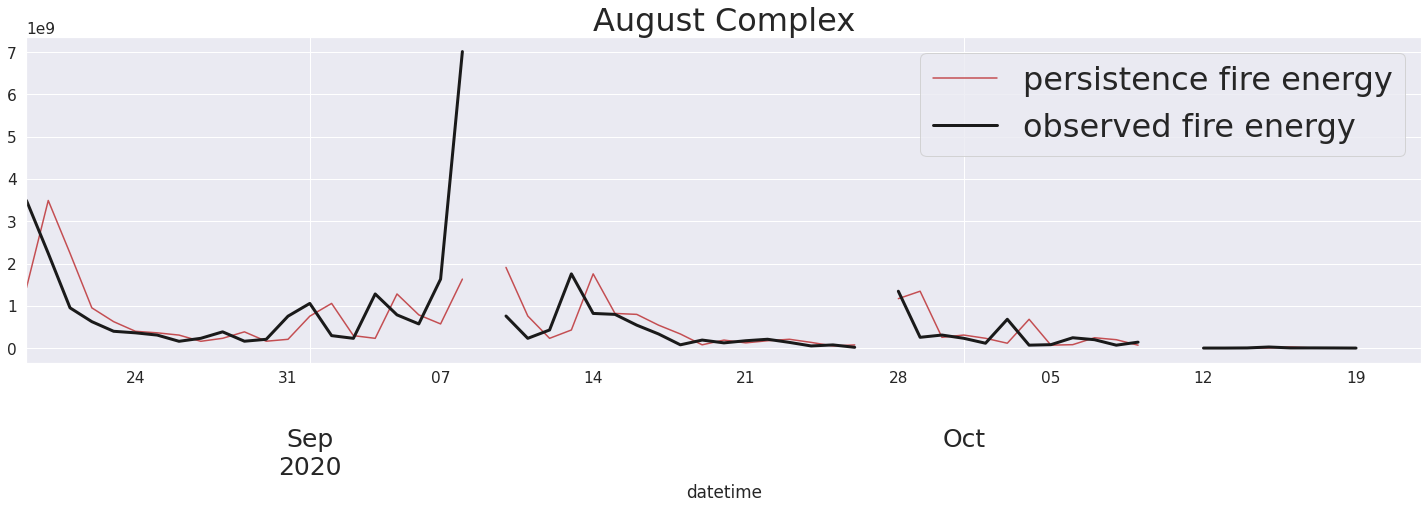

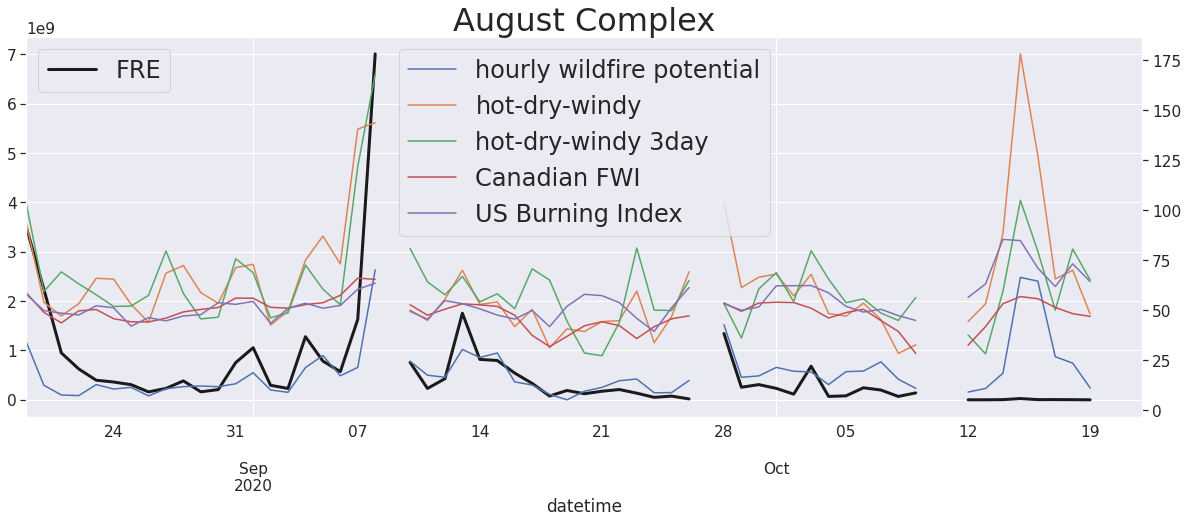

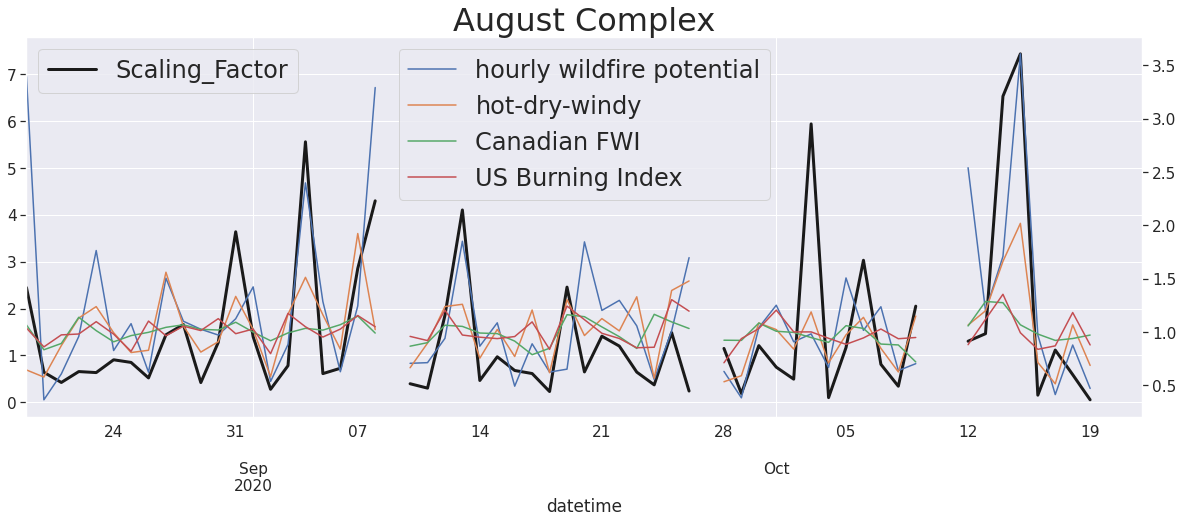

In [20]:
fire_names = ['August Complex']#,'Williams Flats', 'Dixie']

fire = data_test[data_test['irwinID']==test_irwin_ids[0]]
fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    
#print(len(features_plot_timeseries)) 

fig, ax = plt.subplots(figsize=(25, 6))
fire_plot.plot(y=['FRE_1'],label=['persistence fire energy'], style='r-',alpha=1, ax=ax)
fire_plot.plot(y=['FRE'],label=['observed fire energy'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=32)
plt.xticks(fontsize=25)
plt.title(fire_names[0],fontsize=32)
plt.show()

fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
fire_plot.plot(y=['hwp','hd0w0','hd3w0','IMERG.FINAL.v6_FWI','burning_index_g'], 
               label=['hourly wildfire potential', 'hot-dry-windy','hot-dry-windy 3day','Canadian FWI', 'US Burning Index'],alpha=1, ax=ax2)
fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title(fire_names[0], fontsize=32)
plt.show()

fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
fire_plot.plot(y=['dhwp','dhd0w0','dIMERG.FINAL.v6_FWI', 'dburning_index_g'], 
               label=['hourly wildfire potential', 'hot-dry-windy','Canadian FWI', 'US Burning Index'],alpha=1, ax=ax2)
fire_plot.plot(y=['Scaling_Factor'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title(fire_names[0], fontsize=32)
plt.show()

In [18]:
data_train_1921['obs_cat'] = pd.cut(data_train_1921['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])
print(len(data_train_1921))
print(str(len(data_train_1921[data_train_1921['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='increase'])) + ' increases')

1296
466 decreases
450 slight changes
380 increases


1472
1472
1472
DOING PERSISTENCE


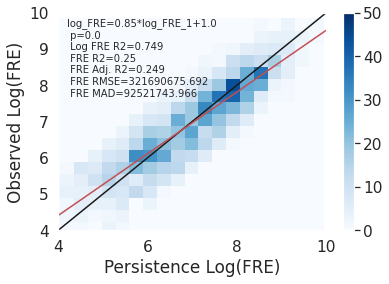

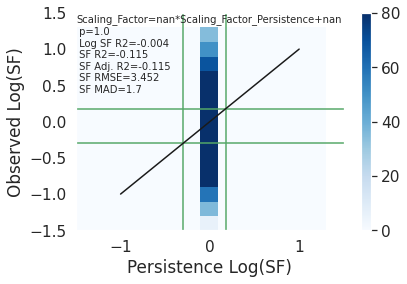

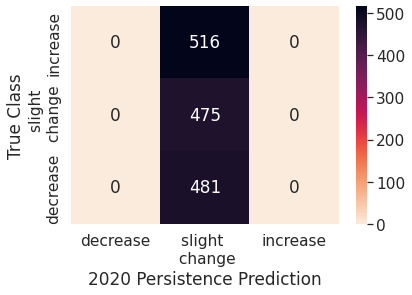

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       481
    increase       0.00      0.00      0.00       516
   no_change       0.32      1.00      0.49       475

    accuracy                           0.32      1472
   macro avg       0.11      0.33      0.16      1472
weighted avg       0.10      0.32      0.16      1472

persistence


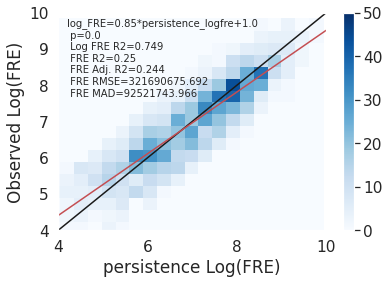

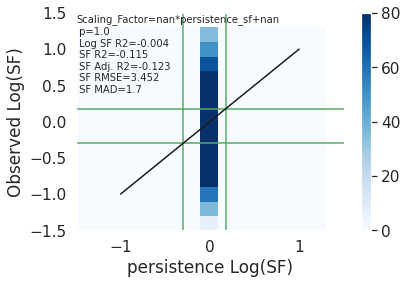

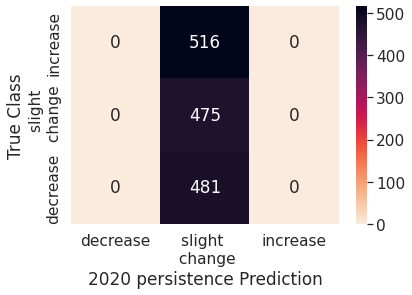

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       481
    increase       0.00      0.00      0.00       516
   no_change       0.32      1.00      0.49       475

    accuracy                           0.32      1472
   macro avg       0.11      0.33      0.16      1472
weighted avg       0.10      0.32      0.16      1472

dwind_speed_gridmet


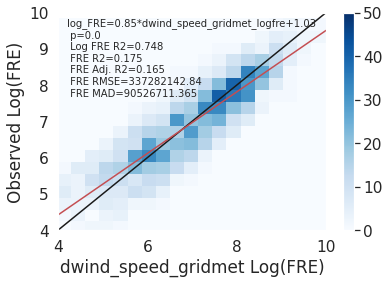

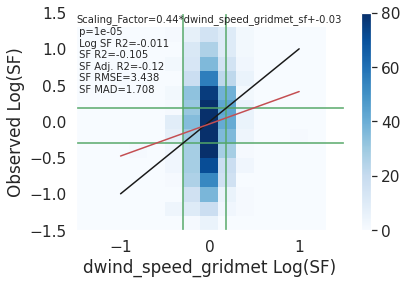

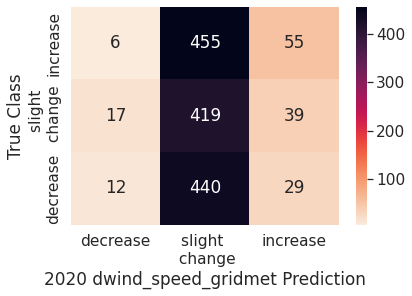

              precision    recall  f1-score   support

    decrease       0.34      0.02      0.05       481
    increase       0.45      0.11      0.17       516
   no_change       0.32      0.88      0.47       475

    accuracy                           0.33      1472
   macro avg       0.37      0.34      0.23      1472
weighted avg       0.37      0.33      0.23      1472

dvpd_gridmet


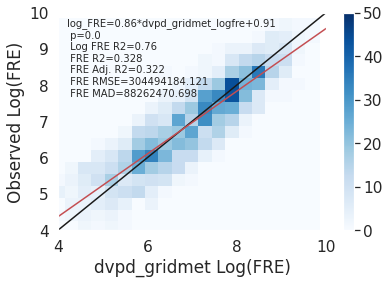

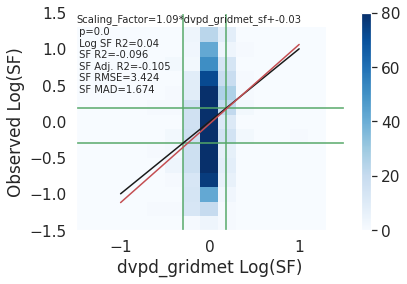

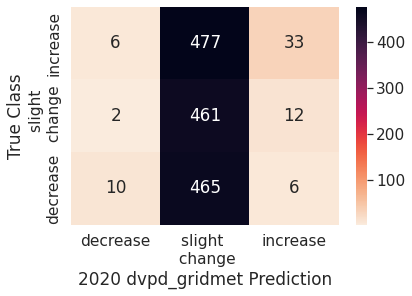

              precision    recall  f1-score   support

    decrease       0.56      0.02      0.04       481
    increase       0.65      0.06      0.12       516
   no_change       0.33      0.97      0.49       475

    accuracy                           0.34      1472
   macro avg       0.51      0.35      0.22      1472
weighted avg       0.51      0.34      0.21      1472

dwind_speed_hrrrmet


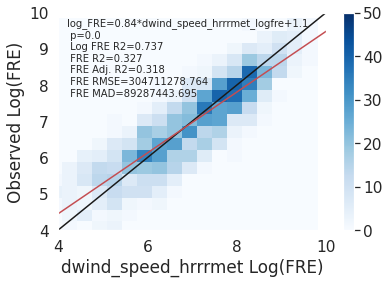

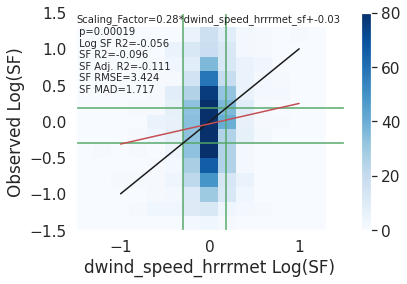

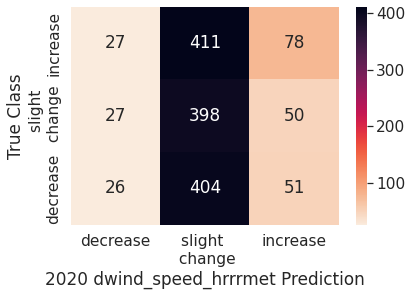

              precision    recall  f1-score   support

    decrease       0.33      0.05      0.09       481
    increase       0.44      0.15      0.22       516
   no_change       0.33      0.84      0.47       475

    accuracy                           0.34      1472
   macro avg       0.36      0.35      0.26      1472
weighted avg       0.36      0.34      0.26      1472

dvpd_hrrrmet


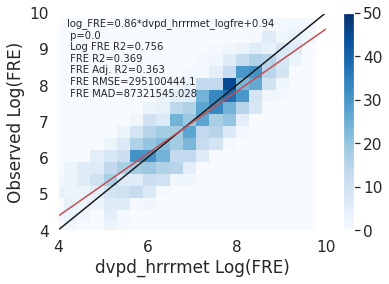

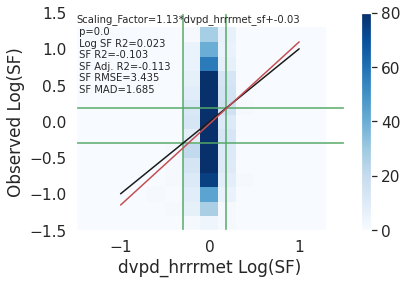

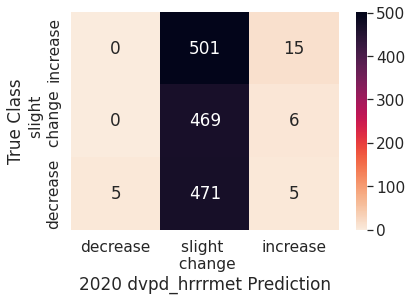

              precision    recall  f1-score   support

    decrease       1.00      0.01      0.02       481
    increase       0.58      0.03      0.06       516
   no_change       0.33      0.99      0.49       475

    accuracy                           0.33      1472
   macro avg       0.63      0.34      0.19      1472
weighted avg       0.63      0.33      0.18      1472

dmax_air_temperature


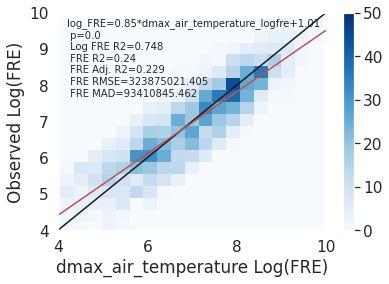

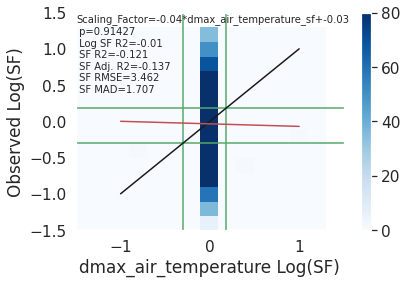

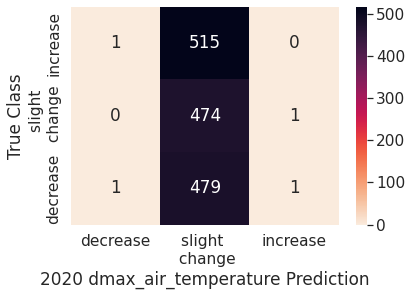

              precision    recall  f1-score   support

    decrease       0.50      0.00      0.00       481
    increase       0.00      0.00      0.00       516
   no_change       0.32      1.00      0.49       475

    accuracy                           0.32      1472
   macro avg       0.27      0.33      0.16      1472
weighted avg       0.27      0.32      0.16      1472

dhwp


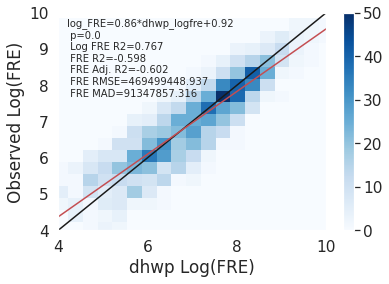

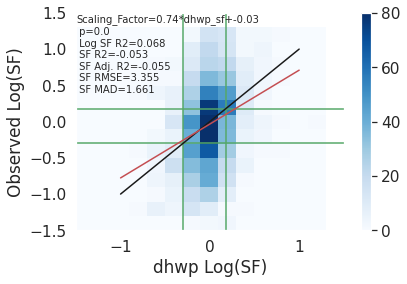

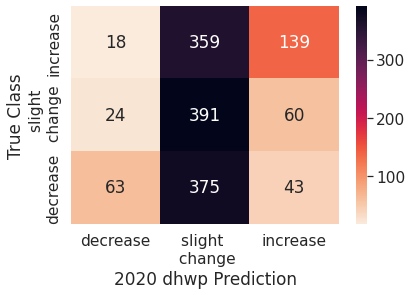

              precision    recall  f1-score   support

    decrease       0.60      0.13      0.22       481
    increase       0.57      0.27      0.37       516
   no_change       0.35      0.82      0.49       475

    accuracy                           0.40      1472
   macro avg       0.51      0.41      0.36      1472
weighted avg       0.51      0.40      0.36      1472

dhd0w0


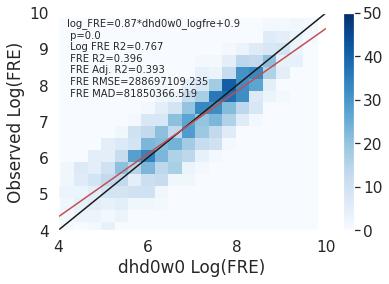

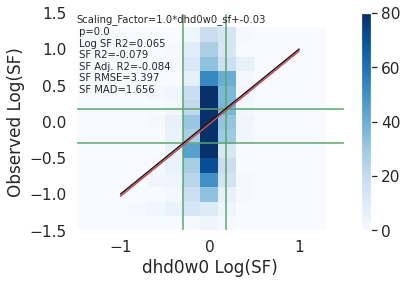

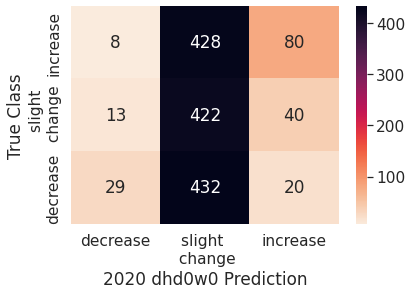

              precision    recall  f1-score   support

    decrease       0.58      0.06      0.11       481
    increase       0.57      0.16      0.24       516
   no_change       0.33      0.89      0.48       475

    accuracy                           0.36      1472
   macro avg       0.49      0.37      0.28      1472
weighted avg       0.50      0.36      0.28      1472

dhd1w0


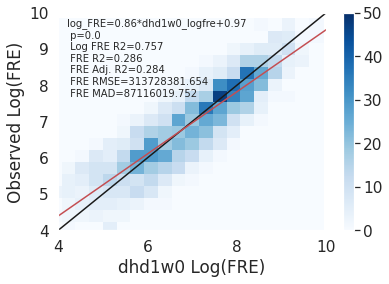

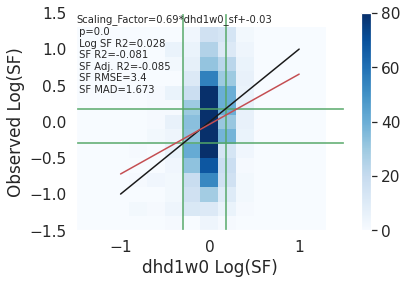

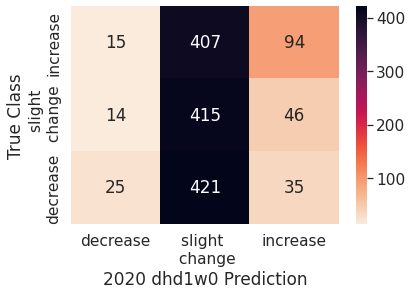

              precision    recall  f1-score   support

    decrease       0.46      0.05      0.09       481
    increase       0.54      0.18      0.27       516
   no_change       0.33      0.87      0.48       475

    accuracy                           0.36      1472
   macro avg       0.44      0.37      0.28      1472
weighted avg       0.45      0.36      0.28      1472

dhd2w0


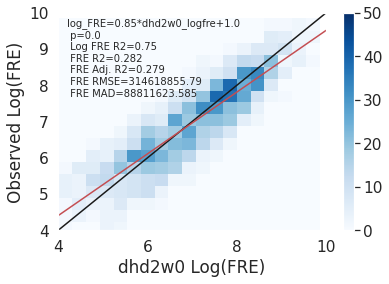

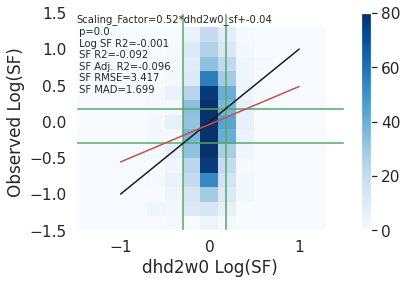

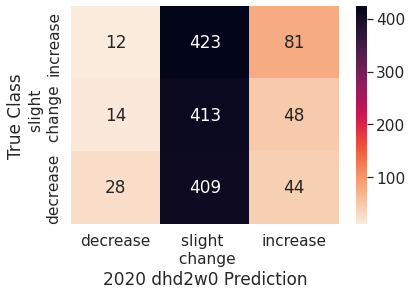

              precision    recall  f1-score   support

    decrease       0.52      0.06      0.10       481
    increase       0.47      0.16      0.24       516
   no_change       0.33      0.87      0.48       475

    accuracy                           0.35      1472
   macro avg       0.44      0.36      0.27      1472
weighted avg       0.44      0.35      0.27      1472

dhd3w0


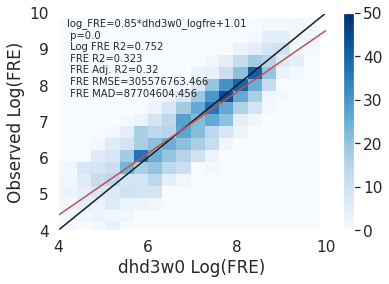

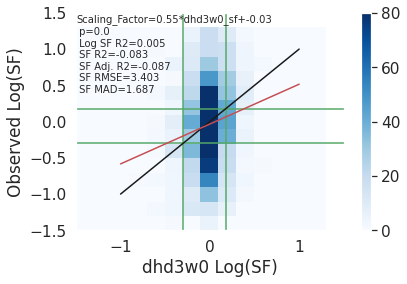

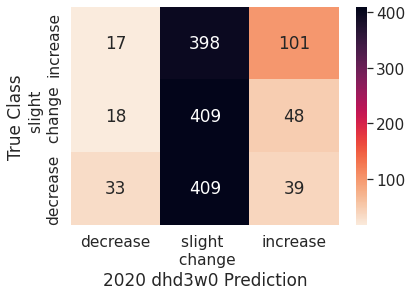

              precision    recall  f1-score   support

    decrease       0.49      0.07      0.12       481
    increase       0.54      0.20      0.29       516
   no_change       0.34      0.86      0.48       475

    accuracy                           0.37      1472
   macro avg       0.45      0.38      0.30      1472
weighted avg       0.46      0.37      0.30      1472

dIMERG.FINAL.v6_FWI


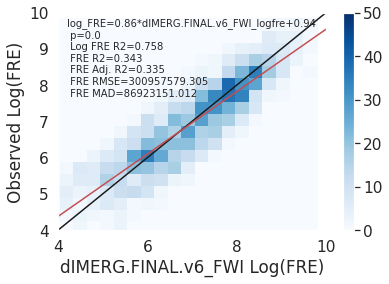

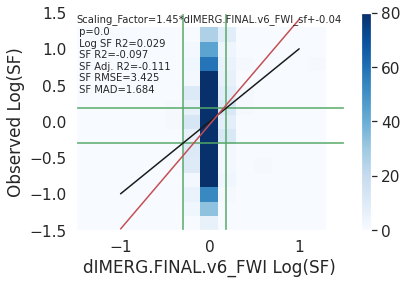

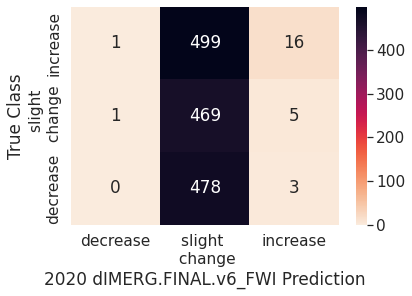

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       481
    increase       0.67      0.03      0.06       516
   no_change       0.32      0.99      0.49       475

    accuracy                           0.33      1472
   macro avg       0.33      0.34      0.18      1472
weighted avg       0.34      0.33      0.18      1472

dIMERG.FINAL.v6_BUI


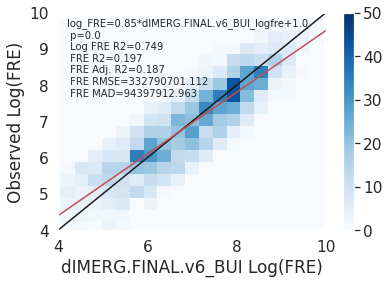

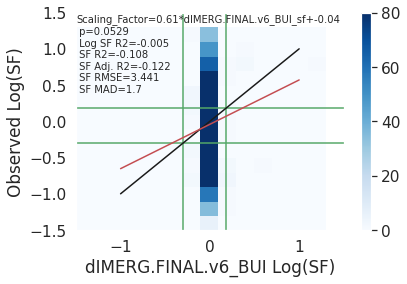

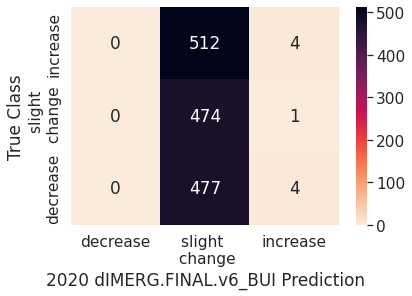

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       481
    increase       0.44      0.01      0.02       516
   no_change       0.32      1.00      0.49       475

    accuracy                           0.32      1472
   macro avg       0.26      0.34      0.17      1472
weighted avg       0.26      0.32      0.16      1472

dburning_index_g


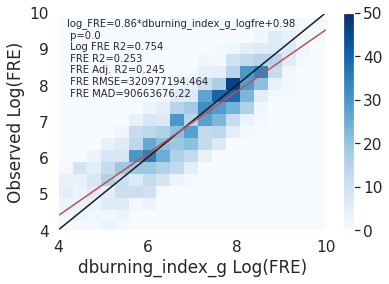

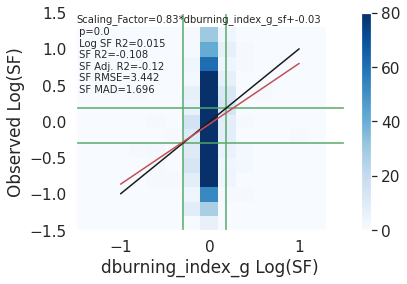

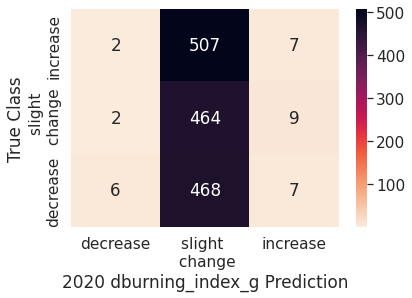

              precision    recall  f1-score   support

    decrease       0.60      0.01      0.02       481
    increase       0.30      0.01      0.03       516
   no_change       0.32      0.98      0.48       475

    accuracy                           0.32      1472
   macro avg       0.41      0.33      0.18      1472
weighted avg       0.41      0.32      0.17      1472

denergy_release_component-g


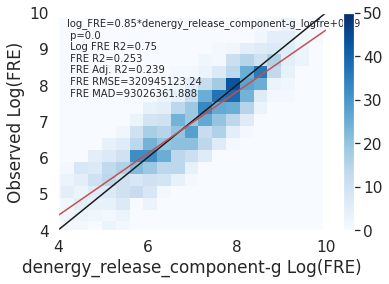

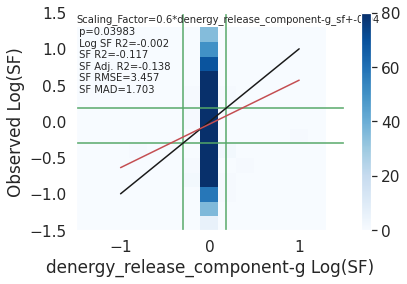

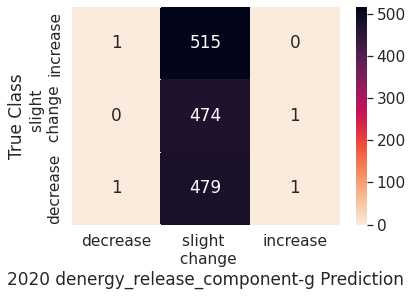

              precision    recall  f1-score   support

    decrease       0.50      0.00      0.00       481
    increase       0.00      0.00      0.00       516
   no_change       0.32      1.00      0.49       475

    accuracy                           0.32      1472
   macro avg       0.27      0.33      0.16      1472
weighted avg       0.27      0.32      0.16      1472



In [21]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['persistence','dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                  'dmax_air_temperature',
                  'dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI','dIMERG.FINAL.v6_BUI',
                  'dburning_index_g', 'denergy_release_component-g'] 

scaled_methods_plot =['dwind_speed_hrrrmet','dvpd_gridmet', 'dvpd_hrrrmet','dhwp','dhd1w0','dIMERG.FINAL.v6_FWI','dburning_index_g']
thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

df_error_metrics_scaled = pd.DataFrame(index=scaled_methods, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#do the plottint
#drop the nans, these will show up in the scaled methods

data_test_2020= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]
print(len(data_test_2020))

#do the calculations
for ii in range(len(scaled_methods)):
    #print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfre'] = np.log10(data_test_2020[scaled_methods[ii]+'_fre'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
#print(data_test_2020.columns.values)    
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))


#get the error metrics
for ii in range(len(scaled_methods)):
    if scaled_methods[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', scaled_methods[ii]+'_fre',[scaled_methods[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', scaled_methods[ii]+'_logfre',[scaled_methods[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', scaled_methods[ii]+'_sf',[scaled_methods[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', scaled_methods[ii]+'_logsf',[scaled_methods[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020[scaled_methods[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_scaled.loc[scaled_methods[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_scaled.loc[scaled_methods[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_scaled['percent_change_FRE_RMSE'] = (df_error_metrics_scaled.loc['persistence','FRE_RMSE']-df_error_metrics_scaled['FRE_RMSE'])/df_error_metrics_scaled.loc['persistence','FRE_RMSE']
df_error_metrics_scaled['percent_change_FRE_MAD'] = (df_error_metrics_scaled.loc['persistence','FRE_MAD']-df_error_metrics_scaled['FRE_MAD'])/df_error_metrics_scaled.loc['persistence','FRE_MAD']


df_error_metrics_scaled['percent_change_SF_RMSE'] = (df_error_metrics_scaled.loc['persistence','SF_RMSE']-df_error_metrics_scaled['SF_RMSE'])/df_error_metrics_scaled.loc['persistence','SF_RMSE']
df_error_metrics_scaled['percent_change_SF_MAD'] = (df_error_metrics_scaled.loc['persistence','SF_MAD']-df_error_metrics_scaled['SF_MAD'])/df_error_metrics_scaled.loc['persistence','SF_MAD']

    

#persistence
frp_hist2d(data_test_2020, 'FRE_1', 'FRE','log_FRE_1', 'log_FRE', 'Blues', 0, 50,'Persistence Log(FRE)',['persistence'])
sf_hist2d(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor','Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,'Persistence Log(SF)',['persistence'])
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 Persistence Prediction') 



for ii in range(len(scaled_methods)):
    print(scaled_methods[ii])
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods[ii]+'_fre', 'FRE',scaled_methods[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,scaled_methods[ii]+' Log(FRE)',scaled_methods[ii])
    sf_hist2d(data_test_2020, scaled_methods[ii]+'_sf', 'Scaling_Factor',scaled_methods[ii]+'_logsf', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,scaled_methods[ii]+' Log(SF)',scaled_methods[ii])
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods[ii]+'_cat', '2020 '+scaled_methods[ii]+' Prediction')  


No handles with labels found to put in legend.


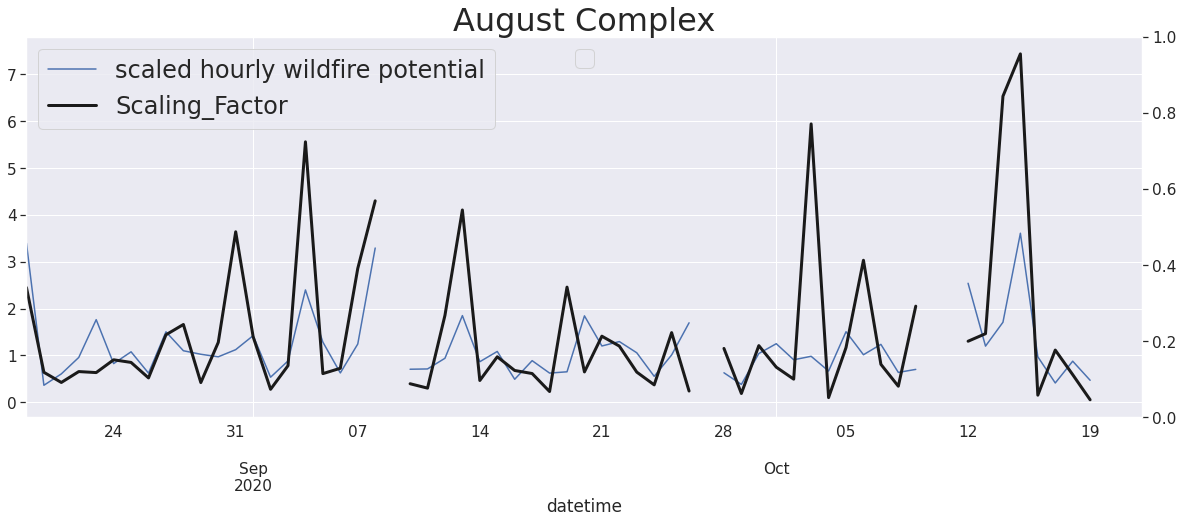

No handles with labels found to put in legend.


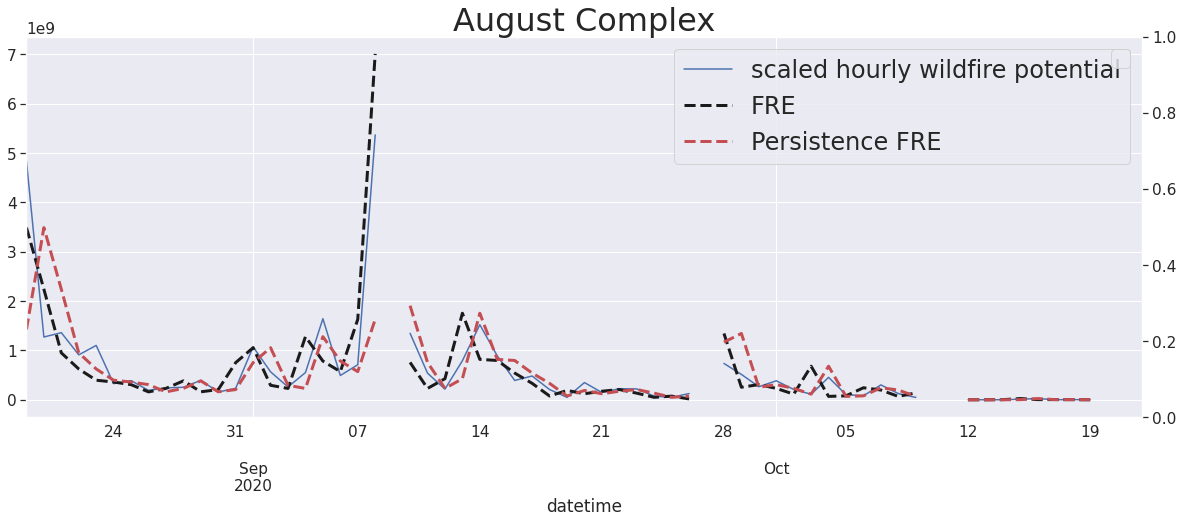

In [39]:

fire_names = ['August Complex']#,'Williams Flats', 'Dixie']

fire = data_test_2020[data_test_2020['irwinID']==test_irwin_ids[0]]
fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    
fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
fire_plot.plot(y=['dhwp'], 
               label=['scaled hourly wildfire potential'],alpha=1, ax=ax)
fire_plot.plot(y=['Scaling_Factor'],style=['k-'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper center', fontsize=24)
ax2.grid(False)

plt.title(fire_names[0], fontsize=32)
plt.show()

fig, ax = plt.subplots(figsize=(20, 7))
ax2=ax.twinx()
#fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
fire_plot.plot(y=['dhwp_fre'], 
               label=['scaled hourly wildfire potential'],alpha=1,ax=ax)
fire_plot.plot(y=['FRE', 'FRE_1'],
               label=['FRE', 'Persistence FRE'],style=['k--', 'r--'],linewidth=3, ax=ax)
#ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=24)
#ax2.set_yscale('log')
ax2.legend(loc='upper right', fontsize=24)
ax2.grid(False)

plt.title(fire_names[0], fontsize=32)
plt.show()

## Add the Eureqa model to the output (only HRRR one is usable since we switched to FRE, not usable for new HDW)

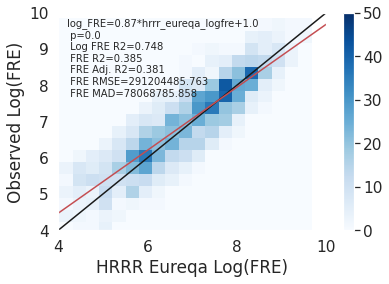

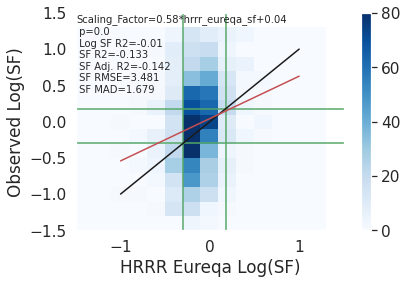

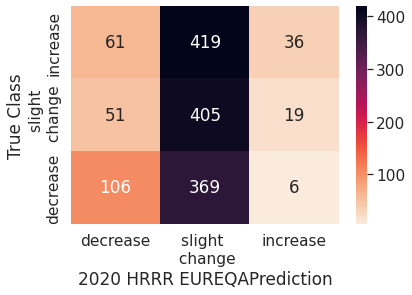

              precision    recall  f1-score   support

    decrease       0.49      0.22      0.30       481
    increase       0.59      0.07      0.12       516
   no_change       0.34      0.85      0.49       475

    accuracy                           0.37      1472
   macro avg       0.47      0.38      0.30      1472
weighted avg       0.48      0.37      0.30      1472



In [20]:
#EUREQA
data_test_2020['hrrr_eureqa_logsf'] = (0.4239*data_test_2020['dhd0w0']) +(0.0614*data_test_2020['dhwp']) + \
                                        (0.0330*data_test_2020['chi'])- 0.5154 - (0.0025*data_test_2020['hd2w0']) - \
                                        (0.1739*data_test_2020['dhd3w0'])


data_test_2020['hrrr_eureqa_sf'] = 10**(data_test_2020['hrrr_eureqa_logsf'])
data_test_2020['hrrr_eureqa_fre'] = data_test_2020['hrrr_eureqa_sf']*data_test_2020['FRE_1']
data_test_2020['hrrr_eureqa_logfre'] = np.log10(data_test_2020['hrrr_eureqa_fre'])
data_test_2020['hrrr_eureqa_cat'] = pd.cut(data_test_2020['hrrr_eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
df_error_metrics_eureqa = pd.DataFrame(index=['hrrr_eureqa'], 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])

frp_hist2d(data_test_2020, 'hrrr_eureqa_fre', 
           'FRE','hrrr_eureqa_logfre', 'log_FRE', 
           'Blues', 0, 50,'HRRR Eureqa Log(FRE)','hrrr_eureqa')
sf_hist2d(data_test_2020, 'hrrr_eureqa_sf', 'Scaling_Factor','hrrr_eureqa_logsf', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,
          'HRRR Eureqa Log(SF)','hrrr_eureqa')
plot_category_heatmap(data_test_2020, 'obs_cat', 'hrrr_eureqa_cat', '2020 HRRR EUREQAPrediction')  

errors_fre = summarize_error(data_test_2020,'FRE', 'hrrr_eureqa_fre',['hrrr_eureqa'])
errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'hrrr_eureqa_logfre',['hrrr_eureqa'])
errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'hrrr_eureqa_sf',['hrrr_eureqa'])
errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'hrrr_eureqa_logsf',['hrrr_eureqa'])
cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['hrrr_eureqa_cat'], output_dict=True))
    

df_error_metrics_eureqa.loc['hrrr_eureqa',['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
df_error_metrics_eureqa.loc['hrrr_eureqa',['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
df_error_metrics_eureqa.loc['hrrr_eureqa',['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
df_error_metrics_eureqa.loc['hrrr_eureqa',['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
df_error_metrics_eureqa.loc['hrrr_eureqa', 'decrease_precision'] = cr.loc['precision', 'decrease']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'decrease_recall'] = cr.loc['recall', 'decrease']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'decrease_f1'] = cr.loc['f1-score', 'decrease']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'increase_precision'] = cr.loc['precision', 'increase']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'increase_recall'] = cr.loc['recall', 'increase']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'increase_f1'] = cr.loc['f1-score', 'increase']

df_error_metrics_eureqa.loc['hrrr_eureqa', 'no_change_precision'] = cr.loc['precision', 'no_change']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'no_change_recall'] = cr.loc['recall', 'no_change']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'no_change_f1'] = cr.loc['f1-score', 'no_change']
df_error_metrics_eureqa.loc['hrrr_eureqa', 'accuracy'] = cr.loc['precision', 'accuracy']

#persistence

df_error_metrics_eureqa['percent_change_FRE_RMSE'] = (df_error_metrics_scaled.loc['persistence','FRE_RMSE']-df_error_metrics_eureqa['FRE_RMSE'])/df_error_metrics_scaled.loc['persistence','FRE_RMSE']
df_error_metrics_eureqa['percent_change_FRE_MAD'] = (df_error_metrics_scaled.loc['persistence','FRE_MAD']-df_error_metrics_eureqa['FRE_MAD'])/df_error_metrics_scaled.loc['persistence','FRE_MAD']


df_error_metrics_eureqa['percent_change_SF_RMSE'] = (df_error_metrics_scaled.loc['persistence','SF_RMSE']-df_error_metrics_eureqa['SF_RMSE'])/df_error_metrics_scaled.loc['persistence','SF_RMSE']
df_error_metrics_eureqa['percent_change_SF_MAD'] = (df_error_metrics_scaled.loc['persistence','SF_MAD']-df_error_metrics_eureqa['SF_MAD'])/df_error_metrics_scaled.loc['persistence','SF_MAD']

In [27]:
# MOISTURE BY THICKNESS
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                    'living_moisture':['FMCGLH2D'],
                    'thin_moisture': ['Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC'],
                    'mid_moisture':['IMERG.FINAL.v6_DMC', 'dead_fuel_moisture_100hr'],
                    'thick_moisture':['IMERG.FINAL.v6_DC','dead_fuel_moisture_1000hr'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()

#moisture as size
not_allowed=['living_moisture']
feature_subsets['features_no_livingm'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_ncar_living'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['FMCGLH2D'])
                                                                   

not_allowed=['thin_moisture']
feature_subsets['features_no_thinm'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_smops'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Blended_SM'])
feature_subsets['features_only_ffmc'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_FFMC'])                          
feature_subsets['features_only_ncar_dead'] = generate_sensitivity_list(features_by_category,
                                    [var for var in category_list if var not in not_allowed], ['FMCG2D'])

not_allowed=['mid_moisture']
feature_subsets['features_no_midm'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_100hr'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], ['dead_fuel_moisture_100hr'])
feature_subsets['features_only_dmc'] = generate_sensitivity_list(features_by_category,
                                    [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DMC'])

not_allowed=['thick_moisture']
feature_subsets['features_no_thickm'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_1000hr'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], ['dead_fuel_moisture_1000hr'])
feature_subsets['features_only_dc'] = generate_sensitivity_list(features_by_category,
                                    [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DC'])

                     'features_only_ffmc', 'features_only_ncar_dead', 'features_only_smops',
                     'features_only_dmc', 'features_only_100hr',
                     'features_only_dc', 'features_only_1000hr',

In [22]:
#new moisture 9/26
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                        
                   'living_moisture':['FMCGLH2D'],
                        
                   'noaa_dead_moisture': ['Blended_SM'],
                   'ncar_dead_moisture': ['FMCG2D'],
                   'cffdrs_moisture':['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC'],
                   'nfdrs_moisture':['dead_fuel_moisture_100hr','dead_fuel_moisture_1000hr'],
                   'hrrr_moisture':['soilm_sfc','soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm'],
                   #'hrrr_moisture':['soilm_30cm'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()




In [23]:
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no persistence
not_allowed = ['persistence']
feature_subsets['features_no_persistence'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])


#no weather
not_allowed = ['raw_weather_gridmet','temperature_gridmet','raw_weather_hrrr','heatwave','derived_weather_hwp','derived_weather_hdw',
                 'derived_weather_cffrds','derived_weather_nfdrs']
feature_subsets['features_no_surface_weather'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_raw_gridmet'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"])


feature_subsets['features_only_raw_hrrrmet'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"])
feature_subsets['features_only_hd0w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd0w0","dhd0w0"])
feature_subsets['features_only_hd1w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd1w0","dhd1w0"])
feature_subsets['features_only_hd2w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd2w0","dhd2w0"])
feature_subsets['features_only_hd3w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd3w0","dhd3w0"])
feature_subsets['features_only_hwp'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hwp","dhwp"])
feature_subsets['features_only_cffdrs'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"])
feature_subsets['features_only_nfdrs'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"])
feature_subsets['features_only_heatwave'] = generate_sensitivity_list(features_by_category, 
                    [var for var in category_list if var not in not_allowed], 
                    ["days_in_high_heatwave","days_in_highlow_heatwave","max_air_temperature","min_air_temperature","temp_range"])
#NO_HEATWAVE
not_allowed = ['heatwave']
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

#no stability
not_allowed = ['stability']
feature_subsets['features_no_stability'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_pft'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['PFT','dPFT'])
feature_subsets['features_only_chi'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['chi','dchi'])


#no living_moisture
not_allowed = ['living_moisture']
feature_subsets['features_no_living_moisture'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no dead moisture, put categories back in 
not_allowed = ['noaa_dead_moisture' 'ncar_dead_moisture', 'cffdrs_moisture', 'nfdrs_moisture', 'hrrr_sm']
feature_subsets['features_no_dead_moisture'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_noaa_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['Blended_SM'])
feature_subsets['features_only_ncar_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['FMCG2D'])
feature_subsets['features_only_cffdrs_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC'])
feature_subsets['features_only_nfdrs_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['dead_fuel_moisture_100hr','dead_fuel_moisture_1000hr'])
feature_subsets['features_only_hrrr_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['soilm_sfc','soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm'])

#no dead moisture, put individual moistures back in
not_allowed = ['noaa_dead_moisture' 'ncar_dead_moisture', 'cffdrs_moisture', 'nfdrs_moisture']
feature_subsets['features_only_cffdrs_ffmc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_FFMC'])
feature_subsets['features_only_cffdrs_dmc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DMC'])
feature_subsets['features_only_cffdrs_dc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DC'])
feature_subsets['features_only_nfdrs_100'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['dead_fuel_moisture_100hr'])
feature_subsets['features_only_nfdrs_1000'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['dead_fuel_moisture_1000hr'])

feature_subsets['features_only_hrrr_sfc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_sfc'])
feature_subsets['features_only_hrrr_1cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_1cm'])
feature_subsets['features_only_hrrr_4cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_4cm'])
feature_subsets['features_only_hrrr_10cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_10cm'])
feature_subsets['features_only_hrrr_30cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_30cm'])
#no pws
not_allowed = ['pws']
feature_subsets['features_no_pws'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no esi
not_allowed = ['esi']
feature_subsets['features_no_esi'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no esi
not_allowed = ['loading']
feature_subsets['features_no_loading'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_LowN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Low_N'])
feature_subsets['features_only_ModerateN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Moderate_N'])
feature_subsets['features_only_HighN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['High_N'])
feature_subsets['features_only_VeryHighN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['VeryHigh_N'])
feature_subsets['features_only_ExtremeN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Extreme_N'])

#no terrain
not_allowed = ['terrain_slope', 'terrain_elevation']
feature_subsets['features_no_terrain'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_slope'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["MEAN_SLOPE","STD_SLOPE"])
feature_subsets['features_only_elevation'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["MEAN_ELEV","STD_ELEV"])

#no DOY
not_allowed = ['DOY']
feature_subsets['features_no_doy'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

# no population
not_allowed = ['pop']
feature_subsets['features_no_population'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
# no containment
not_allowed = ['containment']
feature_subsets['features_no_containment'] = generate_sensitivity_list(features_by_category, 
                                  [var for var in category_list if var not in not_allowed], [])

# no structures
not_allowed = ['structures']
feature_subsets['features_no_structures'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_destroyed_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_destroyed_1"])
feature_subsets['features_only_damaged_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_damaged_1"])
feature_subsets['features_only_threatened_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_threatened_72_1"])

#no resource quantity
not_allowed=['resource_quantity']
feature_subsets['features_no_resource_quantity'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_crew_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["crew_quantity_1"])
feature_subsets['features_only_engine_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["engine_quantity_1"])
feature_subsets['features_only_aircraft_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["air_quantity_1"])
feature_subsets['features_only_construction_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["construction_quantity_1"])

#no resource personnel
not_allowed=['resource_personnel']
feature_subsets['features_no_resource_personnel'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_crew_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["crew_personnel_1"])
feature_subsets['features_only_engine_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["engine_personnel_1"])
feature_subsets['features_only_aircraft_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["air_personnel_1"])
feature_subsets['features_only_construction_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["construction_personnel_1"])
feature_subsets['features_only_overhead_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["overhead_personnel_1"])                   



#print(feature_subsets)

#print(category_list)
#print(category_list.remove('raw_weather_gridmet'))

In [24]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all']
""",'features_no_persistence', 'features_no_surface_weather',
                    'features_no_stability',
                     'features_no_living_moisture', 'features_no_dead_moisture',
                    'features_no_pws', 'features_no_esi','features_no_loading', 'features_no_terrain', 'features_no_doy',
                    'features_no_population','features_no_containment', 'features_no_structures',
                     'features_no_resource_quantity','features_no_resource_personnel',
                    'features_only_pft', 'features_only_chi',
                    'features_only_raw_gridmet','features_only_raw_hrrrmet', 
                    'features_only_hd0w0','features_only_hd1w0',
                    'features_only_hd2w0','features_only_hd3w0', 'features_only_hwp',
                    'features_only_cffdrs', 'features_only_nfdrs', 'features_only_heatwave',

                     
                     #'features_only_ncar_living',
                     'features_only_noaa_sm','features_only_ncar_sm',
                     'features_only_cffdrs_ffmc', 'features_only_cffdrs_dmc', 'features_only_cffdrs_dc',
                     'features_only_nfdrs_100', 'features_only_nfdrs_1000',
                     'features_only_cffdrs_sm', 'features_only_nfdrs_sm',
                     #testing HRRR Sm
                     #'features_only_hrrr_sfc','features_only_hrrr_1cm', 'features_only_hrrr_4cm','features_only_hrrr_10cm', 
                     'features_only_hrrr_30cm',
                     

                     
                     'features_only_LowN','features_only_ModerateN','features_only_HighN',
                     'features_only_VeryHighN', 'features_only_ExtremeN',
                     'features_only_slope', 'features_only_elevation',
                     
                     'features_only_destroyed_structures', 'features_only_damaged_structures','features_only_threatened_structures',
                     'features_only_crew_quantity', 'features_only_engine_quantity','features_only_aircraft_quantity', 
                     'features_only_construction_quantity',
                     
                     'features_only_crew_personnel', 'features_only_engine_personnel','features_only_aircraft_personnel', 
                     'features_only_construction_personnel','features_only_overhead_personnel']"""



df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 

    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    if feature_set_names[ii]=='features_new_all':
        plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

    

features_all OOB R2 score is: 0.22050534046478187
DOING PERSISTENCE


In [62]:
data_test_2020.columns.values

array(['datetime', 'irwinID', 'day', 'FRP_MEAN', 'FRE', 'hwp',
       'soilm_sfc', 'soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm',
       'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'personnel', 'crew_quantity',
       'crew_personnel', 'engine_quantity', 'engine_personnel',
       'air_quantity', 'air_personnel', 'construction_quantity',
       'construction_personnel', 'overhead_personnel',
       'percent_contained', 'U_ml', 'z_fc', 'dtheta_fc', 'PFT',
       'Blended_SM', 'IMERG.FINAL.v6_DC', 'IMERG.FINAL.v6_DMC',
       'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
       'IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_DSR', 'PWS', 'Extreme_N',
       'VeryHigh_N', 'High_N', 'Moderate_N', 'Low_N', 'FMCG2D',
       'FMCGLH2D', 'ESI', 'temp_850', 'temp_700', 'dewpt_850', 'ca', 'cb',
       'chi', 'POP_DENSITY', 'structures_destroyed', 'structures_damaged',
       'structures_threatened_72', 'burning_index_g',
       'energy_release_component-g',
       'potential_evapotrans

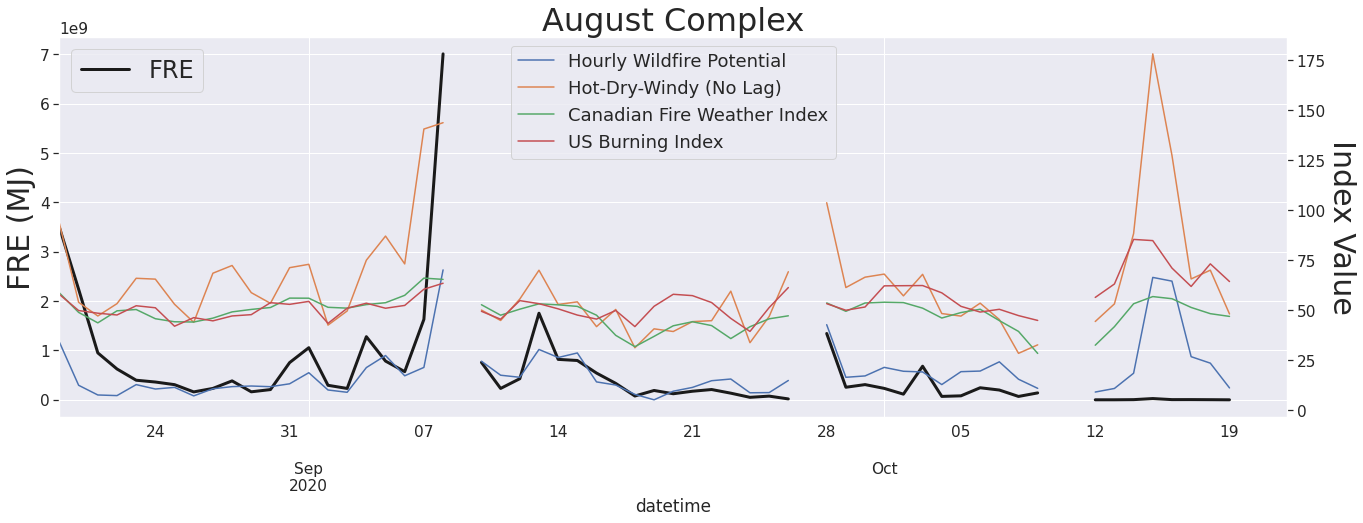

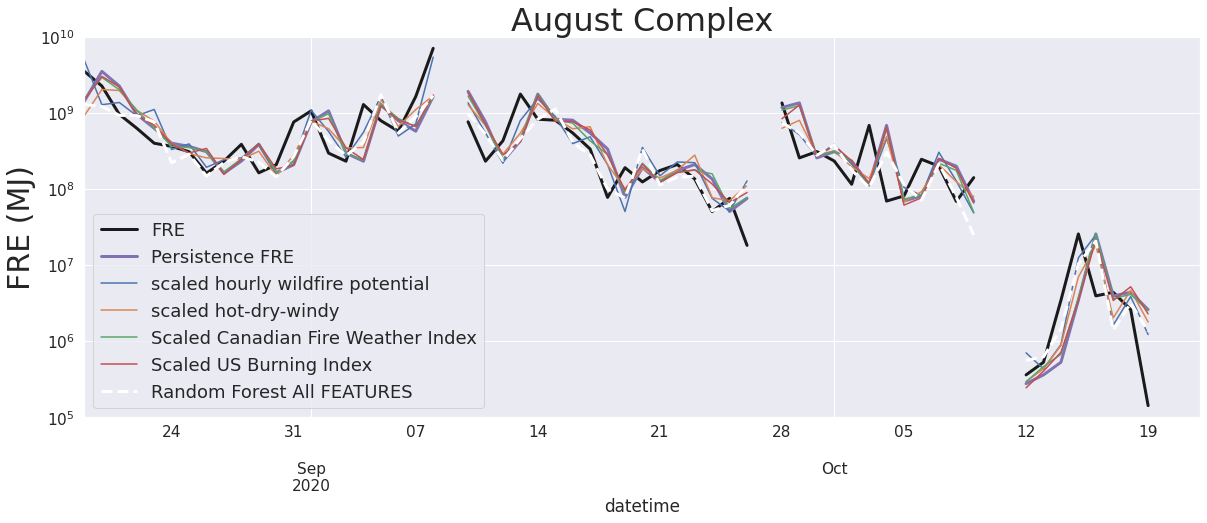

In [87]:
#11/9/2023 updates to Fig 1
fire_names = ['August Complex','Williams Flats']#, 'Dixie']

for ii in range(1):#len(fire_names)):
    #pull from the dataframe that has the predictions in it
    fire = data_test_2020[data_test_2020['irwinID']==test_irwin_ids[ii]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

    #FRE and Indices
    fig, ax = plt.subplots(figsize=(22, 7))
    ax2=ax.twinx()
    #fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
    fire_plot.plot(y=['hwp','hd0w0','IMERG.FINAL.v6_FWI','burning_index_g'], 
               label=['Hourly Wildfire Potential', 'Hot-Dry-Windy (No Lag)','Canadian Fire Weather Index', 'US Burning Index'],alpha=1, ax=ax2)
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    #ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=24)
    #ax2.set_yscale('log')
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax2.set_ylabel('Index Value', labelpad=30, fontsize=30, rotation=270)
    ax2.legend(loc='upper center', fontsize=18)
    ax2.grid(False)

    plt.title(fire_names[ii], fontsize=32)
    plt.show()

    #forecasted FRE
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    fire_plot.plot(y=['FRE_1'],style=['m-'],label=['Persistence FRE'],linewidth=3, ax=ax)

    fire_plot.plot(y=['dhwp_fre', 'dhd0w0_fre', 'dIMERG.FINAL.v6_FWI_fre', 'dburning_index_g_fre'], 
               label=['scaled hourly wildfire potential',
                     'scaled hot-dry-windy',
                     'Scaled Canadian Fire Weather Index',
                     'Scaled US Burning Index'],alpha=1,ax=ax)
    fire_plot.plot(y=['rf_features_all_fre'],style=['w--'],label=['Random Forest All FEATURES'],linewidth=3, ax=ax)

    ax.set_yscale('log')
    ax.legend(loc='lower left', fontsize=18)
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax.set_ylim([1e5,1e10])
    plt.title(fire_names[ii], fontsize=32)
    plt.show()

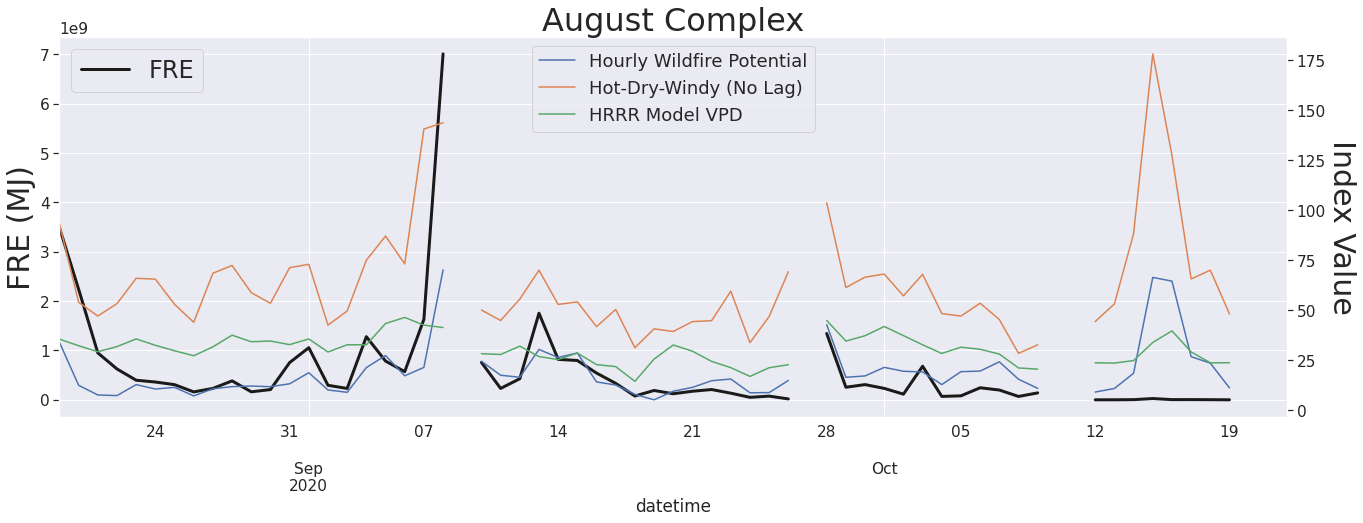

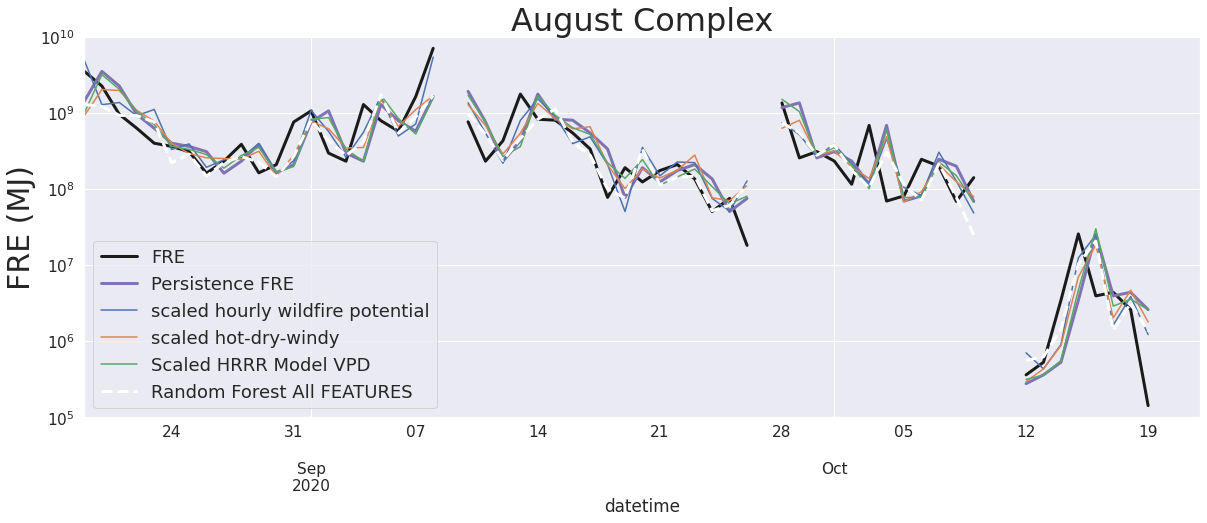

In [90]:
#11/9/2023 updates to Fig 1
fire_names = ['August Complex','Williams Flats']#, 'Dixie']

for ii in range(1):#len(fire_names)):
    #pull from the dataframe that has the predictions in it
    fire = data_test_2020[data_test_2020['irwinID']==test_irwin_ids[ii]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

    #FRE and Indices
    fig, ax = plt.subplots(figsize=(22, 7))
    ax2=ax.twinx()
    #fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
    fire_plot.plot(y=['hwp','hd0w0','vpd_hrrrmet'], 
               label=['Hourly Wildfire Potential', 'Hot-Dry-Windy (No Lag)', 'HRRR Model VPD'],alpha=1, ax=ax2)
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    #ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=24)
    #ax2.set_yscale('log')
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax2.set_ylabel('Index Value', labelpad=30, fontsize=30, rotation=270)
    ax2.legend(loc='upper center', fontsize=18)
    ax2.grid(False)

    plt.title(fire_names[ii], fontsize=32)
    plt.show()

    #forecasted FRE
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    fire_plot.plot(y=['FRE_1'],style=['m-'],label=['Persistence FRE'],linewidth=3, ax=ax)

    fire_plot.plot(y=['dhwp_fre', 'dhd0w0_fre', 'dvpd_hrrrmet_fre'], 
               label=['scaled hourly wildfire potential',
                     'scaled hot-dry-windy',
                     'Scaled HRRR Model VPD'],alpha=1,ax=ax)
    fire_plot.plot(y=['rf_features_all_fre'],style=['w--'],label=['Random Forest All FEATURES'],linewidth=3, ax=ax)

    ax.set_yscale('log')
    ax.legend(loc='lower left', fontsize=18)
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax.set_ylim([1e5,1e10])
    plt.title(fire_names[ii], fontsize=32)
    plt.show()

In [ ]:
all_sensitivity_tests = ['features_all',
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_only_raw_gridmet','features_only_raw_hrrrmet', 
                    'features_only_hd0w0','features_only_hd1w0',
                    'features_only_hd2w0','features_only_hd3w0', 'features_only_hwp',
                    'features_only_cffdrs', 'features_only_nfdrs', 'features_only_heatwave',
                         'features_no_stability', #stabiity
                         'features_only_pft', 'features_only_chi',
                         'features_no_dead_moisture', #dead
                         'features_only_noaa_sm','features_only_ncar_sm',
                     #'features_only_cffdrs_ffmc', 'features_only_cffdrs_dmc', 'features_only_cffdrs_dc',
                     #'features_only_nfdrs_100', 'features_only_nfdrs_1000',
                     'features_only_cffdrs_sm', 'features_only_nfdrs_sm',
                         
                         #testing HRRR Sm
                     #'features_only_hrrr_sfc','features_only_hrrr_1cm', 'features_only_hrrr_4cm',
                     #'features_only_hrrr_10cm', 
                         'features_only_hrrr_30cm',
                         
                         'features_no_living_moisture', #living
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_only_LowN','features_only_ModerateN','features_only_HighN',
                         'features_only_VeryHighN', 'features_only_ExtremeN',
                         'features_no_terrain', #terrain
                         'features_only_slope', 'features_only_elevation',
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_only_destroyed_structures', 'features_only_damaged_structures','features_only_threatened_structures',
                     'features_no_resource_quantity', #resource quantity
                         'features_only_crew_quantity', 'features_only_engine_quantity','features_only_aircraft_quantity', 
                     'features_only_construction_quantity',
                         'features_no_resource_personnel', #resource personnel
                     'features_only_crew_personnel', 'features_only_engine_personnel','features_only_aircraft_personnel', 
                     'features_only_construction_personnel','features_only_overhead_personnel']

no_category_sensitivity_tests=['features_all',
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_no_stability', #stabiity
                         'features_no_living_moisture', #living
                         'features_no_dead_moisture', #dead
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_no_terrain', #terrain
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_no_resource_quantity', #resource quantity
                         'features_no_resource_personnel',] #resource personnel']

In [51]:
def plot_frp_sensitivity_metrics(df_metrics, vars_plot, vars_plot_no_cat,reference_label,figsize_tuple, lower_r2_limit, lower_ss_limit):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_no_cat_plot = df_error_metrics_plot.copy(deep=True)
    df_error_metrics_no_cat_plot[~df_error_metrics_no_cat_plot.index.isin(vars_plot_no_cat)] =-10    
    
    fig, ax = plt.subplots(figsize=figsize_tuple)

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p4=ax.scatter(df_error_metrics_no_cat_plot['percent_change_FRE_RMSE'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='none of this category are included')
    p5=ax.scatter(df_error_metrics_no_cat_plot['percent_change_FRE_MAD'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='none of this category are included')
    p6=twin1.scatter(df_error_metrics_no_cat_plot['FRE_R2_adj'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='RF trained on NO \n variables of category')
    p7=twin1.scatter(df_error_metrics_no_cat_plot['FRE_R2_adj'],df_error_metrics_no_cat_plot.index,c='k',s=0, label='RF trained on ONE variable of category')

    p1=ax.scatter(df_error_metrics_plot['percent_change_FRE_RMSE'],df_error_metrics_plot.index,c='orange',s=100, label='RMSE Skill Score')
    p2=ax.scatter(df_error_metrics_plot['percent_change_FRE_MAD'],df_error_metrics_plot.index,c='g',s=100,label='MAD Skill Score')
    p3=twin1.scatter(df_error_metrics_plot['FRE_R2_adj'],df_error_metrics_plot.index, c='b',s=100,label='FRE Adj. R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[reference_label, 'FRE_R2_adj'],c='b', linestyle='--')

    #set properties of the x labels
    #twin1.set_xlim([df_error_metrics_plot['FRE_R2'].min()-.1,df_error_metrics_plot['FRE_R2'].max()+.01])
    twin1.set_xlim([lower_r2_limit, 0.55])
    
    #ax.set_xlim([np.min(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].min().values)-.01,
    #            np.max(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].max().values)+.01])
    ax.set_xlim([lower_ss_limit, 0.25])
    ax.set_xlabel("Skill Score")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1,p2, p3, p6], loc="upper left", fontsize=12)#bbox_to_anchor=(0.45,1) )
    ax.grid(True, c='gray')

    plt.show()
    

    
def plot_f1_sensitivity_metrics(df_metrics, vars_plot,vars_plot_no_cat,reference_label,figsize_tuple, lower_f1_limit):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_no_cat_plot = df_error_metrics_plot.copy(deep=True)
    df_error_metrics_no_cat_plot[~df_error_metrics_no_cat_plot.index.isin(vars_plot_no_cat)] =-10   
    
    fig, ax = plt.subplots(figsize=figsize_tuple)
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))

    p4=ax.scatter(df_error_metrics_no_cat_plot['increase_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150,marker='o', label='none of this category are included')
    p5=ax.scatter(df_error_metrics_no_cat_plot['decrease_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150, marker='o',label='none of this category are included')
    p6=ax.scatter(df_error_metrics_no_cat_plot['no_change_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150, marker='o',label='RF trained on NO \n variables of category')
    p7=ax.scatter(df_error_metrics_no_cat_plot['no_change_f1'],df_error_metrics_no_cat_plot.index,c='k',s=0, marker='o',label='RF trained on ONE variable of category')


    p1=ax.scatter(df_error_metrics_plot['increase_f1'],df_error_metrics_plot.index,c='r',s=100, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_f1'],df_error_metrics_plot.index,c='c',s=100,label='decreases')
    p3=ax.scatter(df_error_metrics_plot['no_change_f1'],df_error_metrics_plot.index, c='tan',s=100,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'increase_f1'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'decrease_f1'],c='c', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'no_change_f1'],c='tan', linestyle='--')

    #twin1.set_xlim([df_error_metrics['no_change_f1'].min(),df_error_metrics['no_change_f1'].max()])
    #ax.set_xlim([np.min(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].min().values)-.01,
    #             np.max(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].max().values)+.005])
    ax.set_xlim([lower_f1_limit, 0.55])
    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Feature Configuration")


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', color=[1,0,0,0],labelcolor=[1,0,0,0],**tkw)

    ax.legend(handles=[p1,p2, p3, p6], loc="upper left", fontsize=12)#bbox_to_anchor=(0.45,1) )
    ax.grid(True, c='gray')
    plt.yticks(fontsize=20)
    plt.show()

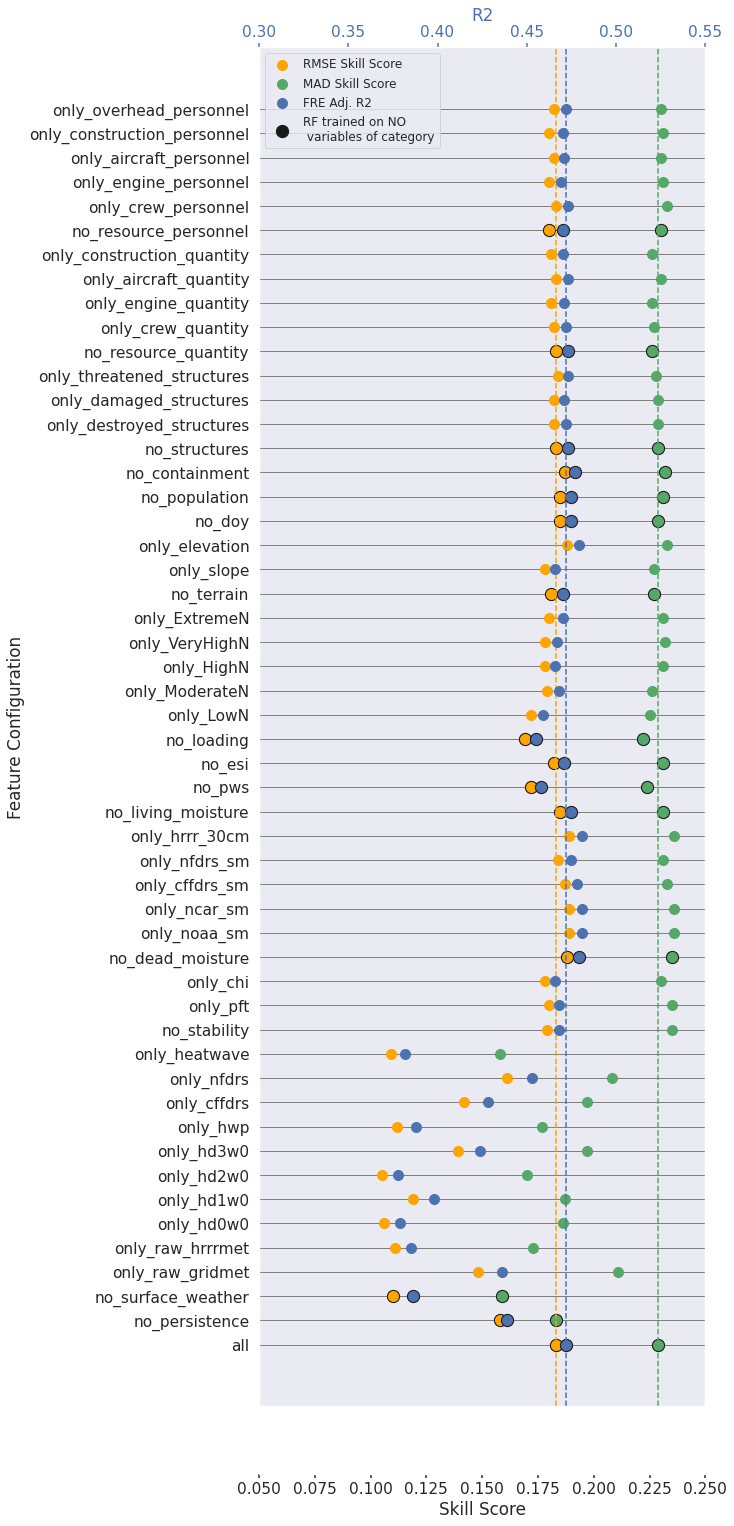

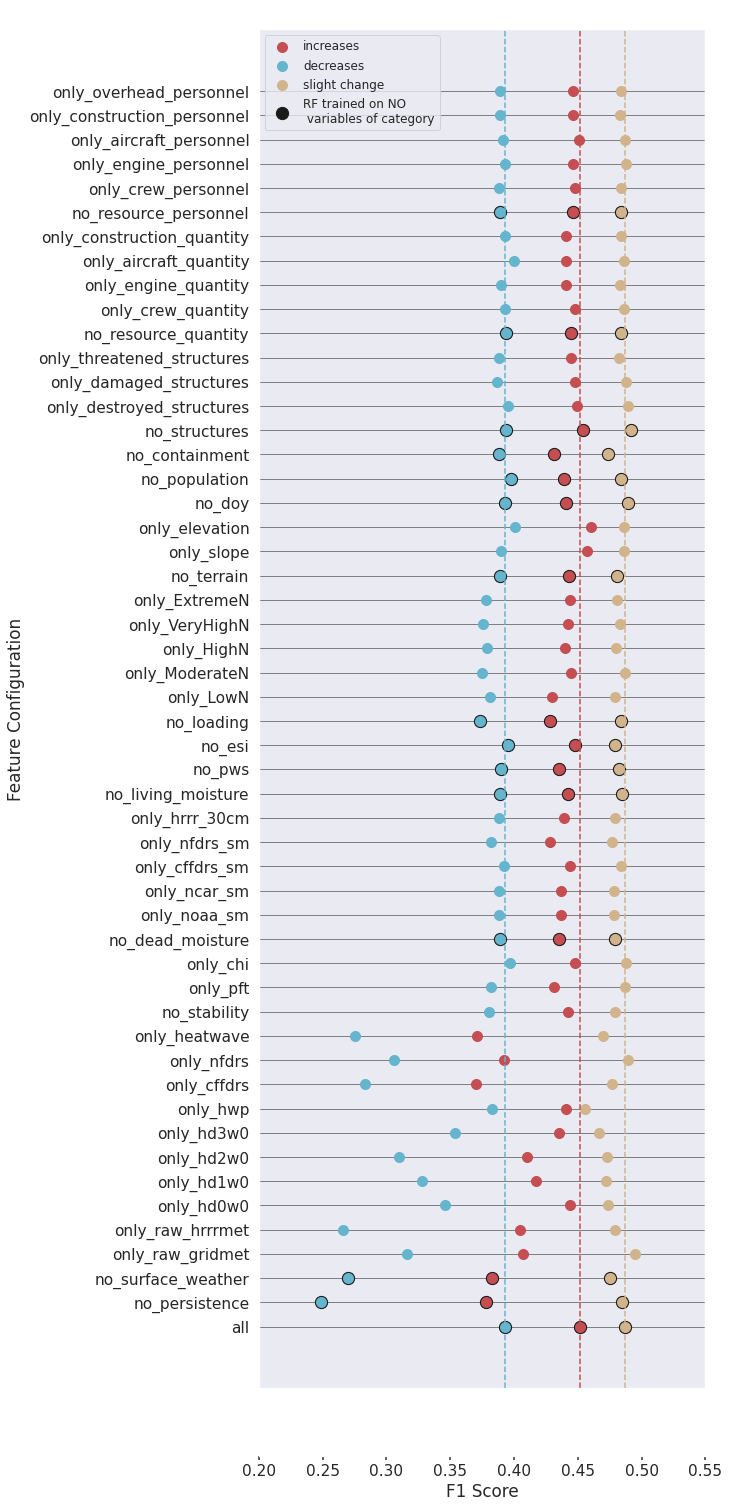

ValueError: could not convert string to float: 'persistence'

In [52]:
# every sensitivity test in one figure, 8/11
all_sensitivity_tests = ['all',
                         'no_persistence', #persistence
                         'no_surface_weather', #weather
                         'only_raw_gridmet','only_raw_hrrrmet', 
                    'only_hd0w0','only_hd1w0',
                    'only_hd2w0','only_hd3w0', 'only_hwp',
                    'only_cffdrs', 'only_nfdrs', 'only_heatwave',
                         'no_stability', #stabiity
                         'only_pft', 'only_chi',
                         'no_dead_moisture', #dead
                         'only_noaa_sm','only_ncar_sm',
                     'only_cffdrs_sm', 'only_nfdrs_sm',
                         'only_hrrr_30cm',
                         'no_living_moisture', #living
                        'no_pws', 'no_esi', #water stress
                         'no_loading', #loading
                         'only_LowN','only_ModerateN','only_HighN',
                         'only_VeryHighN', 'only_ExtremeN',
                         'no_terrain', #terrain
                         'only_slope', 'only_elevation',
                         'no_doy', #doy
                        'no_population','no_containment', #pop and containment
                         'no_structures', #structures
                     'only_destroyed_structures', 'only_damaged_structures','only_threatened_structures',
                     'no_resource_quantity', #resource quantity
                         'only_crew_quantity', 'only_engine_quantity','only_aircraft_quantity', 
                     'only_construction_quantity',
                         'no_resource_personnel', #resource personnel
                     'only_crew_personnel', 'only_engine_personnel','only_aircraft_personnel', 
                     'only_construction_personnel','only_overhead_personnel']

no_category_sensitivity_tests=['all',
                         'no_persistence', #persistence
                         'no_surface_weather', #weather
                         'fno_stability', #stabiity
                         'no_living_moisture', #living
                         'no_dead_moisture', #dead
                        'no_pws', 'no_esi', #water stress
                         'no_loading', #loading
                         'no_terrain', #terrain
                         'no_doy', #doy
                        'no_population','no_containment', #pop and containment
                         'no_structures', #structures
                     'no_resource_quantity', #resource quantity
                         'no_resource_personnel',] #resource personnel']

df_error_metrics_rf = pd.read_csv('error_fig2_hrrrmoisturte.csv')#.set_index('Unnamed: 0')
df_error_metrics_rf['Feature_Configs'] = ''
#print(df_error_metrics_rf)
for ii in range(len(df_error_metrics_rf['Unnamed: 0'].values)):
    name = df_error_metrics_rf['Unnamed: 0'].values[ii]
    #print(name + " " + name.replace('features_',''))
    df_error_metrics_rf['Feature_Configs'].iloc[ii]=name.replace('features_','')
    
df_error_metrics_rf = df_error_metrics_rf.set_index('Feature_Configs')

plot_frp_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests, no_category_sensitivity_tests,'all',(8,25),0.3, 0.05)
plot_f1_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests, no_category_sensitivity_tests,'all',(8,25),0.2)


df_error_metrics_rf_rounded = round(df_error_metrics_rf.astype('float64'),3)
print(df_error_metrics_rf_rounded)
#df_error_metrics_rf_rounded.to_csv('error_fig2_hrrrmoisturte.csv')"""

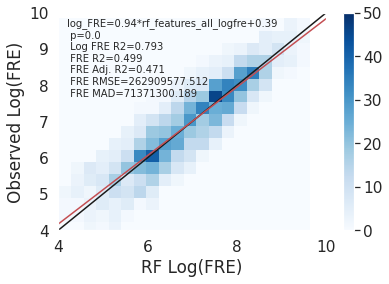

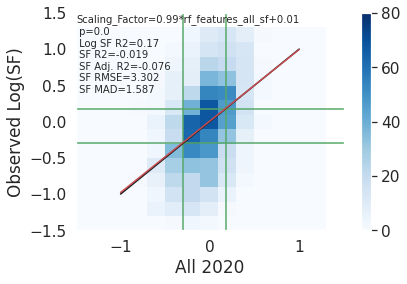

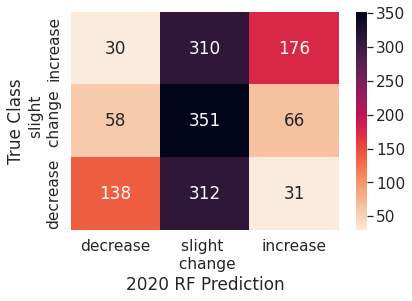

              precision    recall  f1-score   support

    decrease       0.61      0.29      0.39       481
    increase       0.64      0.34      0.45       516
   no_change       0.36      0.74      0.48       475

    accuracy                           0.45      1472
   macro avg       0.54      0.46      0.44      1472
weighted avg       0.54      0.45      0.44      1472



In [24]:
# Plotting
for ii in range(1,len(feature_set_names)):

    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_fre', 'FRE','rf_'+feature_set_names[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,'RF Log(FRE)',feature_subsets[feature_set_names[ii]])
    
    sf_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor','Blues',0,80, -.3, .18, 'All 2020',feature_subsets[feature_set_names[ii]])
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  



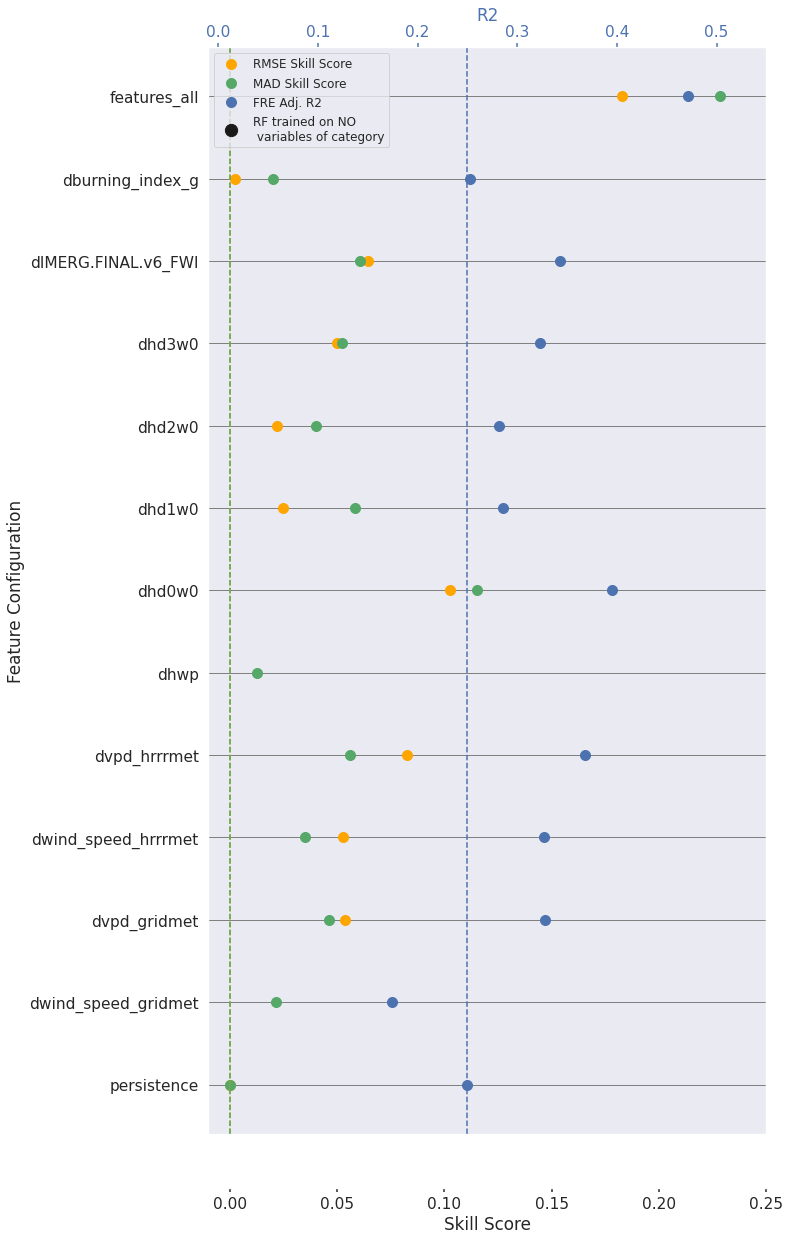

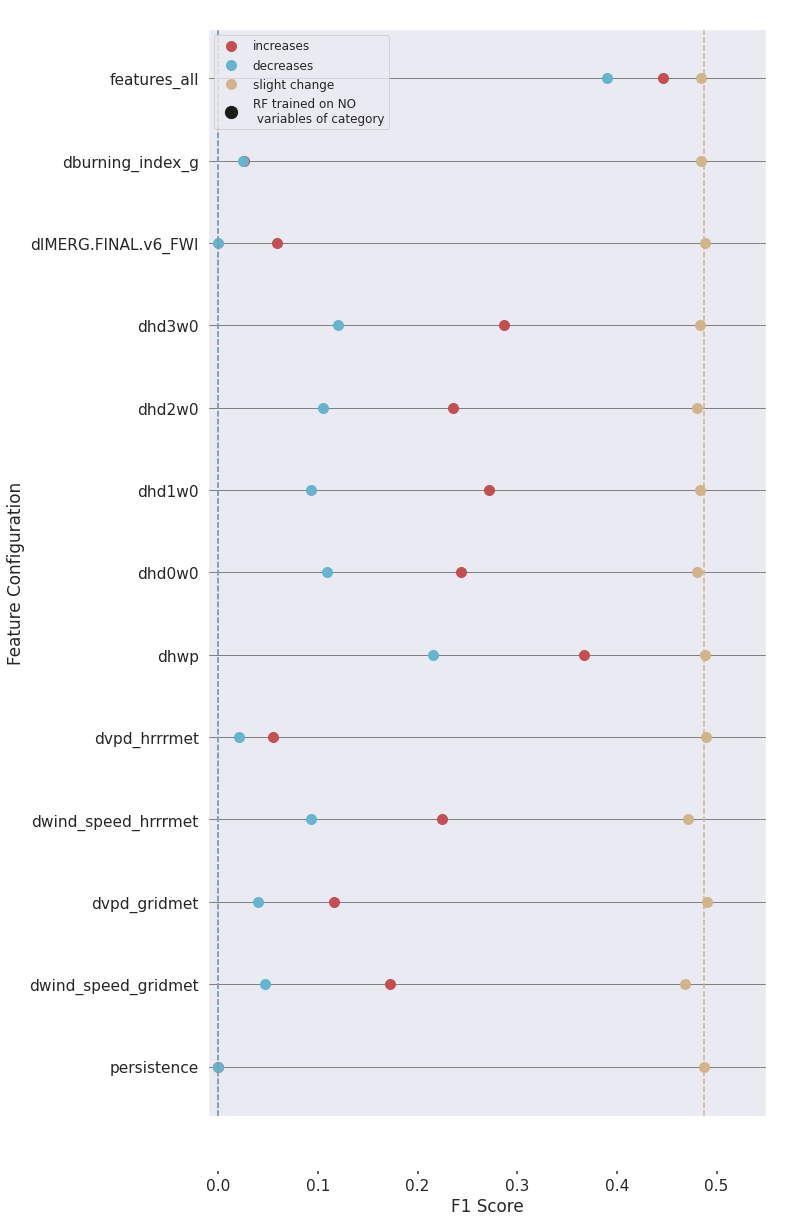

                             FRE_R2  FRE_R2_adj      FRE_RMSE      FRE_MAD  \
persistence                    0.25        0.25  3.216907e+08  92521743.97   
dwind_speed_gridmet            0.18        0.17  3.372821e+08  90526711.36   
dvpd_gridmet                   0.33        0.33  3.044942e+08  88262470.70   
dwind_speed_hrrrmet            0.33        0.33  3.047113e+08  89287443.70   
dvpd_hrrrmet                   0.37        0.37  2.951004e+08  87321545.03   
dmax_air_temperature           0.24        0.24  3.238750e+08  93410845.46   
dhwp                          -0.60       -0.60  4.694994e+08  91347857.32   
dhd0w0                         0.40        0.40  2.886971e+08  81850366.52   
dhd1w0                         0.29        0.29  3.137284e+08  87116019.75   
dhd2w0                         0.28        0.28  3.146189e+08  88811623.58   
dhd3w0                         0.32        0.32  3.055768e+08  87704604.46   
dIMERG.FINAL.v6_FWI            0.34        0.34  3.009576e+08  8

In [25]:
#SCALED METHODS, NO EUREQA
all_sensitivity_tests = ['persistence','dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                          'dhwp',
                         'dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',#'dIMERG.FINAL.v6_BUI',
                         'dburning_index_g',#'denergy_release_component-g',
                         'features_all']


df_error_metrics = pd.concat([df_error_metrics_scaled, 
                              df_error_metrics_rf.iloc[1:2,:]])
#df_error_metrics = pd.read_csv('error_fig1.csv')
#round the error metrics
df_error_metrics_rounded = round(df_error_metrics.astype('float64'),2)
plot_frp_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence', (10,20), -0.01, -0.01)
plot_f1_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence',(10,20), -0.01)
print(df_error_metrics_rounded)
#df_error_metrics_rounded.to_csv('error_fig1.csv')

In [21]:
#SCALED METHODS, WITH EUREQA
all_sensitivity_tests = ['persistence','dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                          'dhwp',
                         'dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                         'dburning_index_g',
                         'hrrr_eureqa','features_all']


df_error_metrics = pd.concat([df_error_metrics_scaled, 
                              df_error_metrics_eureqa.iloc[0:1,:],
                              df_error_metrics_rf.iloc[1:2,:]])
#df_error_metrics = pd.read_csv('error_fig1.csv')
#round the error metrics
df_error_metrics_rounded = round(df_error_metrics.astype('float64'),2)
plot_frp_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence', (10,20), -0.01, -0.01)
plot_f1_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence',(10,20), -0.01)
print(df_error_metrics_rounded)
#df_error_metrics_rounded.to_csv('error_fig1.csv')

NameError: name 'df_error_metrics_eureqa' is not defined

In [1]:
# every sensitivity test in one figure, 8/11 MOISTURE BY SIZE
all_sensitivity_tests = ['features_all',
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_only_raw_gridmet','features_only_raw_hrrrmet', 
                    'features_only_hd0w0','features_only_hd1w0',
                    'features_only_hd2w0','features_only_hd3w0', 'features_only_hwp',
                    'features_only_cffdrs', 'features_only_nfdrs', 'features_only_heatwave',
                         'features_no_stability', #stabiity
                         'features_only_pft', 'features_only_chi',
                         'features_no_thinm', #thin fuel_moisture
                         'features_only_ffmc', 'features_only_ncar_dead', 'features_only_smops',
                         'features_no_midm',#midsize fuel_moisture
                         'features_only_dmc', 'features_only_100hr',
                         'features_no_thickm',#thick fuel_moisture
                         'features_only_dc', 'features_only_1000hr',
                         'features_no_livingm', #living
                         #'features_only_ncar_living', 
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_only_LowN','features_only_ModerateN','features_only_HighN',
                         'features_only_VeryHighN', 'features_only_ExtremeN',
                         'features_no_terrain', #terrain
                         'features_only_slope', 'features_only_elevation',
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_only_destroyed_structures', 'features_only_damaged_structures','features_only_threatened_structures',
                     'features_no_resource_quantity', #resource quantity
                         'features_only_crew_quantity', 'features_only_engine_quantity','features_only_aircraft_quantity', 
                     'features_only_construction_quantity',
                         'features_no_resource_personnel', #resource personnel
                     'features_only_crew_personnel', 'features_only_engine_personnel','features_only_aircraft_personnel', 
                     'features_only_construction_personnel','features_only_overhead_personnel']

no_category_sensitivity_tests=[
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_no_stability', #stabiity
                         'features_no_thinm', #thin fuel_moisture
                         'features_no_midm',#midsize fuel_moisture
                         'features_no_thickm',#thick fuel_moisture
                         'features_no_livingm', #living
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_no_terrain', #terrain
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_no_resource_quantity', #resource quantity
                         'features_no_resource_personnel', #resource personnel'
]

#df_error_metrics_rf = pd.read_csv('error_fig2.csv')
plot_frp_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests,no_category_sensitivity_tests,'features_all',(10,20),0.3, 0.05)
plot_f1_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests,no_category_sensitivity_tests,'features_all',(10,20),0.2)



#df_error_metrics_rf_rounded.to_csv('error_fig2.csv')

NameError: name 'plot_frp_sensitivity_metrics' is not defined

In [172]:
df_error_metrics_rf_rounded = round(df_error_metrics_rf.astype('float64'),2)
print(df_error_metrics_rf_rounded.loc[:,['FRE_R2_adj', 'percent_change_FRE_RMSE','percent_change_FRE_MAD',
                                      'increase_f1', 'decrease_f1', 'no_change_f1']])

                                      FRE_R2_adj  percent_change_FRE_RMSE  \
persistence                                 0.25                     0.00   
features_all                                0.48                     0.19   
features_no_persistence                     0.47                     0.18   
features_no_surface_weather                 0.40                     0.12   
features_no_stability                       0.50                     0.20   
features_no_livingm                         0.48                     0.19   
features_no_thinm                           0.47                     0.18   
features_no_midm                            0.49                     0.19   
features_no_thickm                          0.49                     0.20   
features_no_pws                             0.47                     0.18   
features_no_esi                             0.49                     0.20   
features_no_loading                         0.48                     0.18   

# Final Try at Optimal Subsets

In [32]:
#9/26

feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])



feature_subsets['features_can_hwp'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   #'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_can_hdw'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_us_hwp'] = ['burning_index_g', 'dburning_index_g',
                                   #'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_us_hdw'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                    'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hwp'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                           'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_gridmet_hdw'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                    'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_gridmet_hwp_noaa_sm'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hwp_ncar_sm'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'FMCG2D',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_gridmet_hwp_nfdrs_sm'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_gridmet_hwp_cffdrs_sm'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",

                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

"""feature_subsets['features_hd0w0'] = ['hd0w0', 'hd0w0',
                                   #'hd3w0', 'hd3w0',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_hd3w0'] = [#'hd0w0', 'hd0w0',
                                   'hd3w0', 'hd3w0',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

"""

'feature_subsets[\'features_hd0w0\'] = [\'hd0w0\', \'hd0w0\',\n                                   #\'hd3w0\', \'hd3w0\',\n                                  \'hwp\',\'dhwp\',\n                                   \'PFT\', \'dPFT\', \n                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",\n                                   \'PWS\',\'Extreme_N\',\n                                   \'MEAN_ELEV\', \'STD_ELEV\',\n                                    \'structures_threatened_72_1\',\'air_quantity_1\',\n                                   \'FRE_1\' ]\nfeature_subsets[\'features_hd3w0\'] = [#\'hd0w0\', \'hd0w0\',\n                                   \'hd3w0\', \'hd3w0\',\n                                  \'hwp\',\'dhwp\',\n                                   \'PFT\', \'dPFT\', \n                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",\n                                   \'PWS\',\'Extreme_N\',\n                

In [154]:
#TRY ENGINE PERSONNEL
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])


feature_subsets['features_raw_gridmet'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                           'hwp','dhwp',
                                           'PFT', 'dPFT', 
                                            'Blended_SM',  'FMCG2D', 'FMCGLH2D',
                                           'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

feature_subsets['features_hdw'] = ['hd0w0','dhd0w0',
                                   'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',  'FMCG2D', 'FMCGLH2D','PWS','Moderate_N','DOY',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

feature_subsets['features_can'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',

                                   'FRE_1' ]

feature_subsets['features_us'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                'Blended_SM','dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Moderate_N', 'DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

In [ ]:
#TRY CREW quantity
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])


feature_subsets['features_raw_gridmet'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                           'hwp','dhwp',
                                           'PFT', 'dPFT', 
                                            'Blended_SM',  'FMCG2D', 'FMCGLH2D',
                                           'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','crew_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_hdw'] = ['hd0w0', 'dhd1w0', 
                                   'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',  'FMCG2D', 'FMCGLH2D','PWS','Moderate_N','DOY',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','crew_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_can'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Moderate_N','DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','crew_quantity_1',

                                   'FRE_1' ]

feature_subsets['features_us'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                'Blended_SM','dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Moderate_N', 'DOY',
                                   'MEAN_SLOPE', 'STD_SLOPE',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','crew_quantity_1',
                                   'FRE_1' ]

In [21]:
data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])
data_test_2020['persistence_cat']='no_change'

In [30]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

"""feature_set_names = ['persistence','features_all','features_gridmet','features_hd0w0','features_hd3w0',
                     'features_can','features_us']"""

feature_set_names = ['persistence','features_all','features_can_hwp', 'features_can_hdw',
                                    'features_us_hwp', 'features_us_hdw',
                    'features_gridmet_hwp', 'features_gridmet_hdw',
                     'features_hrrrmet_hwp',
                     'features_gridmet_hwp_noaa_sm', 'features_gridmet_hwp_ncar_sm',
                     'features_gridmet_hwp_nfdrs_sm', 'features_gridmet_hwp_cffdrs_sm'
                    ]


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

features_all OOB R2 score is: 0.22206503199766914
features_can_hwp OOB R2 score is: 0.17122906268302274
features_can_hdw OOB R2 score is: 0.1423156708123412
features_us_hwp OOB R2 score is: 0.1451321803853196
features_us_hdw OOB R2 score is: 0.16422663207684762
features_gridmet_hwp OOB R2 score is: 0.21678631941284887
features_gridmet_hdw OOB R2 score is: 0.17172432444373043
features_hrrrmet_hwp OOB R2 score is: 0.19490693000545067
features_gridmet_hwp_noaa_sm OOB R2 score is: 0.22183301219685114
features_gridmet_hwp_ncar_sm OOB R2 score is: 0.20980647134734398
features_gridmet_hwp_nfdrs_sm OOB R2 score is: 0.21521072512360795
features_gridmet_hwp_cffdrs_sm OOB R2 score is: 0.21678631941284887
DOING PERSISTENCE


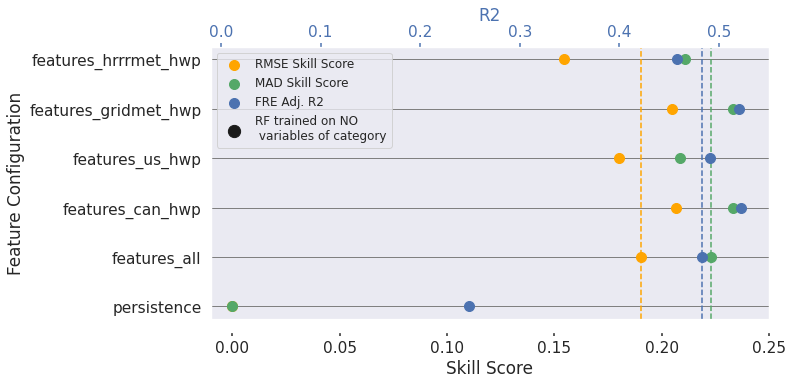

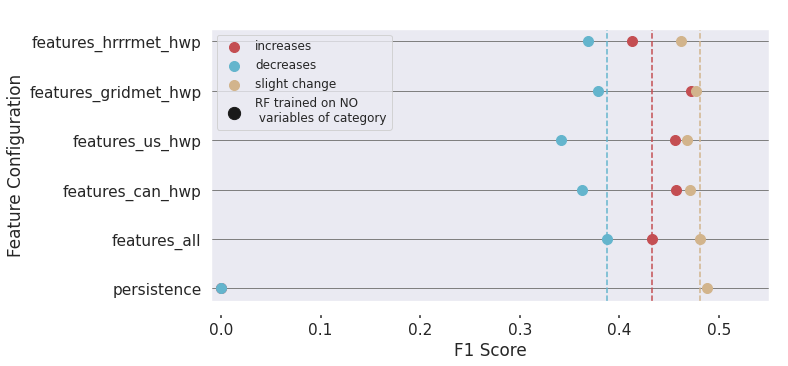

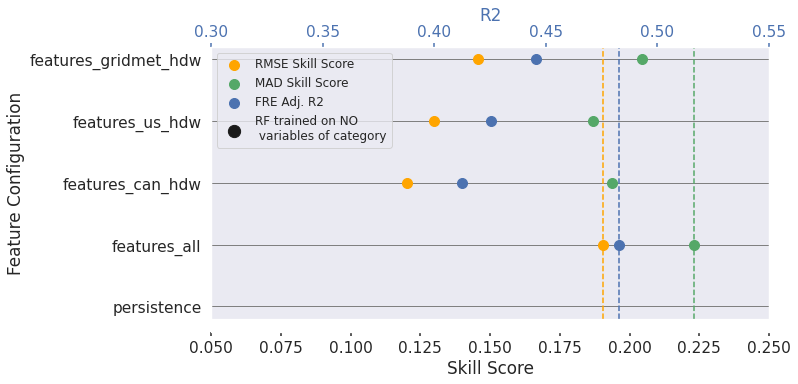

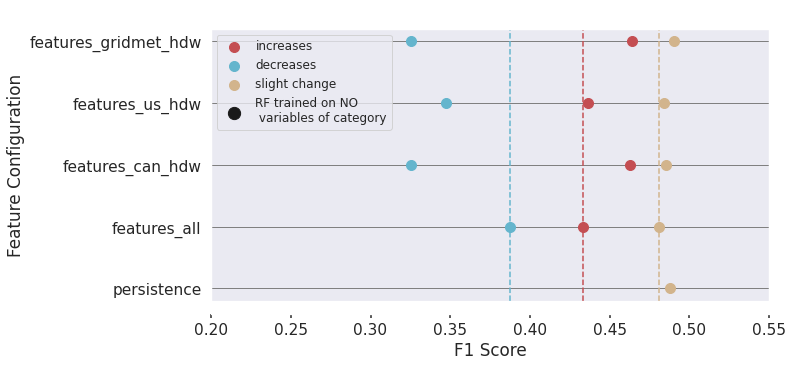

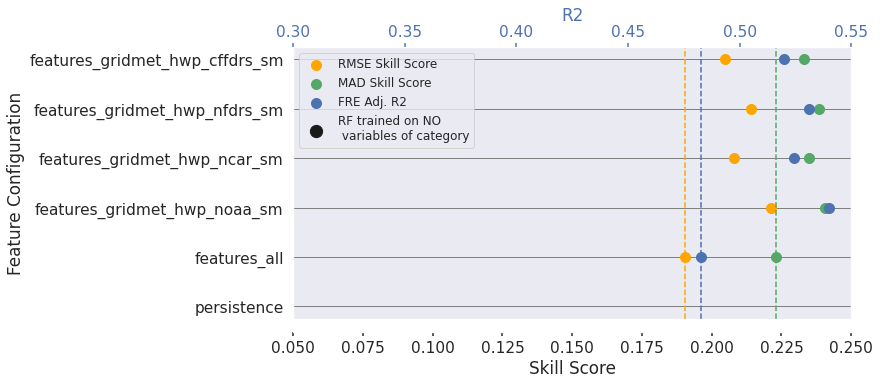

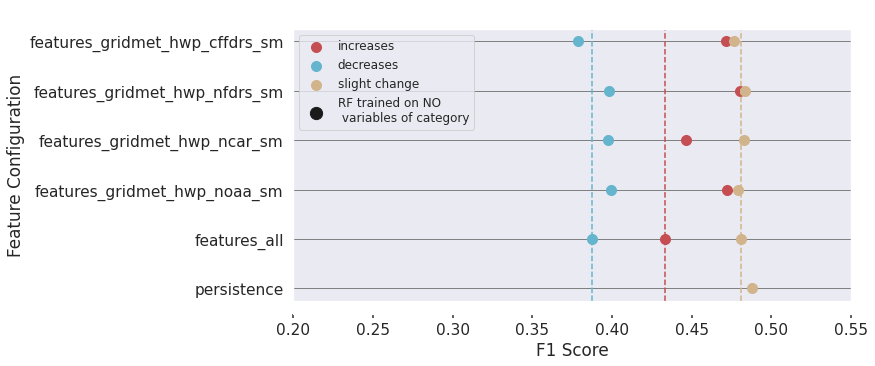

In [31]:
"""opt_subsets = ['persistence','features_all','features_gridmet', 'features_hd0w0','features_hd3w0',
                     'features_can','features_us']"""
opt_subsets_hwp=['persistence','features_all','features_can_hwp',
            'features_us_hwp', 'features_gridmet_hwp', 'features_hrrrmet_hwp']

opt_subsets_hdw=['persistence','features_all','features_can_hdw',
            'features_us_hdw', 'features_gridmet_hdw']

opt_subsets_gridmet = ['persistence','features_all',
                     'features_gridmet_hwp_noaa_sm', 'features_gridmet_hwp_ncar_sm',
                     'features_gridmet_hwp_nfdrs_sm', 'features_gridmet_hwp_cffdrs_sm']



plot_frp_sensitivity_metrics(df_error_metrics_rf, opt_subsets_hwp,[], 'features_all',(10,5), -.01,  -.01)
plot_f1_sensitivity_metrics(df_error_metrics_rf, opt_subsets_hwp,[],'features_all',(10,5),  -.01)

plot_frp_sensitivity_metrics(df_error_metrics_rf, opt_subsets_hdw,[], 'features_all',(10,5), 0.3, 0.05)
plot_f1_sensitivity_metrics(df_error_metrics_rf, opt_subsets_hdw,[],'features_all',(10,5), 0.2)

plot_frp_sensitivity_metrics(df_error_metrics_rf, opt_subsets_gridmet,[], 'features_all',(10,5), 0.3, 0.05)
plot_f1_sensitivity_metrics(df_error_metrics_rf, opt_subsets_gridmet,[],'features_all',(10,5), 0.2)

#print(df_error_metrics_rf[['FRE_R2_adj','percent_change_FRE_RMSE','percent_change_FRE_MAD',
#                           'increase_f1','decrease_f1','no_change_f1']].round(2))
#df_error_metrics_rf.to_csv('error_fig3.csv')

# Forecastable variables test (10/6)

In [24]:
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_soilm_sfc'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_sfc',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_1cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_1cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_4cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_4cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_10cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_10cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
#previously called features_soilm_30cm
feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_can_hwp'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_us_hwp'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hwp'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_can_hdw'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                  'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_us_hdw'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hdw'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_hrrrmet_hdw'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]


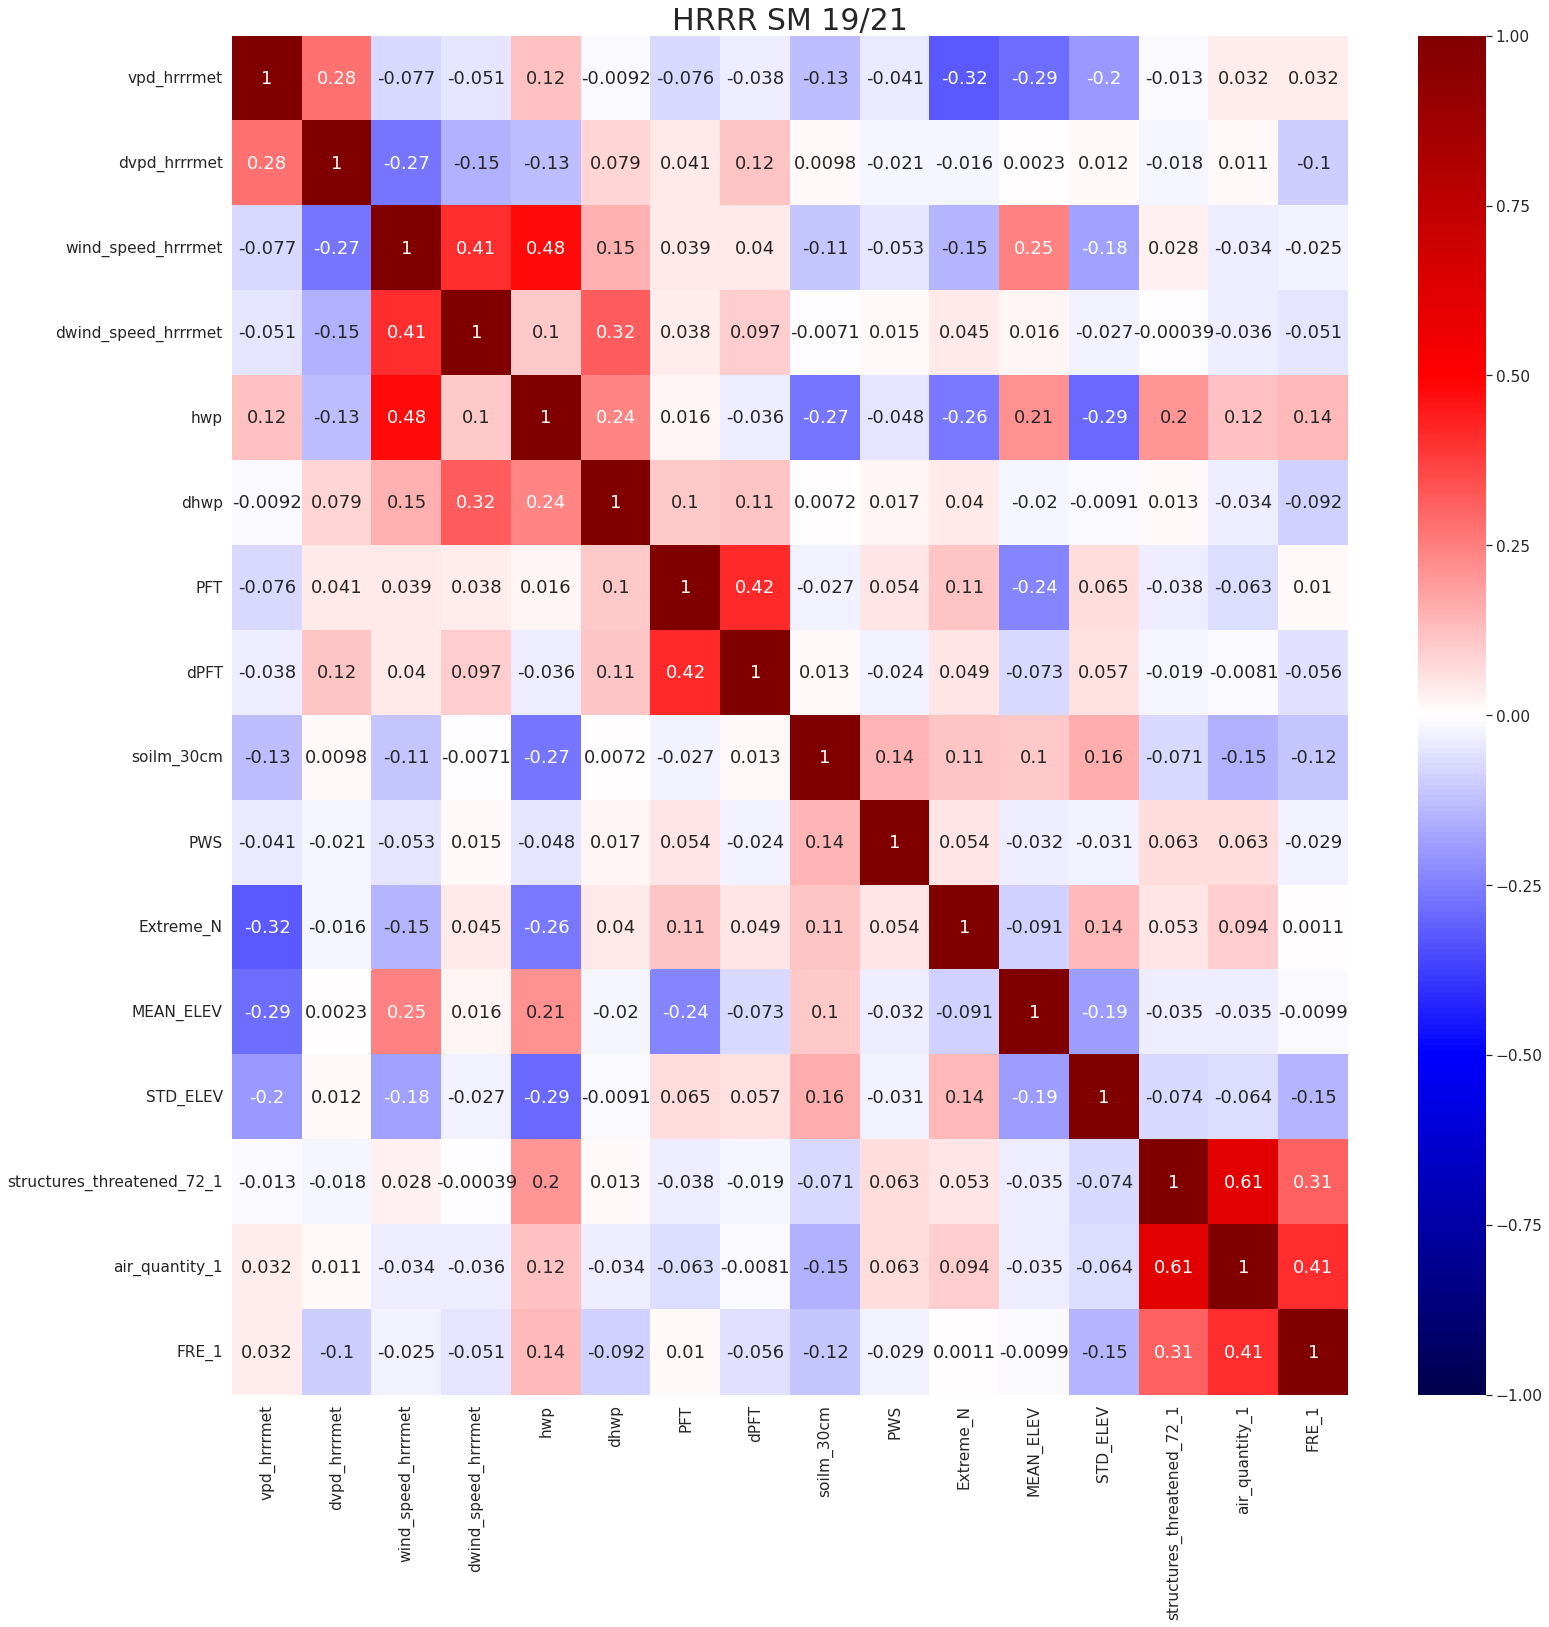

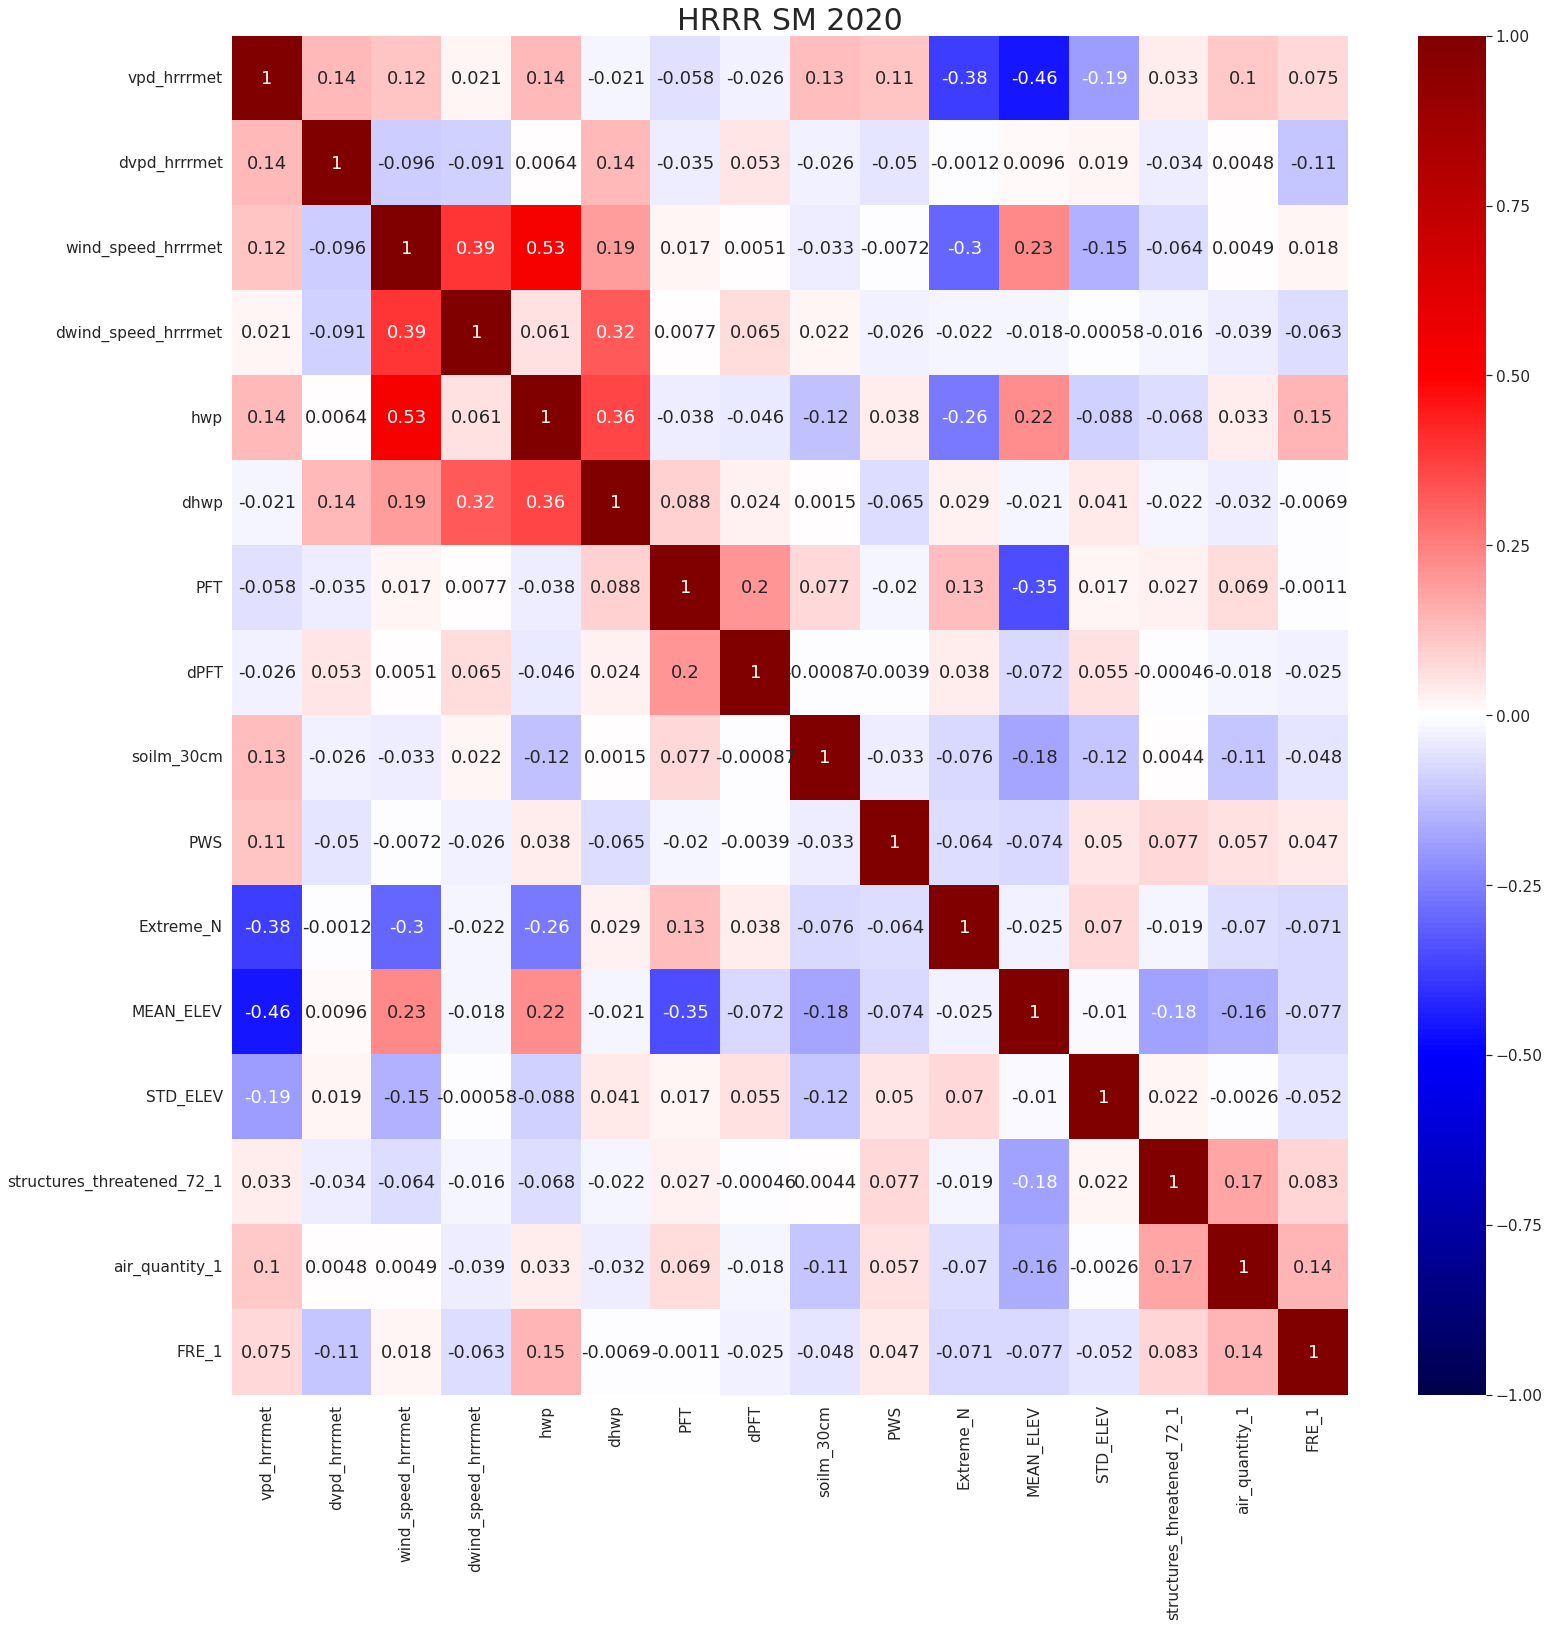

In [45]:
plot_correlations(data_train_1921[feature_subsets['features_hrrrmet_hwp']],
                  'HRRR SM 19/21','pearson', 18, (25,25))

plot_correlations(data_test_2020[feature_subsets['features_hrrrmet_hwp']],
                  'HRRR SM 2020','pearson', 18, (25,25))

In [44]:
print(feature_subsets['features_all'])

['vpd_gridmet', 'wind_speed_gridmet', 'dvpd_gridmet', 'dwind_speed_gridmet', 'max_air_temperature', 'min_air_temperature', 'temp_range', 'vpd_hrrrmet', 'wind_speed_hrrrmet', 'dvpd_hrrrmet', 'dwind_speed_hrrrmet', 'days_in_high_heatwave', 'days_in_highlow_heatwave', 'min_air_temperature', 'max_air_temperature', 'hwp', 'dhwp', 'dhd0w0', 'dhd1w0', 'dhd2w0', 'dhd3w0', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'dIMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_BUI', 'IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_BUI', 'dburning_index_g', 'denergy_release_component-g', 'burning_index_g', 'energy_release_component-g', 'PFT', 'chi', 'dchi', 'dPFT', 'FMCGLH2D', 'Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr', 'soilm_sfc', 'soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm', 'PWS', 'ESI', 'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'MEAN_SLOPE', 'STD_SLOPE', 'MEAN_ELEV', 'STD_ELEV', 'DOY', 'percent_contained

In [25]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5


feature_set_names = ['persistence','features_all','features_soilm_sfc', 
                     #'features_soilm_1cm', 'features_soilm_4cm', 'features_soilm_10cm', 
                     'features_hrrrmet_hwp',
                     'features_can_hwp', 'features_us_hwp', 'features_gridmet_hwp',
                     'features_hrrrmet_hdw',
                     'features_can_hdw', 'features_us_hdw', 'features_gridmet_hdw',
                    ]


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

features_all OOB R2 score is: 0.22050534046478187
features_soilm_sfc OOB R2 score is: 0.1981287646941916
features_hrrrmet_hwp OOB R2 score is: 0.19851169708137506
features_can_hwp OOB R2 score is: 0.16638057451739918
features_us_hwp OOB R2 score is: 0.17334136340772854
features_gridmet_hwp OOB R2 score is: 0.21678631941284887
features_hrrrmet_hdw OOB R2 score is: 0.16035528959562173
features_can_hdw OOB R2 score is: 0.1423156708123412
features_us_hdw OOB R2 score is: 0.16422663207684762
features_gridmet_hdw OOB R2 score is: 0.17172432444373043
DOING PERSISTENCE


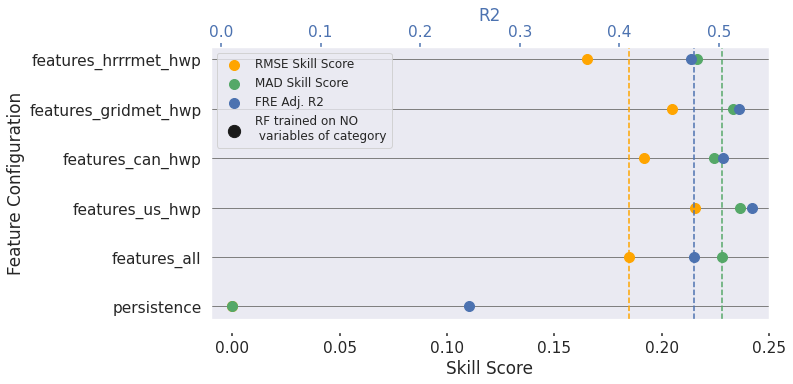

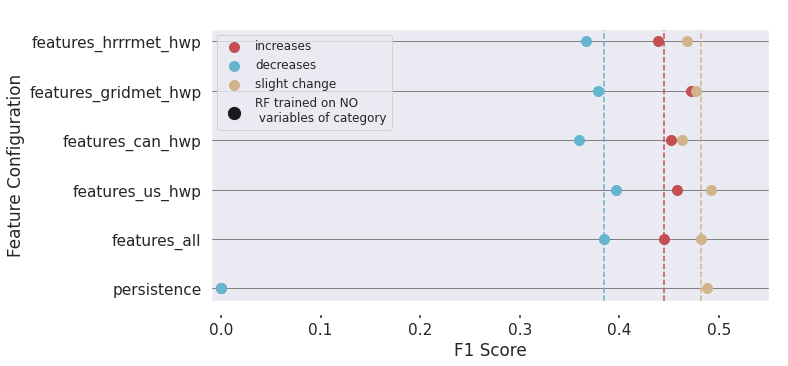

                        FRE_R2 FRE_R2_adj          FRE_RMSE          FRE_MAD  \
persistence           0.249789   0.249278  321690675.692184  92521743.965657   
features_all          0.501202   0.475157  262306390.475418  71409255.592035   
features_soilm_sfc    0.434633   0.428416  279261971.158445   73667406.62136   
features_hrrrmet_hwp  0.477033   0.471282  268586387.626208  72489047.262566   
features_can_hwp       0.50978   0.503707  260041209.588021  71779836.505619   
features_us_hwp       0.538514   0.533118  252305153.515733  70638014.421923   
features_gridmet_hwp  0.525618   0.519741  255806123.709891  70944342.842865   

                     log_FRE_R2 log_FRE_R2_adj log_FRE_RMSE log_FRE_MAD  \
persistence            0.749437       0.749267     0.570232    0.459932   
features_all           0.792985       0.782175     0.518316    0.410625   
features_soilm_sfc     0.787098       0.784757     0.525633    0.417788   
features_hrrrmet_hwp   0.785131       0.782769     0.528056

In [51]:
feature_plot_names = ['persistence','features_all',
                     'features_us_hwp', 'features_can_hwp', 'features_gridmet_hwp', 'features_hrrrmet_hwp'
                    ]
plot_frp_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[], 'features_all',(10,5), -.01,  -.01)
plot_f1_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[],'features_all',(10,5),  -.01)
print(df_error_metrics_rf)

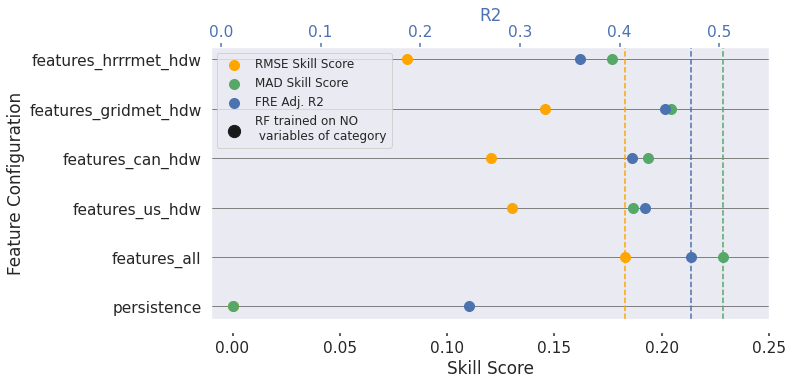

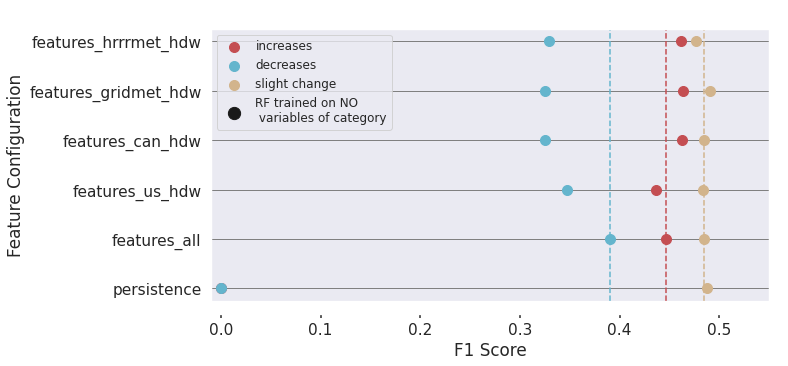

                        FRE_R2 FRE_R2_adj          FRE_RMSE          FRE_MAD  \
persistence           0.249789   0.249278  321690675.692184  92521743.965657   
features_all          0.498906   0.471227  262909577.512393  71371300.189499   
features_soilm_sfc    0.434633   0.428416  279261971.158445   73667406.62136   
features_hrrrmet_hwp  0.477033   0.471282  268586387.626208  72489047.262566   
features_can_hwp       0.50978   0.503707  260041209.588021  71779836.505619   
features_us_hwp       0.538514   0.533118  252305153.515733  70638014.421923   
features_gridmet_hwp  0.525618   0.519741  255806123.709891  70944342.842865   
features_hrrrmet_hdw  0.367006   0.360045   295492503.64267   76174190.75309   
features_can_hdw      0.419566   0.412375  282958811.715476  74613584.816593   
features_us_hdw       0.432256   0.425618  279848477.180088  75243846.506006   
features_gridmet_hdw  0.452412   0.445628  274836110.176573  73614702.832861   

                     log_FRE_R2 log_FRE

In [26]:
feature_plot_names = ['persistence','features_all',
                     'features_us_hdw', 'features_can_hdw', 'features_gridmet_hdw', 'features_hrrrmet_hdw'
                    ]
plot_frp_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[], 'features_all',(10,5), -.01,  -.01)
plot_f1_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[],'features_all',(10,5),  -.01)
print(df_error_metrics_rf)

# Test HDW 500m vs surface definition

In [ ]:
#LOAD IN THE FEATURE CSV
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weighted.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)


In [ ]:
#LOAD IN THE FEATURE CSV WITH HDW500
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
data_train_1921['obs_cat'] = pd.cut(data_train_1921['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])
print(len(data_train_1921))
print(str(len(data_train_1921[data_train_1921['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='increase'])) + ' increases')

In [ ]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['persistence','dhd0w0'] 

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

df_error_metrics_scaled = pd.DataFrame(index=scaled_methods, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#do the plottint
#drop the nans, these will show up in the scaled methods

data_test_2020= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]
print(len(data_test_2020))

#do the calculations
for ii in range(len(scaled_methods)):
    #print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfre'] = np.log10(data_test_2020[scaled_methods[ii]+'_fre'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
#print(data_test_2020.columns.values)    
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))


#get the error metrics
for ii in range(len(scaled_methods)):
    if scaled_methods[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', scaled_methods[ii]+'_fre',[scaled_methods[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', scaled_methods[ii]+'_logfre',[scaled_methods[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', scaled_methods[ii]+'_sf',[scaled_methods[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', scaled_methods[ii]+'_logsf',[scaled_methods[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020[scaled_methods[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_scaled.loc[scaled_methods[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_scaled.loc[scaled_methods[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_scaled['percent_change_FRE_RMSE'] = (df_error_metrics_scaled.loc['persistence','FRE_RMSE']-df_error_metrics_scaled['FRE_RMSE'])/df_error_metrics_scaled.loc['persistence','FRE_RMSE']
df_error_metrics_scaled['percent_change_FRE_MAD'] = (df_error_metrics_scaled.loc['persistence','FRE_MAD']-df_error_metrics_scaled['FRE_MAD'])/df_error_metrics_scaled.loc['persistence','FRE_MAD']


df_error_metrics_scaled['percent_change_SF_RMSE'] = (df_error_metrics_scaled.loc['persistence','SF_RMSE']-df_error_metrics_scaled['SF_RMSE'])/df_error_metrics_scaled.loc['persistence','SF_RMSE']
df_error_metrics_scaled['percent_change_SF_MAD'] = (df_error_metrics_scaled.loc['persistence','SF_MAD']-df_error_metrics_scaled['SF_MAD'])/df_error_metrics_scaled.loc['persistence','SF_MAD']

    

#persistence
frp_hist2d(data_test_2020, 'FRE_1', 'FRE','log_FRE_1', 'log_FRE', 'Blues', 0, 50,'Persistence Log(FRE)',['persistence'])
sf_hist2d(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor','Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,'Persistence Log(SF)',['persistence'])
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 Persistence Prediction') 



for ii in range(len(scaled_methods)):
    print(scaled_methods[ii])
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods[ii]+'_fre', 'FRE',scaled_methods[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,scaled_methods[ii]+' Log(FRE)',scaled_methods[ii])
    sf_hist2d(data_test_2020, scaled_methods[ii]+'_sf', 'Scaling_Factor',scaled_methods[ii]+'_logsf', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,scaled_methods[ii]+' Log(SF)',scaled_methods[ii])
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods[ii]+'_cat', '2020 '+scaled_methods[ii]+' Prediction')  


In [ ]:
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                    'living_moisture':['FMCGLH2D'],
                    'thin_moisture': ['Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC'],
                    'mid_moisture':['IMERG.FINAL.v6_DMC', 'dead_fuel_moisture_100hr'],
                    'thick_moisture':['IMERG.FINAL.v6_DC','dead_fuel_moisture_1000hr'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()

feature_subsets = {}
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

not_allowed = ['raw_weather_gridmet','temperature_gridmet','raw_weather_hrrr','heatwave','derived_weather_hwp','derived_weather_hdw',
                 'derived_weather_cffrds','derived_weather_nfdrs']
feature_subsets['features_only_hd0w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd0w0","dhd0w0"])


feature_subsets['features_hdw'] = ['hd0w0','dhd0w0',
                                   'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',  'FMCG2D', 'FMCGLH2D','PWS','Moderate_N','DOY',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

In [ ]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all', 'features_only_hd0w0', 'features_hdw']

df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

In [ ]:
df_error_metrics = pd.concat([df_error_metrics_scaled.loc[['dhd0w0'], ['FRE_R2_adj', 'percent_change_FRE_RMSE','percent_change_FRE_MAD',
                                      'increase_f1', 'decrease_f1', 'no_change_f1']], df_error_metrics_rf.loc[:,['FRE_R2_adj', 'percent_change_FRE_RMSE','percent_change_FRE_MAD',
                                      'increase_f1', 'decrease_f1', 'no_change_f1']]])
print(round(df_error_metrics.astype('float64'),2))
      
      